# Wasserstein GAN in Pytorch

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.
/home/flend/anaconda3/envs/pytorch/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import torch_utils; importlib.reload(torch_utils)
from torch_utils import *

The good news is that in the last month the GAN training problem has been solved! [This paper](https://arxiv.org/abs/1701.07875) shows a minor change to the loss function and constraining the weights allows a GAN to reliably learn following a consistent loss schedule.

First, we, set up batch size, image size, and size of noise vector:

In [3]:
bs,sz,nz = 256,64,100

Load dungeon maps from data/maps

In [4]:
import csvdataset; importlib.reload(csvdataset)
from csvdataset import CSVDataset

mapsLoader = CSVDataset("data/digger", "map", 20000)
dataloader = torch.utils.data.DataLoader(mapsLoader, bs, True, num_workers=4)

n = len(dataloader);
n

79

In [5]:
mapsLoader[0].shape

torch.Size([1, 64, 64])

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [6]:
def show(img, fs=(6,6)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')

In [13]:
def save(img, filename):
    plt.figure()
    plt.imsave(filename, np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)))

## Create model

The CNN definitions are a little big for a notebook, so we import them.

In [7]:
import dcgan; importlib.reload(dcgan)
from dcgan import DCGAN_D, DCGAN_GU2

Pytorch uses `module.apply()` for picking an initializer.

In [8]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
netG = DCGAN_GU2(sz, nz, 1, 64, 1, 1).cuda()
netG.apply(weights_init);

In [10]:
netD = DCGAN_D(sz, 1, 64, 1, 1).cuda()
netD.apply(weights_init);

Just some shortcuts to create tensors and variables.

In [11]:
from torch import FloatTensor as FT
def Var(*params): return Variable(FT(*params).cuda())

In [12]:
def create_noise(b): 
    return Variable(FT(b, nz, 1, 1).cuda().normal_(0, 1))

In [13]:
# Input placeholder
input = Var(bs, 3, sz, nz)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

An optimizer needs to be told what variables to optimize. A module automatically keeps track of its variables.

In [14]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

One forward step and one backward step for D

In [15]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [16]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [17]:
lossD = []
lossG = []
lossDreal = []
lossDfake = []

In [ ]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in range(niter):
        epoch_filename = str.format('gen_epoch_{}.pt', epoch)
        if not (epoch - 1) % 100:
            torch.save(netG, epoch_filename)
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)

            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter).cuda())
                netD.zero_grad()
                errD_real = step_D(real, one)

                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                optimizerD.step()
                #print('i[%d]' % i)

            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1
            
            print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f' % (
            epoch, niter, gen_iterations, n,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
            lossD.append(errD.data[0])
            lossG.append(errG.data[0])
            lossDreal.append(errD_real.data[0])
            lossDfake.append(errD_fake.data[0])

    torch.save(netG, epoch_filename)

In [ ]:
%time train(2000, True)

[0/2000][1/79] Loss_D: -1.427737 Loss_G: 0.706057 Loss_D_real: -0.741555 Loss_D_fake 0.686182
[1/2000][2/79] Loss_D: -1.501681 Loss_G: 0.728072 Loss_D_real: -0.791135 Loss_D_fake 0.710545
[2/2000][3/79] Loss_D: -1.530284 Loss_G: 0.738001 Loss_D_real: -0.807775 Loss_D_fake 0.722508
[3/2000][4/79] Loss_D: -1.536420 Loss_G: 0.738794 Loss_D_real: -0.813313 Loss_D_fake 0.723107
[4/2000][5/79] Loss_D: -1.545438 Loss_G: 0.740851 Loss_D_real: -0.819764 Loss_D_fake 0.725675
[5/2000][6/79] Loss_D: -1.552684 Loss_G: 0.743076 Loss_D_real: -0.823672 Loss_D_fake 0.729012
[6/2000][7/79] Loss_D: -1.554478 Loss_G: 0.743505 Loss_D_real: -0.825737 Loss_D_fake 0.728741
[7/2000][8/79] Loss_D: -1.554794 Loss_G: 0.742606 Loss_D_real: -0.826311 Loss_D_fake 0.728483
[8/2000][9/79] Loss_D: -1.558386 Loss_G: 0.744235 Loss_D_real: -0.829179 Loss_D_fake 0.729207
[9/2000][10/79] Loss_D: -1.560280 Loss_G: 0.744791 Loss_D_real: -0.830066 Loss_D_fake 0.730215
[10/2000][11/79] Loss_D: -1.560965 Loss_G: 0.745068 Loss_D_

[28/2000][87/79] Loss_D: -1.544927 Loss_G: 0.728726 Loss_D_real: -0.832350 Loss_D_fake 0.712577
[28/2000][88/79] Loss_D: -1.546197 Loss_G: 0.724568 Loss_D_real: -0.832776 Loss_D_fake 0.713422
[28/2000][89/79] Loss_D: -1.534785 Loss_G: 0.710988 Loss_D_real: -0.828486 Loss_D_fake 0.706299
[29/2000][90/79] Loss_D: -1.492599 Loss_G: 0.716906 Loss_D_real: -0.794075 Loss_D_fake 0.698524
[29/2000][91/79] Loss_D: -1.541186 Loss_G: 0.725125 Loss_D_real: -0.831229 Loss_D_fake 0.709957
[29/2000][92/79] Loss_D: -1.540960 Loss_G: 0.725846 Loss_D_real: -0.831359 Loss_D_fake 0.709601
[29/2000][93/79] Loss_D: -1.544282 Loss_G: 0.727319 Loss_D_real: -0.832273 Loss_D_fake 0.712009
[29/2000][94/79] Loss_D: -1.545149 Loss_G: 0.726739 Loss_D_real: -0.832917 Loss_D_fake 0.712232
[29/2000][95/79] Loss_D: -1.537139 Loss_G: 0.718882 Loss_D_real: -0.830202 Loss_D_fake 0.706937
[29/2000][96/79] Loss_D: -1.393170 Loss_G: 0.698694 Loss_D_real: -0.822241 Loss_D_fake 0.570929
[29/2000][97/79] Loss_D: -1.541813 Loss_

[34/2000][172/79] Loss_D: -1.530528 Loss_G: 0.715074 Loss_D_real: -0.828871 Loss_D_fake 0.701658
[34/2000][173/79] Loss_D: -1.525510 Loss_G: 0.710589 Loss_D_real: -0.828143 Loss_D_fake 0.697367
[34/2000][174/79] Loss_D: -1.495873 Loss_G: 0.681512 Loss_D_real: -0.812351 Loss_D_fake 0.683523
[34/2000][175/79] Loss_D: -1.269711 Loss_G: 0.682444 Loss_D_real: -0.816929 Loss_D_fake 0.452782
[34/2000][176/79] Loss_D: -1.520441 Loss_G: 0.712819 Loss_D_real: -0.825082 Loss_D_fake 0.695359
[34/2000][177/79] Loss_D: -1.529797 Loss_G: 0.714880 Loss_D_real: -0.829228 Loss_D_fake 0.700569
[34/2000][178/79] Loss_D: -1.531743 Loss_G: 0.717035 Loss_D_real: -0.829991 Loss_D_fake 0.701751
[34/2000][179/79] Loss_D: -1.532680 Loss_G: 0.717101 Loss_D_real: -0.830133 Loss_D_fake 0.702547
[34/2000][180/79] Loss_D: -1.533245 Loss_G: 0.717101 Loss_D_real: -0.830633 Loss_D_fake 0.702612
[34/2000][181/79] Loss_D: -1.530992 Loss_G: 0.716423 Loss_D_real: -0.829878 Loss_D_fake 0.701114
[34/2000][182/79] Loss_D: -1.5

[39/2000][257/79] Loss_D: -1.520071 Loss_G: 0.706941 Loss_D_real: -0.827297 Loss_D_fake 0.692773
[39/2000][258/79] Loss_D: -1.515414 Loss_G: 0.704804 Loss_D_real: -0.824965 Loss_D_fake 0.690449
[39/2000][259/79] Loss_D: -1.517798 Loss_G: 0.706704 Loss_D_real: -0.826806 Loss_D_fake 0.690992
[39/2000][260/79] Loss_D: -1.521954 Loss_G: 0.707730 Loss_D_real: -0.828466 Loss_D_fake 0.693489
[39/2000][261/79] Loss_D: -1.522596 Loss_G: 0.707655 Loss_D_real: -0.829251 Loss_D_fake 0.693345
[39/2000][262/79] Loss_D: -1.521530 Loss_G: 0.707380 Loss_D_real: -0.829782 Loss_D_fake 0.691748
[39/2000][263/79] Loss_D: -1.522611 Loss_G: 0.707572 Loss_D_real: -0.829456 Loss_D_fake 0.693155
[39/2000][264/79] Loss_D: -1.522357 Loss_G: 0.707152 Loss_D_real: -0.829603 Loss_D_fake 0.692754
[39/2000][265/79] Loss_D: -1.516739 Loss_G: 0.704126 Loss_D_real: -0.826831 Loss_D_fake 0.689908
[40/2000][266/79] Loss_D: -1.487994 Loss_G: 0.693595 Loss_D_real: -0.818570 Loss_D_fake 0.669424
[40/2000][267/79] Loss_D: -1.5

[44/2000][342/79] Loss_D: -1.519145 Loss_G: 0.702350 Loss_D_real: -0.831152 Loss_D_fake 0.687993
[44/2000][343/79] Loss_D: -1.518193 Loss_G: 0.699924 Loss_D_real: -0.831146 Loss_D_fake 0.687047
[44/2000][344/79] Loss_D: -1.507828 Loss_G: 0.694842 Loss_D_real: -0.828290 Loss_D_fake 0.679539
[44/2000][345/79] Loss_D: -1.475958 Loss_G: 0.690801 Loss_D_real: -0.822391 Loss_D_fake 0.653566
[45/2000][346/79] Loss_D: -1.519831 Loss_G: 0.702469 Loss_D_real: -0.830950 Loss_D_fake 0.688881
[45/2000][347/79] Loss_D: -1.515991 Loss_G: 0.697367 Loss_D_real: -0.831005 Loss_D_fake 0.684986
[45/2000][348/79] Loss_D: -1.513355 Loss_G: 0.700533 Loss_D_real: -0.828251 Loss_D_fake 0.685104
[45/2000][349/79] Loss_D: -1.522129 Loss_G: 0.703958 Loss_D_real: -0.832592 Loss_D_fake 0.689537
[45/2000][350/79] Loss_D: -1.520744 Loss_G: 0.701513 Loss_D_real: -0.832271 Loss_D_fake 0.688474
[45/2000][351/79] Loss_D: -1.516621 Loss_G: 0.697504 Loss_D_real: -0.830481 Loss_D_fake 0.686140
[45/2000][352/79] Loss_D: -1.5

[50/2000][427/79] Loss_D: -1.512435 Loss_G: 0.696351 Loss_D_real: -0.830436 Loss_D_fake 0.681998
[50/2000][428/79] Loss_D: -1.503541 Loss_G: 0.677748 Loss_D_real: -0.825135 Loss_D_fake 0.678406
[50/2000][429/79] Loss_D: -1.197927 Loss_G: 0.644805 Loss_D_real: -0.691899 Loss_D_fake 0.506028
[50/2000][430/79] Loss_D: -1.509805 Loss_G: 0.696460 Loss_D_real: -0.829076 Loss_D_fake 0.680729
[50/2000][431/79] Loss_D: -1.517279 Loss_G: 0.699146 Loss_D_real: -0.832381 Loss_D_fake 0.684898
[50/2000][432/79] Loss_D: -1.518837 Loss_G: 0.700640 Loss_D_real: -0.832923 Loss_D_fake 0.685914
[50/2000][433/79] Loss_D: -1.518377 Loss_G: 0.699084 Loss_D_real: -0.833041 Loss_D_fake 0.685336
[50/2000][434/79] Loss_D: -1.520118 Loss_G: 0.702068 Loss_D_real: -0.832964 Loss_D_fake 0.687154
[50/2000][435/79] Loss_D: -1.520807 Loss_G: 0.701098 Loss_D_real: -0.833742 Loss_D_fake 0.687064
[50/2000][436/79] Loss_D: -1.518082 Loss_G: 0.699518 Loss_D_real: -0.833063 Loss_D_fake 0.685019
[50/2000][437/79] Loss_D: -1.5

[55/2000][512/79] Loss_D: -1.506115 Loss_G: 0.688893 Loss_D_real: -0.830785 Loss_D_fake 0.675330
[55/2000][513/79] Loss_D: -1.508554 Loss_G: 0.687295 Loss_D_real: -0.833270 Loss_D_fake 0.675283
[55/2000][514/79] Loss_D: -1.514877 Loss_G: 0.692257 Loss_D_real: -0.834575 Loss_D_fake 0.680302
[55/2000][515/79] Loss_D: -1.510165 Loss_G: 0.689632 Loss_D_real: -0.834265 Loss_D_fake 0.675900
[55/2000][516/79] Loss_D: -1.509055 Loss_G: 0.685975 Loss_D_real: -0.834055 Loss_D_fake 0.674999
[55/2000][517/79] Loss_D: -1.506898 Loss_G: 0.685076 Loss_D_real: -0.832957 Loss_D_fake 0.673941
[56/2000][518/79] Loss_D: -1.510421 Loss_G: 0.692149 Loss_D_real: -0.833169 Loss_D_fake 0.677252
[56/2000][519/79] Loss_D: -1.511010 Loss_G: 0.688306 Loss_D_real: -0.833799 Loss_D_fake 0.677211
[56/2000][520/79] Loss_D: -1.504389 Loss_G: 0.686165 Loss_D_real: -0.831956 Loss_D_fake 0.672433
[56/2000][521/79] Loss_D: -1.510956 Loss_G: 0.690134 Loss_D_real: -0.833602 Loss_D_fake 0.677353
[56/2000][522/79] Loss_D: -1.5

[60/2000][597/79] Loss_D: -1.508888 Loss_G: 0.686606 Loss_D_real: -0.834537 Loss_D_fake 0.674350
[61/2000][598/79] Loss_D: -1.512284 Loss_G: 0.690318 Loss_D_real: -0.834668 Loss_D_fake 0.677617
[61/2000][599/79] Loss_D: -1.510279 Loss_G: 0.689073 Loss_D_real: -0.834580 Loss_D_fake 0.675699
[61/2000][600/79] Loss_D: -1.508206 Loss_G: 0.689120 Loss_D_real: -0.834037 Loss_D_fake 0.674170
[61/2000][601/79] Loss_D: -1.510603 Loss_G: 0.690013 Loss_D_real: -0.835088 Loss_D_fake 0.675516
[61/2000][602/79] Loss_D: -1.509939 Loss_G: 0.690082 Loss_D_real: -0.834841 Loss_D_fake 0.675098
[61/2000][603/79] Loss_D: -1.508281 Loss_G: 0.687688 Loss_D_real: -0.834793 Loss_D_fake 0.673488
[61/2000][604/79] Loss_D: -1.507109 Loss_G: 0.686497 Loss_D_real: -0.834427 Loss_D_fake 0.672682
[61/2000][605/79] Loss_D: -1.509459 Loss_G: 0.689166 Loss_D_real: -0.834534 Loss_D_fake 0.674926
[61/2000][606/79] Loss_D: -1.511349 Loss_G: 0.690017 Loss_D_real: -0.835410 Loss_D_fake 0.675939
[61/2000][607/79] Loss_D: -1.5

[66/2000][682/79] Loss_D: -1.504194 Loss_G: 0.682196 Loss_D_real: -0.835734 Loss_D_fake 0.668460
[66/2000][683/79] Loss_D: -1.504895 Loss_G: 0.678605 Loss_D_real: -0.835766 Loss_D_fake 0.669129
[66/2000][684/79] Loss_D: -1.506682 Loss_G: 0.681056 Loss_D_real: -0.835746 Loss_D_fake 0.670936
[66/2000][685/79] Loss_D: -1.504439 Loss_G: 0.684294 Loss_D_real: -0.834679 Loss_D_fake 0.669761
[66/2000][686/79] Loss_D: -1.505592 Loss_G: 0.681033 Loss_D_real: -0.835493 Loss_D_fake 0.670098
[66/2000][687/79] Loss_D: -1.504329 Loss_G: 0.682099 Loss_D_real: -0.835545 Loss_D_fake 0.668784
[66/2000][688/79] Loss_D: -1.503901 Loss_G: 0.679511 Loss_D_real: -0.835606 Loss_D_fake 0.668295
[66/2000][689/79] Loss_D: -1.504939 Loss_G: 0.682085 Loss_D_real: -0.835313 Loss_D_fake 0.669626
[66/2000][690/79] Loss_D: -1.505255 Loss_G: 0.684610 Loss_D_real: -0.834781 Loss_D_fake 0.670474
[66/2000][691/79] Loss_D: -1.503330 Loss_G: 0.680000 Loss_D_real: -0.835266 Loss_D_fake 0.668064
[66/2000][692/79] Loss_D: -1.4

[71/2000][767/79] Loss_D: -1.503309 Loss_G: 0.678004 Loss_D_real: -0.835786 Loss_D_fake 0.667523
[71/2000][768/79] Loss_D: -1.501978 Loss_G: 0.680523 Loss_D_real: -0.835446 Loss_D_fake 0.666532
[71/2000][769/79] Loss_D: -1.501866 Loss_G: 0.675718 Loss_D_real: -0.835861 Loss_D_fake 0.666004
[71/2000][770/79] Loss_D: -1.502656 Loss_G: 0.679921 Loss_D_real: -0.835599 Loss_D_fake 0.667057
[71/2000][771/79] Loss_D: -1.499467 Loss_G: 0.677627 Loss_D_real: -0.835409 Loss_D_fake 0.664058
[71/2000][772/79] Loss_D: -1.500469 Loss_G: 0.674958 Loss_D_real: -0.834419 Loss_D_fake 0.666049
[71/2000][773/79] Loss_D: -1.496194 Loss_G: 0.674446 Loss_D_real: -0.833047 Loss_D_fake 0.663147
[72/2000][774/79] Loss_D: -1.502618 Loss_G: 0.679867 Loss_D_real: -0.835873 Loss_D_fake 0.666745
[72/2000][775/79] Loss_D: -1.501067 Loss_G: 0.681270 Loss_D_real: -0.835400 Loss_D_fake 0.665667
[72/2000][776/79] Loss_D: -1.500853 Loss_G: 0.676775 Loss_D_real: -0.836038 Loss_D_fake 0.664815
[72/2000][777/79] Loss_D: -1.4

[76/2000][852/79] Loss_D: -1.500178 Loss_G: 0.677382 Loss_D_real: -0.835728 Loss_D_fake 0.664450
[76/2000][853/79] Loss_D: -1.496004 Loss_G: 0.674825 Loss_D_real: -0.834228 Loss_D_fake 0.661776
[77/2000][854/79] Loss_D: -1.501586 Loss_G: 0.679294 Loss_D_real: -0.836006 Loss_D_fake 0.665581
[77/2000][855/79] Loss_D: -1.500413 Loss_G: 0.677590 Loss_D_real: -0.835558 Loss_D_fake 0.664855
[77/2000][856/79] Loss_D: -1.501747 Loss_G: 0.680787 Loss_D_real: -0.835498 Loss_D_fake 0.666249
[77/2000][857/79] Loss_D: -1.500146 Loss_G: 0.674881 Loss_D_real: -0.835587 Loss_D_fake 0.664559
[77/2000][858/79] Loss_D: -1.498952 Loss_G: 0.677566 Loss_D_real: -0.833440 Loss_D_fake 0.665512
[77/2000][859/79] Loss_D: -1.494829 Loss_G: 0.673308 Loss_D_real: -0.833763 Loss_D_fake 0.661067
[77/2000][860/79] Loss_D: -1.497548 Loss_G: 0.676404 Loss_D_real: -0.834039 Loss_D_fake 0.663509
[77/2000][861/79] Loss_D: -1.499033 Loss_G: 0.678727 Loss_D_real: -0.835287 Loss_D_fake 0.663746
[77/2000][862/79] Loss_D: -1.5

[82/2000][937/79] Loss_D: -1.498137 Loss_G: 0.676092 Loss_D_real: -0.835705 Loss_D_fake 0.662431
[82/2000][938/79] Loss_D: -1.498591 Loss_G: 0.675820 Loss_D_real: -0.836140 Loss_D_fake 0.662451
[82/2000][939/79] Loss_D: -1.501029 Loss_G: 0.677372 Loss_D_real: -0.836561 Loss_D_fake 0.664468
[82/2000][940/79] Loss_D: -1.497833 Loss_G: 0.671845 Loss_D_real: -0.836153 Loss_D_fake 0.661680
[82/2000][941/79] Loss_D: -1.494726 Loss_G: 0.671796 Loss_D_real: -0.836074 Loss_D_fake 0.658652
[82/2000][942/79] Loss_D: -1.496601 Loss_G: 0.671937 Loss_D_real: -0.836103 Loss_D_fake 0.660498
[82/2000][943/79] Loss_D: -1.484758 Loss_G: 0.671070 Loss_D_real: -0.828662 Loss_D_fake 0.656096
[82/2000][944/79] Loss_D: -1.497758 Loss_G: 0.677108 Loss_D_real: -0.835927 Loss_D_fake 0.661831
[82/2000][945/79] Loss_D: -1.498788 Loss_G: 0.675475 Loss_D_real: -0.836686 Loss_D_fake 0.662102
[82/2000][946/79] Loss_D: -1.498692 Loss_G: 0.673556 Loss_D_real: -0.836658 Loss_D_fake 0.662034
[82/2000][947/79] Loss_D: -1.4

[88/2000][1022/79] Loss_D: -1.496341 Loss_G: 0.671538 Loss_D_real: -0.836801 Loss_D_fake 0.659540
[88/2000][1023/79] Loss_D: -1.495142 Loss_G: 0.672891 Loss_D_real: -0.836372 Loss_D_fake 0.658770
[88/2000][1024/79] Loss_D: -1.496969 Loss_G: 0.673568 Loss_D_real: -0.836799 Loss_D_fake 0.660171
[88/2000][1025/79] Loss_D: -1.496706 Loss_G: 0.671436 Loss_D_real: -0.836962 Loss_D_fake 0.659744
[88/2000][1026/79] Loss_D: -1.497157 Loss_G: 0.671760 Loss_D_real: -0.836839 Loss_D_fake 0.660317
[88/2000][1027/79] Loss_D: -1.492287 Loss_G: 0.669706 Loss_D_real: -0.835947 Loss_D_fake 0.656339
[88/2000][1028/79] Loss_D: -1.496959 Loss_G: 0.672109 Loss_D_real: -0.837078 Loss_D_fake 0.659881
[88/2000][1029/79] Loss_D: -1.496776 Loss_G: 0.673493 Loss_D_real: -0.836857 Loss_D_fake 0.659920
[88/2000][1030/79] Loss_D: -1.495060 Loss_G: 0.671682 Loss_D_real: -0.836620 Loss_D_fake 0.658441
[88/2000][1031/79] Loss_D: -1.494824 Loss_G: 0.672455 Loss_D_real: -0.836326 Loss_D_fake 0.658498
[88/2000][1032/79] L

[93/2000][1106/79] Loss_D: -1.494223 Loss_G: 0.669747 Loss_D_real: -0.836463 Loss_D_fake 0.657760
[93/2000][1107/79] Loss_D: -1.493606 Loss_G: 0.669833 Loss_D_real: -0.837170 Loss_D_fake 0.656437
[93/2000][1108/79] Loss_D: -1.492939 Loss_G: 0.669572 Loss_D_real: -0.836645 Loss_D_fake 0.656293
[93/2000][1109/79] Loss_D: -1.493227 Loss_G: 0.668869 Loss_D_real: -0.836825 Loss_D_fake 0.656403
[93/2000][1110/79] Loss_D: -1.491081 Loss_G: 0.667679 Loss_D_real: -0.835329 Loss_D_fake 0.655752
[93/2000][1111/79] Loss_D: -1.481610 Loss_G: 0.664389 Loss_D_real: -0.831589 Loss_D_fake 0.650021
[93/2000][1112/79] Loss_D: -1.490860 Loss_G: 0.668953 Loss_D_real: -0.835448 Loss_D_fake 0.655412
[93/2000][1113/79] Loss_D: -1.486735 Loss_G: 0.661425 Loss_D_real: -0.834101 Loss_D_fake 0.652634
[94/2000][1114/79] Loss_D: -1.496004 Loss_G: 0.672171 Loss_D_real: -0.837567 Loss_D_fake 0.658437
[94/2000][1115/79] Loss_D: -1.495328 Loss_G: 0.671552 Loss_D_real: -0.837530 Loss_D_fake 0.657798
[94/2000][1116/79] L

[98/2000][1190/79] Loss_D: -1.490825 Loss_G: 0.666063 Loss_D_real: -0.837462 Loss_D_fake 0.653363
[98/2000][1191/79] Loss_D: -1.492244 Loss_G: 0.665287 Loss_D_real: -0.837728 Loss_D_fake 0.654516
[98/2000][1192/79] Loss_D: -1.489014 Loss_G: 0.665738 Loss_D_real: -0.837731 Loss_D_fake 0.651283
[98/2000][1193/79] Loss_D: -1.492661 Loss_G: 0.666378 Loss_D_real: -0.838170 Loss_D_fake 0.654491
[99/2000][1194/79] Loss_D: -1.492235 Loss_G: 0.666672 Loss_D_real: -0.837906 Loss_D_fake 0.654329
[99/2000][1195/79] Loss_D: -1.490999 Loss_G: 0.666893 Loss_D_real: -0.837690 Loss_D_fake 0.653309
[99/2000][1196/79] Loss_D: -1.491719 Loss_G: 0.666590 Loss_D_real: -0.837865 Loss_D_fake 0.653854
[99/2000][1197/79] Loss_D: -1.491465 Loss_G: 0.666890 Loss_D_real: -0.837556 Loss_D_fake 0.653910
[99/2000][1198/79] Loss_D: -1.488936 Loss_G: 0.666601 Loss_D_real: -0.837365 Loss_D_fake 0.651571
[99/2000][1199/79] Loss_D: -1.489807 Loss_G: 0.666759 Loss_D_real: -0.837488 Loss_D_fake 0.652318
[99/2000][1200/79] L

[103/2000][1273/79] Loss_D: -1.489622 Loss_G: 0.662163 Loss_D_real: -0.838353 Loss_D_fake 0.651269
[104/2000][1274/79] Loss_D: -1.491440 Loss_G: 0.666168 Loss_D_real: -0.838739 Loss_D_fake 0.652701
[104/2000][1275/79] Loss_D: -1.490479 Loss_G: 0.664293 Loss_D_real: -0.838678 Loss_D_fake 0.651802
[104/2000][1276/79] Loss_D: -1.490192 Loss_G: 0.662869 Loss_D_real: -0.838627 Loss_D_fake 0.651565
[104/2000][1277/79] Loss_D: -1.488009 Loss_G: 0.663054 Loss_D_real: -0.838396 Loss_D_fake 0.649612
[104/2000][1278/79] Loss_D: -1.489183 Loss_G: 0.663564 Loss_D_real: -0.838157 Loss_D_fake 0.651026
[104/2000][1279/79] Loss_D: -1.487842 Loss_G: 0.662408 Loss_D_real: -0.838607 Loss_D_fake 0.649236
[104/2000][1280/79] Loss_D: -1.488403 Loss_G: 0.662406 Loss_D_real: -0.838682 Loss_D_fake 0.649721
[104/2000][1281/79] Loss_D: -1.489871 Loss_G: 0.663219 Loss_D_real: -0.838112 Loss_D_fake 0.651758
[104/2000][1282/79] Loss_D: -1.488205 Loss_G: 0.663283 Loss_D_real: -0.837965 Loss_D_fake 0.650240
[104/2000]

[109/2000][1356/79] Loss_D: -1.487988 Loss_G: 0.662671 Loss_D_real: -0.838451 Loss_D_fake 0.649537
[109/2000][1357/79] Loss_D: -1.487937 Loss_G: 0.662522 Loss_D_real: -0.838758 Loss_D_fake 0.649180
[109/2000][1358/79] Loss_D: -1.487889 Loss_G: 0.661378 Loss_D_real: -0.839345 Loss_D_fake 0.648544
[109/2000][1359/79] Loss_D: -1.487803 Loss_G: 0.661572 Loss_D_real: -0.839065 Loss_D_fake 0.648739
[109/2000][1360/79] Loss_D: -1.485359 Loss_G: 0.659633 Loss_D_real: -0.838300 Loss_D_fake 0.647058
[109/2000][1361/79] Loss_D: -1.485782 Loss_G: 0.660066 Loss_D_real: -0.837941 Loss_D_fake 0.647841
[109/2000][1362/79] Loss_D: -1.482837 Loss_G: 0.660115 Loss_D_real: -0.837255 Loss_D_fake 0.645582
[109/2000][1363/79] Loss_D: -1.487138 Loss_G: 0.661271 Loss_D_real: -0.838545 Loss_D_fake 0.648592
[109/2000][1364/79] Loss_D: -1.486835 Loss_G: 0.660953 Loss_D_real: -0.838924 Loss_D_fake 0.647911
[109/2000][1365/79] Loss_D: -1.486921 Loss_G: 0.661770 Loss_D_real: -0.837896 Loss_D_fake 0.649025
[109/2000]

[114/2000][1439/79] Loss_D: -1.485206 Loss_G: 0.658658 Loss_D_real: -0.839075 Loss_D_fake 0.646132
[114/2000][1440/79] Loss_D: -1.483710 Loss_G: 0.657977 Loss_D_real: -0.838806 Loss_D_fake 0.644904
[114/2000][1441/79] Loss_D: -1.483941 Loss_G: 0.657725 Loss_D_real: -0.838613 Loss_D_fake 0.645328
[114/2000][1442/79] Loss_D: -1.485975 Loss_G: 0.658819 Loss_D_real: -0.839360 Loss_D_fake 0.646615
[114/2000][1443/79] Loss_D: -1.485420 Loss_G: 0.657770 Loss_D_real: -0.839341 Loss_D_fake 0.646079
[114/2000][1444/79] Loss_D: -1.484799 Loss_G: 0.659028 Loss_D_real: -0.839090 Loss_D_fake 0.645709
[114/2000][1445/79] Loss_D: -1.484926 Loss_G: 0.658596 Loss_D_real: -0.839073 Loss_D_fake 0.645853
[114/2000][1446/79] Loss_D: -1.484804 Loss_G: 0.659591 Loss_D_real: -0.838676 Loss_D_fake 0.646128
[114/2000][1447/79] Loss_D: -1.484419 Loss_G: 0.658434 Loss_D_real: -0.838965 Loss_D_fake 0.645455
[114/2000][1448/79] Loss_D: -1.484858 Loss_G: 0.658265 Loss_D_real: -0.838874 Loss_D_fake 0.645984
[114/2000]

[120/2000][1522/79] Loss_D: -1.482627 Loss_G: 0.656707 Loss_D_real: -0.838701 Loss_D_fake 0.643926
[120/2000][1523/79] Loss_D: -1.480479 Loss_G: 0.656931 Loss_D_real: -0.836502 Loss_D_fake 0.643977
[120/2000][1524/79] Loss_D: -1.484390 Loss_G: 0.657291 Loss_D_real: -0.839721 Loss_D_fake 0.644669
[120/2000][1525/79] Loss_D: -1.484429 Loss_G: 0.657223 Loss_D_real: -0.839967 Loss_D_fake 0.644462
[120/2000][1526/79] Loss_D: -1.484345 Loss_G: 0.657231 Loss_D_real: -0.839115 Loss_D_fake 0.645231
[120/2000][1527/79] Loss_D: -1.484693 Loss_G: 0.657603 Loss_D_real: -0.839754 Loss_D_fake 0.644939
[120/2000][1528/79] Loss_D: -1.483975 Loss_G: 0.657767 Loss_D_real: -0.839040 Loss_D_fake 0.644936
[120/2000][1529/79] Loss_D: -1.484099 Loss_G: 0.656878 Loss_D_real: -0.839725 Loss_D_fake 0.644374
[120/2000][1530/79] Loss_D: -1.484028 Loss_G: 0.656568 Loss_D_real: -0.839967 Loss_D_fake 0.644061
[120/2000][1531/79] Loss_D: -1.484143 Loss_G: 0.657210 Loss_D_real: -0.839870 Loss_D_fake 0.644272
[120/2000]

[125/2000][1605/79] Loss_D: -1.483545 Loss_G: 0.656156 Loss_D_real: -0.840338 Loss_D_fake 0.643207
[125/2000][1606/79] Loss_D: -1.483765 Loss_G: 0.656324 Loss_D_real: -0.840134 Loss_D_fake 0.643631
[125/2000][1607/79] Loss_D: -1.484197 Loss_G: 0.656251 Loss_D_real: -0.840384 Loss_D_fake 0.643812
[125/2000][1608/79] Loss_D: -1.483808 Loss_G: 0.656653 Loss_D_real: -0.840350 Loss_D_fake 0.643458
[125/2000][1609/79] Loss_D: -1.484550 Loss_G: 0.656111 Loss_D_real: -0.840777 Loss_D_fake 0.643773
[125/2000][1610/79] Loss_D: -1.483625 Loss_G: 0.656102 Loss_D_real: -0.840400 Loss_D_fake 0.643225
[125/2000][1611/79] Loss_D: -1.483422 Loss_G: 0.656214 Loss_D_real: -0.839996 Loss_D_fake 0.643426
[125/2000][1612/79] Loss_D: -1.482853 Loss_G: 0.656399 Loss_D_real: -0.839317 Loss_D_fake 0.643537
[125/2000][1613/79] Loss_D: -1.482360 Loss_G: 0.653985 Loss_D_real: -0.840148 Loss_D_fake 0.642212
[126/2000][1614/79] Loss_D: -1.484434 Loss_G: 0.657179 Loss_D_real: -0.840169 Loss_D_fake 0.644265
[126/2000]

[130/2000][1688/79] Loss_D: -1.483962 Loss_G: 0.656033 Loss_D_real: -0.840769 Loss_D_fake 0.643193
[130/2000][1689/79] Loss_D: -1.484434 Loss_G: 0.656556 Loss_D_real: -0.840880 Loss_D_fake 0.643554
[130/2000][1690/79] Loss_D: -1.484609 Loss_G: 0.656213 Loss_D_real: -0.841206 Loss_D_fake 0.643403
[130/2000][1691/79] Loss_D: -1.484414 Loss_G: 0.655920 Loss_D_real: -0.841305 Loss_D_fake 0.643109
[130/2000][1692/79] Loss_D: -1.484367 Loss_G: 0.655854 Loss_D_real: -0.841011 Loss_D_fake 0.643356
[130/2000][1693/79] Loss_D: -1.484761 Loss_G: 0.655527 Loss_D_real: -0.841393 Loss_D_fake 0.643368
[131/2000][1694/79] Loss_D: -1.484297 Loss_G: 0.655779 Loss_D_real: -0.841246 Loss_D_fake 0.643050
[131/2000][1695/79] Loss_D: -1.484406 Loss_G: 0.655972 Loss_D_real: -0.840976 Loss_D_fake 0.643430
[131/2000][1696/79] Loss_D: -1.483391 Loss_G: 0.655913 Loss_D_real: -0.840335 Loss_D_fake 0.643056
[131/2000][1697/79] Loss_D: -1.484773 Loss_G: 0.656398 Loss_D_real: -0.841340 Loss_D_fake 0.643433
[131/2000]

[135/2000][1771/79] Loss_D: -1.484100 Loss_G: 0.655693 Loss_D_real: -0.841186 Loss_D_fake 0.642914
[135/2000][1772/79] Loss_D: -1.484947 Loss_G: 0.656052 Loss_D_real: -0.841556 Loss_D_fake 0.643391
[135/2000][1773/79] Loss_D: -1.484926 Loss_G: 0.656006 Loss_D_real: -0.841601 Loss_D_fake 0.643325
[136/2000][1774/79] Loss_D: -1.484549 Loss_G: 0.656114 Loss_D_real: -0.841279 Loss_D_fake 0.643270
[136/2000][1775/79] Loss_D: -1.484479 Loss_G: 0.655900 Loss_D_real: -0.841386 Loss_D_fake 0.643093
[136/2000][1776/79] Loss_D: -1.484746 Loss_G: 0.656381 Loss_D_real: -0.841341 Loss_D_fake 0.643405
[136/2000][1777/79] Loss_D: -1.485006 Loss_G: 0.656444 Loss_D_real: -0.841507 Loss_D_fake 0.643499
[136/2000][1778/79] Loss_D: -1.484613 Loss_G: 0.655687 Loss_D_real: -0.841480 Loss_D_fake 0.643133
[136/2000][1779/79] Loss_D: -1.484849 Loss_G: 0.655868 Loss_D_real: -0.841457 Loss_D_fake 0.643392
[136/2000][1780/79] Loss_D: -1.484630 Loss_G: 0.655897 Loss_D_real: -0.841605 Loss_D_fake 0.643025
[136/2000]

[141/2000][1854/79] Loss_D: -1.485282 Loss_G: 0.656120 Loss_D_real: -0.841898 Loss_D_fake 0.643384
[141/2000][1855/79] Loss_D: -1.485336 Loss_G: 0.656022 Loss_D_real: -0.842088 Loss_D_fake 0.643248
[141/2000][1856/79] Loss_D: -1.484579 Loss_G: 0.656245 Loss_D_real: -0.841436 Loss_D_fake 0.643143
[141/2000][1857/79] Loss_D: -1.482127 Loss_G: 0.656349 Loss_D_real: -0.838870 Loss_D_fake 0.643257
[141/2000][1858/79] Loss_D: -1.485213 Loss_G: 0.655915 Loss_D_real: -0.842179 Loss_D_fake 0.643034
[141/2000][1859/79] Loss_D: -1.485187 Loss_G: 0.656260 Loss_D_real: -0.841960 Loss_D_fake 0.643227
[141/2000][1860/79] Loss_D: -1.484730 Loss_G: 0.656077 Loss_D_real: -0.841548 Loss_D_fake 0.643182
[141/2000][1861/79] Loss_D: -1.485289 Loss_G: 0.656417 Loss_D_real: -0.841762 Loss_D_fake 0.643526
[141/2000][1862/79] Loss_D: -1.485059 Loss_G: 0.656175 Loss_D_real: -0.841777 Loss_D_fake 0.643282
[141/2000][1863/79] Loss_D: -1.485135 Loss_G: 0.655748 Loss_D_real: -0.842043 Loss_D_fake 0.643092
[141/2000]

[146/2000][1937/79] Loss_D: -1.485167 Loss_G: 0.655919 Loss_D_real: -0.842114 Loss_D_fake 0.643054
[146/2000][1938/79] Loss_D: -1.484528 Loss_G: 0.656106 Loss_D_real: -0.841355 Loss_D_fake 0.643173
[146/2000][1939/79] Loss_D: -1.484822 Loss_G: 0.656126 Loss_D_real: -0.841525 Loss_D_fake 0.643297
[146/2000][1940/79] Loss_D: -1.485850 Loss_G: 0.656284 Loss_D_real: -0.842362 Loss_D_fake 0.643488
[146/2000][1941/79] Loss_D: -1.485369 Loss_G: 0.656286 Loss_D_real: -0.842025 Loss_D_fake 0.643345
[146/2000][1942/79] Loss_D: -1.485576 Loss_G: 0.656179 Loss_D_real: -0.842204 Loss_D_fake 0.643372
[146/2000][1943/79] Loss_D: -1.485303 Loss_G: 0.655983 Loss_D_real: -0.842142 Loss_D_fake 0.643162
[146/2000][1944/79] Loss_D: -1.484817 Loss_G: 0.656012 Loss_D_real: -0.841585 Loss_D_fake 0.643231
[146/2000][1945/79] Loss_D: -1.485598 Loss_G: 0.655987 Loss_D_real: -0.842224 Loss_D_fake 0.643374
[146/2000][1946/79] Loss_D: -1.485264 Loss_G: 0.656099 Loss_D_real: -0.842014 Loss_D_fake 0.643250
[146/2000]

[152/2000][2020/79] Loss_D: -1.484680 Loss_G: 0.656102 Loss_D_real: -0.841472 Loss_D_fake 0.643208
[152/2000][2021/79] Loss_D: -1.485878 Loss_G: 0.656326 Loss_D_real: -0.842453 Loss_D_fake 0.643425
[152/2000][2022/79] Loss_D: -1.485498 Loss_G: 0.656243 Loss_D_real: -0.842089 Loss_D_fake 0.643409
[152/2000][2023/79] Loss_D: -1.485198 Loss_G: 0.655933 Loss_D_real: -0.841935 Loss_D_fake 0.643263
[152/2000][2024/79] Loss_D: -1.484608 Loss_G: 0.656110 Loss_D_real: -0.841306 Loss_D_fake 0.643303
[152/2000][2025/79] Loss_D: -1.485185 Loss_G: 0.656257 Loss_D_real: -0.841816 Loss_D_fake 0.643369
[152/2000][2026/79] Loss_D: -1.485776 Loss_G: 0.656231 Loss_D_real: -0.842349 Loss_D_fake 0.643427
[152/2000][2027/79] Loss_D: -1.485111 Loss_G: 0.656054 Loss_D_real: -0.841901 Loss_D_fake 0.643210
[152/2000][2028/79] Loss_D: -1.485241 Loss_G: 0.655988 Loss_D_real: -0.841990 Loss_D_fake 0.643250
[152/2000][2029/79] Loss_D: -1.485506 Loss_G: 0.655837 Loss_D_real: -0.842429 Loss_D_fake 0.643077
[152/2000]

[157/2000][2103/79] Loss_D: -1.485998 Loss_G: 0.656375 Loss_D_real: -0.842552 Loss_D_fake 0.643446
[157/2000][2104/79] Loss_D: -1.485855 Loss_G: 0.656294 Loss_D_real: -0.842381 Loss_D_fake 0.643474
[157/2000][2105/79] Loss_D: -1.485263 Loss_G: 0.656296 Loss_D_real: -0.841867 Loss_D_fake 0.643395
[157/2000][2106/79] Loss_D: -1.485839 Loss_G: 0.656388 Loss_D_real: -0.842289 Loss_D_fake 0.643550
[157/2000][2107/79] Loss_D: -1.485968 Loss_G: 0.656170 Loss_D_real: -0.842557 Loss_D_fake 0.643410
[157/2000][2108/79] Loss_D: -1.485635 Loss_G: 0.656029 Loss_D_real: -0.842373 Loss_D_fake 0.643261
[157/2000][2109/79] Loss_D: -1.485682 Loss_G: 0.656383 Loss_D_real: -0.842196 Loss_D_fake 0.643486
[157/2000][2110/79] Loss_D: -1.485117 Loss_G: 0.656211 Loss_D_real: -0.841804 Loss_D_fake 0.643314
[157/2000][2111/79] Loss_D: -1.484229 Loss_G: 0.656205 Loss_D_real: -0.840852 Loss_D_fake 0.643377
[157/2000][2112/79] Loss_D: -1.485042 Loss_G: 0.655738 Loss_D_real: -0.841953 Loss_D_fake 0.643089
[157/2000]

[162/2000][2186/79] Loss_D: -1.486364 Loss_G: 0.656624 Loss_D_real: -0.842593 Loss_D_fake 0.643771
[162/2000][2187/79] Loss_D: -1.486063 Loss_G: 0.656334 Loss_D_real: -0.842617 Loss_D_fake 0.643446
[162/2000][2188/79] Loss_D: -1.486074 Loss_G: 0.656422 Loss_D_real: -0.842515 Loss_D_fake 0.643559
[162/2000][2189/79] Loss_D: -1.486042 Loss_G: 0.656266 Loss_D_real: -0.842538 Loss_D_fake 0.643505
[162/2000][2190/79] Loss_D: -1.485820 Loss_G: 0.656292 Loss_D_real: -0.842466 Loss_D_fake 0.643354
[162/2000][2191/79] Loss_D: -1.486230 Loss_G: 0.656102 Loss_D_real: -0.842892 Loss_D_fake 0.643338
[162/2000][2192/79] Loss_D: -1.485872 Loss_G: 0.656406 Loss_D_real: -0.842449 Loss_D_fake 0.643423
[162/2000][2193/79] Loss_D: -1.485898 Loss_G: 0.656136 Loss_D_real: -0.842269 Loss_D_fake 0.643629
[163/2000][2194/79] Loss_D: -1.485986 Loss_G: 0.656596 Loss_D_real: -0.842406 Loss_D_fake 0.643580
[163/2000][2195/79] Loss_D: -1.485800 Loss_G: 0.656384 Loss_D_real: -0.842379 Loss_D_fake 0.643421
[163/2000]

[167/2000][2269/79] Loss_D: -1.485903 Loss_G: 0.656300 Loss_D_real: -0.842346 Loss_D_fake 0.643557
[167/2000][2270/79] Loss_D: -1.485676 Loss_G: 0.656294 Loss_D_real: -0.842339 Loss_D_fake 0.643336
[167/2000][2271/79] Loss_D: -1.486153 Loss_G: 0.656450 Loss_D_real: -0.842628 Loss_D_fake 0.643525
[167/2000][2272/79] Loss_D: -1.485865 Loss_G: 0.656527 Loss_D_real: -0.842314 Loss_D_fake 0.643551
[167/2000][2273/79] Loss_D: -1.485639 Loss_G: 0.656039 Loss_D_real: -0.842435 Loss_D_fake 0.643204
[168/2000][2274/79] Loss_D: -1.486217 Loss_G: 0.656260 Loss_D_real: -0.842592 Loss_D_fake 0.643625
[168/2000][2275/79] Loss_D: -1.486096 Loss_G: 0.656124 Loss_D_real: -0.842545 Loss_D_fake 0.643552
[168/2000][2276/79] Loss_D: -1.486668 Loss_G: 0.656978 Loss_D_real: -0.842706 Loss_D_fake 0.643963
[168/2000][2277/79] Loss_D: -1.485986 Loss_G: 0.656042 Loss_D_real: -0.842680 Loss_D_fake 0.643305
[168/2000][2278/79] Loss_D: -1.485570 Loss_G: 0.656224 Loss_D_real: -0.842210 Loss_D_fake 0.643360
[168/2000]

[172/2000][2352/79] Loss_D: -1.486284 Loss_G: 0.656228 Loss_D_real: -0.842690 Loss_D_fake 0.643594
[172/2000][2353/79] Loss_D: -1.486463 Loss_G: 0.656322 Loss_D_real: -0.842883 Loss_D_fake 0.643580
[173/2000][2354/79] Loss_D: -1.486190 Loss_G: 0.656181 Loss_D_real: -0.842679 Loss_D_fake 0.643511
[173/2000][2355/79] Loss_D: -1.486099 Loss_G: 0.656288 Loss_D_real: -0.842716 Loss_D_fake 0.643383
[173/2000][2356/79] Loss_D: -1.485492 Loss_G: 0.655730 Loss_D_real: -0.842344 Loss_D_fake 0.643148
[173/2000][2357/79] Loss_D: -1.485802 Loss_G: 0.655805 Loss_D_real: -0.842764 Loss_D_fake 0.643038
[173/2000][2358/79] Loss_D: -1.486403 Loss_G: 0.656336 Loss_D_real: -0.842935 Loss_D_fake 0.643468
[173/2000][2359/79] Loss_D: -1.485993 Loss_G: 0.656427 Loss_D_real: -0.842368 Loss_D_fake 0.643625
[173/2000][2360/79] Loss_D: -1.485611 Loss_G: 0.656399 Loss_D_real: -0.842145 Loss_D_fake 0.643465
[173/2000][2361/79] Loss_D: -1.485758 Loss_G: 0.656208 Loss_D_real: -0.842349 Loss_D_fake 0.643409
[173/2000]

[178/2000][2435/79] Loss_D: -1.486208 Loss_G: 0.656329 Loss_D_real: -0.842925 Loss_D_fake 0.643283
[178/2000][2436/79] Loss_D: -1.486649 Loss_G: 0.656634 Loss_D_real: -0.842925 Loss_D_fake 0.643724
[178/2000][2437/79] Loss_D: -1.486784 Loss_G: 0.656502 Loss_D_real: -0.843100 Loss_D_fake 0.643685
[178/2000][2438/79] Loss_D: -1.486671 Loss_G: 0.656477 Loss_D_real: -0.843077 Loss_D_fake 0.643594
[178/2000][2439/79] Loss_D: -1.486360 Loss_G: 0.656433 Loss_D_real: -0.842724 Loss_D_fake 0.643635
[178/2000][2440/79] Loss_D: -1.486459 Loss_G: 0.656264 Loss_D_real: -0.842974 Loss_D_fake 0.643485
[178/2000][2441/79] Loss_D: -1.486535 Loss_G: 0.656245 Loss_D_real: -0.843206 Loss_D_fake 0.643330
[178/2000][2442/79] Loss_D: -1.486439 Loss_G: 0.656325 Loss_D_real: -0.842854 Loss_D_fake 0.643585
[178/2000][2443/79] Loss_D: -1.486429 Loss_G: 0.656427 Loss_D_real: -0.842883 Loss_D_fake 0.643546
[178/2000][2444/79] Loss_D: -1.486552 Loss_G: 0.656401 Loss_D_real: -0.842991 Loss_D_fake 0.643561
[178/2000]

[184/2000][2518/79] Loss_D: -1.486507 Loss_G: 0.656435 Loss_D_real: -0.842867 Loss_D_fake 0.643640
[184/2000][2519/79] Loss_D: -1.486567 Loss_G: 0.656589 Loss_D_real: -0.842904 Loss_D_fake 0.643663
[184/2000][2520/79] Loss_D: -1.486036 Loss_G: 0.656293 Loss_D_real: -0.842468 Loss_D_fake 0.643569
[184/2000][2521/79] Loss_D: -1.485278 Loss_G: 0.656198 Loss_D_real: -0.841868 Loss_D_fake 0.643410
[184/2000][2522/79] Loss_D: -1.484149 Loss_G: 0.656200 Loss_D_real: -0.840952 Loss_D_fake 0.643197
[184/2000][2523/79] Loss_D: -1.486368 Loss_G: 0.656107 Loss_D_real: -0.843010 Loss_D_fake 0.643359
[184/2000][2524/79] Loss_D: -1.486378 Loss_G: 0.656053 Loss_D_real: -0.843112 Loss_D_fake 0.643266
[184/2000][2525/79] Loss_D: -1.486298 Loss_G: 0.656407 Loss_D_real: -0.842921 Loss_D_fake 0.643377
[184/2000][2526/79] Loss_D: -1.486346 Loss_G: 0.656452 Loss_D_real: -0.842769 Loss_D_fake 0.643577
[184/2000][2527/79] Loss_D: -1.486230 Loss_G: 0.656383 Loss_D_real: -0.842650 Loss_D_fake 0.643580
[184/2000]

[189/2000][2601/79] Loss_D: -1.486255 Loss_G: 0.656275 Loss_D_real: -0.842621 Loss_D_fake 0.643634
[189/2000][2602/79] Loss_D: -1.486062 Loss_G: 0.656154 Loss_D_real: -0.842730 Loss_D_fake 0.643331
[189/2000][2603/79] Loss_D: -1.486005 Loss_G: 0.656448 Loss_D_real: -0.842398 Loss_D_fake 0.643607
[189/2000][2604/79] Loss_D: -1.486222 Loss_G: 0.656205 Loss_D_real: -0.842841 Loss_D_fake 0.643381
[189/2000][2605/79] Loss_D: -1.486490 Loss_G: 0.656330 Loss_D_real: -0.843003 Loss_D_fake 0.643487
[189/2000][2606/79] Loss_D: -1.486295 Loss_G: 0.656481 Loss_D_real: -0.842697 Loss_D_fake 0.643597
[189/2000][2607/79] Loss_D: -1.486249 Loss_G: 0.656432 Loss_D_real: -0.842601 Loss_D_fake 0.643648
[189/2000][2608/79] Loss_D: -1.486671 Loss_G: 0.656461 Loss_D_real: -0.843071 Loss_D_fake 0.643600
[189/2000][2609/79] Loss_D: -1.486819 Loss_G: 0.656334 Loss_D_real: -0.843185 Loss_D_fake 0.643634
[189/2000][2610/79] Loss_D: -1.486370 Loss_G: 0.656311 Loss_D_real: -0.842930 Loss_D_fake 0.643441
[189/2000]

[194/2000][2684/79] Loss_D: -1.486912 Loss_G: 0.656639 Loss_D_real: -0.843191 Loss_D_fake 0.643721
[194/2000][2685/79] Loss_D: -1.486905 Loss_G: 0.656718 Loss_D_real: -0.843116 Loss_D_fake 0.643790
[194/2000][2686/79] Loss_D: -1.486953 Loss_G: 0.656551 Loss_D_real: -0.843216 Loss_D_fake 0.643738
[194/2000][2687/79] Loss_D: -1.487045 Loss_G: 0.656658 Loss_D_real: -0.843281 Loss_D_fake 0.643764
[194/2000][2688/79] Loss_D: -1.486788 Loss_G: 0.656535 Loss_D_real: -0.843106 Loss_D_fake 0.643681
[194/2000][2689/79] Loss_D: -1.486875 Loss_G: 0.656603 Loss_D_real: -0.843164 Loss_D_fake 0.643711
[194/2000][2690/79] Loss_D: -1.486777 Loss_G: 0.656338 Loss_D_real: -0.843169 Loss_D_fake 0.643608
[194/2000][2691/79] Loss_D: -1.485734 Loss_G: 0.656128 Loss_D_real: -0.842482 Loss_D_fake 0.643252
[194/2000][2692/79] Loss_D: -1.486587 Loss_G: 0.656510 Loss_D_real: -0.842944 Loss_D_fake 0.643643
[194/2000][2693/79] Loss_D: -1.486803 Loss_G: 0.656577 Loss_D_real: -0.843004 Loss_D_fake 0.643799
[195/2000]

[199/2000][2767/79] Loss_D: -1.486820 Loss_G: 0.656517 Loss_D_real: -0.843203 Loss_D_fake 0.643618
[199/2000][2768/79] Loss_D: -1.485926 Loss_G: 0.655982 Loss_D_real: -0.842578 Loss_D_fake 0.643348
[199/2000][2769/79] Loss_D: -1.472200 Loss_G: 0.651576 Loss_D_real: -0.830990 Loss_D_fake 0.641210
[199/2000][2770/79] Loss_D: -1.487071 Loss_G: 0.656981 Loss_D_real: -0.843426 Loss_D_fake 0.643645
[199/2000][2771/79] Loss_D: -1.487793 Loss_G: 0.657533 Loss_D_real: -0.843387 Loss_D_fake 0.644406
[199/2000][2772/79] Loss_D: -1.487702 Loss_G: 0.657300 Loss_D_real: -0.843364 Loss_D_fake 0.644338
[199/2000][2773/79] Loss_D: -1.487195 Loss_G: 0.657050 Loss_D_real: -0.842766 Loss_D_fake 0.644428
[200/2000][2774/79] Loss_D: -1.487591 Loss_G: 0.656874 Loss_D_real: -0.843445 Loss_D_fake 0.644146
[200/2000][2775/79] Loss_D: -1.487355 Loss_G: 0.656990 Loss_D_real: -0.843276 Loss_D_fake 0.644079
[200/2000][2776/79] Loss_D: -1.487388 Loss_G: 0.656649 Loss_D_real: -0.843505 Loss_D_fake 0.643884
[200/2000]

[204/2000][2850/79] Loss_D: -1.485924 Loss_G: 0.656528 Loss_D_real: -0.842188 Loss_D_fake 0.643736
[204/2000][2851/79] Loss_D: -1.487149 Loss_G: 0.656719 Loss_D_real: -0.843354 Loss_D_fake 0.643795
[204/2000][2852/79] Loss_D: -1.486406 Loss_G: 0.656448 Loss_D_real: -0.842713 Loss_D_fake 0.643693
[204/2000][2853/79] Loss_D: -1.483514 Loss_G: 0.656333 Loss_D_real: -0.840096 Loss_D_fake 0.643418
[205/2000][2854/79] Loss_D: -1.486604 Loss_G: 0.656970 Loss_D_real: -0.842640 Loss_D_fake 0.643963
[205/2000][2855/79] Loss_D: -1.487199 Loss_G: 0.656522 Loss_D_real: -0.843465 Loss_D_fake 0.643734
[205/2000][2856/79] Loss_D: -1.487236 Loss_G: 0.656675 Loss_D_real: -0.843474 Loss_D_fake 0.643762
[205/2000][2857/79] Loss_D: -1.487292 Loss_G: 0.656661 Loss_D_real: -0.843471 Loss_D_fake 0.643821
[205/2000][2858/79] Loss_D: -1.486989 Loss_G: 0.656275 Loss_D_real: -0.843434 Loss_D_fake 0.643555
[205/2000][2859/79] Loss_D: -1.486687 Loss_G: 0.656457 Loss_D_real: -0.843175 Loss_D_fake 0.643512
[205/2000]

[209/2000][2933/79] Loss_D: -1.487499 Loss_G: 0.656595 Loss_D_real: -0.843623 Loss_D_fake 0.643876
[210/2000][2934/79] Loss_D: -1.486996 Loss_G: 0.656795 Loss_D_real: -0.843182 Loss_D_fake 0.643814
[210/2000][2935/79] Loss_D: -1.487185 Loss_G: 0.656611 Loss_D_real: -0.843374 Loss_D_fake 0.643810
[210/2000][2936/79] Loss_D: -1.487455 Loss_G: 0.656773 Loss_D_real: -0.843599 Loss_D_fake 0.643856
[210/2000][2937/79] Loss_D: -1.486911 Loss_G: 0.656630 Loss_D_real: -0.843128 Loss_D_fake 0.643783
[210/2000][2938/79] Loss_D: -1.487004 Loss_G: 0.656757 Loss_D_real: -0.843184 Loss_D_fake 0.643820
[210/2000][2939/79] Loss_D: -1.486919 Loss_G: 0.656510 Loss_D_real: -0.843146 Loss_D_fake 0.643773
[210/2000][2940/79] Loss_D: -1.486785 Loss_G: 0.656192 Loss_D_real: -0.843122 Loss_D_fake 0.643663
[210/2000][2941/79] Loss_D: -1.486614 Loss_G: 0.656391 Loss_D_real: -0.843120 Loss_D_fake 0.643493
[210/2000][2942/79] Loss_D: -1.487178 Loss_G: 0.656629 Loss_D_real: -0.843422 Loss_D_fake 0.643756
[210/2000]

[215/2000][3016/79] Loss_D: -1.487050 Loss_G: 0.656484 Loss_D_real: -0.843423 Loss_D_fake 0.643626
[215/2000][3017/79] Loss_D: -1.487208 Loss_G: 0.656500 Loss_D_real: -0.843504 Loss_D_fake 0.643704
[216/2000][3018/79] Loss_D: -1.487238 Loss_G: 0.656632 Loss_D_real: -0.843465 Loss_D_fake 0.643773
[216/2000][3019/79] Loss_D: -1.487127 Loss_G: 0.656649 Loss_D_real: -0.843313 Loss_D_fake 0.643814
[216/2000][3020/79] Loss_D: -1.486892 Loss_G: 0.656474 Loss_D_real: -0.843204 Loss_D_fake 0.643688
[216/2000][3021/79] Loss_D: -1.486952 Loss_G: 0.656536 Loss_D_real: -0.843228 Loss_D_fake 0.643724
[216/2000][3022/79] Loss_D: -1.486792 Loss_G: 0.656576 Loss_D_real: -0.843079 Loss_D_fake 0.643713
[216/2000][3023/79] Loss_D: -1.486875 Loss_G: 0.656172 Loss_D_real: -0.843323 Loss_D_fake 0.643552
[216/2000][3024/79] Loss_D: -1.485961 Loss_G: 0.655759 Loss_D_real: -0.842885 Loss_D_fake 0.643077
[216/2000][3025/79] Loss_D: -1.486344 Loss_G: 0.656163 Loss_D_real: -0.842960 Loss_D_fake 0.643384
[216/2000]

[221/2000][3099/79] Loss_D: -1.487245 Loss_G: 0.656591 Loss_D_real: -0.843583 Loss_D_fake 0.643663
[221/2000][3100/79] Loss_D: -1.487013 Loss_G: 0.656499 Loss_D_real: -0.843303 Loss_D_fake 0.643710
[221/2000][3101/79] Loss_D: -1.486902 Loss_G: 0.656736 Loss_D_real: -0.843203 Loss_D_fake 0.643699
[221/2000][3102/79] Loss_D: -1.487112 Loss_G: 0.656691 Loss_D_real: -0.843309 Loss_D_fake 0.643803
[221/2000][3103/79] Loss_D: -1.487088 Loss_G: 0.656649 Loss_D_real: -0.843325 Loss_D_fake 0.643763
[221/2000][3104/79] Loss_D: -1.487383 Loss_G: 0.656578 Loss_D_real: -0.843579 Loss_D_fake 0.643805
[221/2000][3105/79] Loss_D: -1.487232 Loss_G: 0.656632 Loss_D_real: -0.843495 Loss_D_fake 0.643737
[221/2000][3106/79] Loss_D: -1.487021 Loss_G: 0.656413 Loss_D_real: -0.843358 Loss_D_fake 0.643663
[221/2000][3107/79] Loss_D: -1.487027 Loss_G: 0.656370 Loss_D_real: -0.843484 Loss_D_fake 0.643543
[221/2000][3108/79] Loss_D: -1.487055 Loss_G: 0.656427 Loss_D_real: -0.843477 Loss_D_fake 0.643578
[221/2000]

[226/2000][3182/79] Loss_D: -1.486768 Loss_G: 0.656539 Loss_D_real: -0.843098 Loss_D_fake 0.643669
[226/2000][3183/79] Loss_D: -1.487341 Loss_G: 0.656617 Loss_D_real: -0.843539 Loss_D_fake 0.643802
[226/2000][3184/79] Loss_D: -1.486876 Loss_G: 0.656358 Loss_D_real: -0.843305 Loss_D_fake 0.643570
[226/2000][3185/79] Loss_D: -1.486669 Loss_G: 0.656422 Loss_D_real: -0.843161 Loss_D_fake 0.643508
[226/2000][3186/79] Loss_D: -1.487036 Loss_G: 0.656587 Loss_D_real: -0.843249 Loss_D_fake 0.643787
[226/2000][3187/79] Loss_D: -1.486849 Loss_G: 0.656293 Loss_D_real: -0.843274 Loss_D_fake 0.643574
[226/2000][3188/79] Loss_D: -1.486695 Loss_G: 0.656622 Loss_D_real: -0.843032 Loss_D_fake 0.643663
[226/2000][3189/79] Loss_D: -1.487012 Loss_G: 0.656663 Loss_D_real: -0.843265 Loss_D_fake 0.643746
[226/2000][3190/79] Loss_D: -1.487126 Loss_G: 0.656558 Loss_D_real: -0.843418 Loss_D_fake 0.643708
[226/2000][3191/79] Loss_D: -1.487018 Loss_G: 0.656582 Loss_D_real: -0.843148 Loss_D_fake 0.643870
[226/2000]

[231/2000][3265/79] Loss_D: -1.486899 Loss_G: 0.656552 Loss_D_real: -0.843219 Loss_D_fake 0.643681
[231/2000][3266/79] Loss_D: -1.487050 Loss_G: 0.656644 Loss_D_real: -0.843236 Loss_D_fake 0.643814
[231/2000][3267/79] Loss_D: -1.487001 Loss_G: 0.656613 Loss_D_real: -0.843290 Loss_D_fake 0.643712
[231/2000][3268/79] Loss_D: -1.486841 Loss_G: 0.656644 Loss_D_real: -0.843036 Loss_D_fake 0.643805
[231/2000][3269/79] Loss_D: -1.487109 Loss_G: 0.656691 Loss_D_real: -0.843215 Loss_D_fake 0.643894
[231/2000][3270/79] Loss_D: -1.486911 Loss_G: 0.656380 Loss_D_real: -0.843271 Loss_D_fake 0.643640
[231/2000][3271/79] Loss_D: -1.486269 Loss_G: 0.656446 Loss_D_real: -0.842748 Loss_D_fake 0.643521
[231/2000][3272/79] Loss_D: -1.486680 Loss_G: 0.656482 Loss_D_real: -0.843043 Loss_D_fake 0.643637
[231/2000][3273/79] Loss_D: -1.486277 Loss_G: 0.656077 Loss_D_real: -0.842873 Loss_D_fake 0.643404
[232/2000][3274/79] Loss_D: -1.485837 Loss_G: 0.656237 Loss_D_real: -0.842432 Loss_D_fake 0.643405
[232/2000]

[236/2000][3348/79] Loss_D: -1.487572 Loss_G: 0.656711 Loss_D_real: -0.843728 Loss_D_fake 0.643844
[236/2000][3349/79] Loss_D: -1.487597 Loss_G: 0.656912 Loss_D_real: -0.843665 Loss_D_fake 0.643932
[236/2000][3350/79] Loss_D: -1.487487 Loss_G: 0.656611 Loss_D_real: -0.843608 Loss_D_fake 0.643879
[236/2000][3351/79] Loss_D: -1.486110 Loss_G: 0.656153 Loss_D_real: -0.842647 Loss_D_fake 0.643463
[236/2000][3352/79] Loss_D: -1.486865 Loss_G: 0.656508 Loss_D_real: -0.843256 Loss_D_fake 0.643608
[236/2000][3353/79] Loss_D: -1.487439 Loss_G: 0.656447 Loss_D_real: -0.843742 Loss_D_fake 0.643696
[237/2000][3354/79] Loss_D: -1.487641 Loss_G: 0.656843 Loss_D_real: -0.843701 Loss_D_fake 0.643941
[237/2000][3355/79] Loss_D: -1.487340 Loss_G: 0.656549 Loss_D_real: -0.843543 Loss_D_fake 0.643797
[237/2000][3356/79] Loss_D: -1.487062 Loss_G: 0.656579 Loss_D_real: -0.843435 Loss_D_fake 0.643626
[237/2000][3357/79] Loss_D: -1.486800 Loss_G: 0.656372 Loss_D_real: -0.843143 Loss_D_fake 0.643657
[237/2000]

[241/2000][3431/79] Loss_D: -1.487255 Loss_G: 0.656549 Loss_D_real: -0.843563 Loss_D_fake 0.643692
[241/2000][3432/79] Loss_D: -1.487023 Loss_G: 0.656681 Loss_D_real: -0.843220 Loss_D_fake 0.643803
[241/2000][3433/79] Loss_D: -1.487001 Loss_G: 0.656624 Loss_D_real: -0.843143 Loss_D_fake 0.643858
[242/2000][3434/79] Loss_D: -1.487290 Loss_G: 0.656871 Loss_D_real: -0.843394 Loss_D_fake 0.643896
[242/2000][3435/79] Loss_D: -1.487273 Loss_G: 0.656597 Loss_D_real: -0.843404 Loss_D_fake 0.643869
[242/2000][3436/79] Loss_D: -1.486390 Loss_G: 0.655921 Loss_D_real: -0.843197 Loss_D_fake 0.643193
[242/2000][3437/79] Loss_D: -1.486957 Loss_G: 0.656638 Loss_D_real: -0.843316 Loss_D_fake 0.643641
[242/2000][3438/79] Loss_D: -1.485301 Loss_G: 0.655994 Loss_D_real: -0.841704 Loss_D_fake 0.643596
[242/2000][3439/79] Loss_D: -1.483226 Loss_G: 0.656123 Loss_D_real: -0.840403 Loss_D_fake 0.642823
[242/2000][3440/79] Loss_D: -1.487607 Loss_G: 0.657179 Loss_D_real: -0.843489 Loss_D_fake 0.644118
[242/2000]

[247/2000][3514/79] Loss_D: -1.487220 Loss_G: 0.656498 Loss_D_real: -0.843496 Loss_D_fake 0.643724
[247/2000][3515/79] Loss_D: -1.486293 Loss_G: 0.656404 Loss_D_real: -0.842732 Loss_D_fake 0.643561
[247/2000][3516/79] Loss_D: -1.485883 Loss_G: 0.656276 Loss_D_real: -0.842394 Loss_D_fake 0.643489
[247/2000][3517/79] Loss_D: -1.484677 Loss_G: 0.655621 Loss_D_real: -0.841398 Loss_D_fake 0.643279
[248/2000][3518/79] Loss_D: -1.470613 Loss_G: 0.654197 Loss_D_real: -0.835992 Loss_D_fake 0.634620
[248/2000][3519/79] Loss_D: -1.487818 Loss_G: 0.657382 Loss_D_real: -0.843443 Loss_D_fake 0.644375
[248/2000][3520/79] Loss_D: -1.487857 Loss_G: 0.657367 Loss_D_real: -0.843471 Loss_D_fake 0.644386
[248/2000][3521/79] Loss_D: -1.487367 Loss_G: 0.656928 Loss_D_real: -0.843375 Loss_D_fake 0.643992
[248/2000][3522/79] Loss_D: -1.487440 Loss_G: 0.656785 Loss_D_real: -0.843557 Loss_D_fake 0.643883
[248/2000][3523/79] Loss_D: -1.487252 Loss_G: 0.656649 Loss_D_real: -0.843468 Loss_D_fake 0.643784
[248/2000]

[252/2000][3597/79] Loss_D: -1.487097 Loss_G: 0.656646 Loss_D_real: -0.843240 Loss_D_fake 0.643857
[253/2000][3598/79] Loss_D: -1.487336 Loss_G: 0.656788 Loss_D_real: -0.843383 Loss_D_fake 0.643953
[253/2000][3599/79] Loss_D: -1.486898 Loss_G: 0.656058 Loss_D_real: -0.843433 Loss_D_fake 0.643465
[253/2000][3600/79] Loss_D: -1.486844 Loss_G: 0.656141 Loss_D_real: -0.843589 Loss_D_fake 0.643255
[253/2000][3601/79] Loss_D: -1.487254 Loss_G: 0.656674 Loss_D_real: -0.843513 Loss_D_fake 0.643742
[253/2000][3602/79] Loss_D: -1.487125 Loss_G: 0.656608 Loss_D_real: -0.843384 Loss_D_fake 0.643742
[253/2000][3603/79] Loss_D: -1.487291 Loss_G: 0.656521 Loss_D_real: -0.843581 Loss_D_fake 0.643710
[253/2000][3604/79] Loss_D: -1.486936 Loss_G: 0.656566 Loss_D_real: -0.843234 Loss_D_fake 0.643702
[253/2000][3605/79] Loss_D: -1.487309 Loss_G: 0.656716 Loss_D_real: -0.843489 Loss_D_fake 0.643820
[253/2000][3606/79] Loss_D: -1.487483 Loss_G: 0.656852 Loss_D_real: -0.843602 Loss_D_fake 0.643880
[253/2000]

[258/2000][3680/79] Loss_D: -1.487767 Loss_G: 0.657291 Loss_D_real: -0.843577 Loss_D_fake 0.644190
[258/2000][3681/79] Loss_D: -1.488221 Loss_G: 0.657413 Loss_D_real: -0.843572 Loss_D_fake 0.644649
[258/2000][3682/79] Loss_D: -1.487750 Loss_G: 0.657114 Loss_D_real: -0.843508 Loss_D_fake 0.644242
[258/2000][3683/79] Loss_D: -1.487896 Loss_G: 0.657058 Loss_D_real: -0.843800 Loss_D_fake 0.644095
[258/2000][3684/79] Loss_D: -1.487829 Loss_G: 0.656966 Loss_D_real: -0.843682 Loss_D_fake 0.644147
[258/2000][3685/79] Loss_D: -1.487816 Loss_G: 0.657031 Loss_D_real: -0.843711 Loss_D_fake 0.644105
[258/2000][3686/79] Loss_D: -1.487664 Loss_G: 0.656966 Loss_D_real: -0.843550 Loss_D_fake 0.644113
[258/2000][3687/79] Loss_D: -1.487745 Loss_G: 0.656888 Loss_D_real: -0.843715 Loss_D_fake 0.644030
[258/2000][3688/79] Loss_D: -1.487786 Loss_G: 0.656988 Loss_D_real: -0.843707 Loss_D_fake 0.644078
[258/2000][3689/79] Loss_D: -1.487569 Loss_G: 0.656895 Loss_D_real: -0.843547 Loss_D_fake 0.644022
[258/2000]

[263/2000][3763/79] Loss_D: -1.487236 Loss_G: 0.656338 Loss_D_real: -0.843681 Loss_D_fake 0.643554
[263/2000][3764/79] Loss_D: -1.487235 Loss_G: 0.656536 Loss_D_real: -0.843517 Loss_D_fake 0.643718
[263/2000][3765/79] Loss_D: -1.487415 Loss_G: 0.656587 Loss_D_real: -0.843641 Loss_D_fake 0.643774
[263/2000][3766/79] Loss_D: -1.487444 Loss_G: 0.656491 Loss_D_real: -0.843759 Loss_D_fake 0.643685
[263/2000][3767/79] Loss_D: -1.487453 Loss_G: 0.656525 Loss_D_real: -0.843788 Loss_D_fake 0.643664
[263/2000][3768/79] Loss_D: -1.487065 Loss_G: 0.656545 Loss_D_real: -0.843319 Loss_D_fake 0.643746
[263/2000][3769/79] Loss_D: -1.487301 Loss_G: 0.656599 Loss_D_real: -0.843476 Loss_D_fake 0.643825
[263/2000][3770/79] Loss_D: -1.487094 Loss_G: 0.656798 Loss_D_real: -0.843245 Loss_D_fake 0.643849
[263/2000][3771/79] Loss_D: -1.487396 Loss_G: 0.656731 Loss_D_real: -0.843619 Loss_D_fake 0.643778
[263/2000][3772/79] Loss_D: -1.487491 Loss_G: 0.656766 Loss_D_real: -0.843604 Loss_D_fake 0.643887
[263/2000]

[268/2000][3846/79] Loss_D: -1.487620 Loss_G: 0.656666 Loss_D_real: -0.843785 Loss_D_fake 0.643835
[268/2000][3847/79] Loss_D: -1.487024 Loss_G: 0.656652 Loss_D_real: -0.843224 Loss_D_fake 0.643800
[268/2000][3848/79] Loss_D: -1.474733 Loss_G: 0.649124 Loss_D_real: -0.834882 Loss_D_fake 0.639850
[268/2000][3849/79] Loss_D: -1.486166 Loss_G: 0.657160 Loss_D_real: -0.842882 Loss_D_fake 0.643283
[268/2000][3850/79] Loss_D: -1.488159 Loss_G: 0.657632 Loss_D_real: -0.843587 Loss_D_fake 0.644572
[268/2000][3851/79] Loss_D: -1.488020 Loss_G: 0.657189 Loss_D_real: -0.843735 Loss_D_fake 0.644285
[268/2000][3852/79] Loss_D: -1.487742 Loss_G: 0.657062 Loss_D_real: -0.843647 Loss_D_fake 0.644095
[268/2000][3853/79] Loss_D: -1.487814 Loss_G: 0.656880 Loss_D_real: -0.843838 Loss_D_fake 0.643976
[269/2000][3854/79] Loss_D: -1.487989 Loss_G: 0.656849 Loss_D_real: -0.843971 Loss_D_fake 0.644018
[269/2000][3855/79] Loss_D: -1.487734 Loss_G: 0.656940 Loss_D_real: -0.843676 Loss_D_fake 0.644058
[269/2000]

[273/2000][3929/79] Loss_D: -1.487758 Loss_G: 0.656797 Loss_D_real: -0.843793 Loss_D_fake 0.643965
[273/2000][3930/79] Loss_D: -1.487591 Loss_G: 0.656920 Loss_D_real: -0.843720 Loss_D_fake 0.643870
[273/2000][3931/79] Loss_D: -1.487596 Loss_G: 0.656872 Loss_D_real: -0.843539 Loss_D_fake 0.644056
[273/2000][3932/79] Loss_D: -1.487476 Loss_G: 0.656638 Loss_D_real: -0.843613 Loss_D_fake 0.643862
[273/2000][3933/79] Loss_D: -1.487438 Loss_G: 0.656810 Loss_D_real: -0.843589 Loss_D_fake 0.643849
[274/2000][3934/79] Loss_D: -1.487694 Loss_G: 0.656792 Loss_D_real: -0.843741 Loss_D_fake 0.643953
[274/2000][3935/79] Loss_D: -1.487244 Loss_G: 0.656594 Loss_D_real: -0.843487 Loss_D_fake 0.643758
[274/2000][3936/79] Loss_D: -1.487722 Loss_G: 0.656876 Loss_D_real: -0.843748 Loss_D_fake 0.643974
[274/2000][3937/79] Loss_D: -1.487440 Loss_G: 0.656718 Loss_D_real: -0.843586 Loss_D_fake 0.643853
[274/2000][3938/79] Loss_D: -1.487640 Loss_G: 0.656857 Loss_D_real: -0.843697 Loss_D_fake 0.643943
[274/2000]

[279/2000][4012/79] Loss_D: -1.487340 Loss_G: 0.656603 Loss_D_real: -0.843634 Loss_D_fake 0.643706
[279/2000][4013/79] Loss_D: -1.487321 Loss_G: 0.656767 Loss_D_real: -0.843461 Loss_D_fake 0.643860
[279/2000][4014/79] Loss_D: -1.487793 Loss_G: 0.656857 Loss_D_real: -0.843872 Loss_D_fake 0.643922
[279/2000][4015/79] Loss_D: -1.487115 Loss_G: 0.656518 Loss_D_real: -0.843310 Loss_D_fake 0.643805
[279/2000][4016/79] Loss_D: -1.487241 Loss_G: 0.656678 Loss_D_real: -0.843480 Loss_D_fake 0.643761
[279/2000][4017/79] Loss_D: -1.487236 Loss_G: 0.656723 Loss_D_real: -0.843412 Loss_D_fake 0.643824
[280/2000][4018/79] Loss_D: -1.486881 Loss_G: 0.656554 Loss_D_real: -0.843199 Loss_D_fake 0.643682
[280/2000][4019/79] Loss_D: -1.486929 Loss_G: 0.656328 Loss_D_real: -0.843515 Loss_D_fake 0.643415
[280/2000][4020/79] Loss_D: -1.484680 Loss_G: 0.655526 Loss_D_real: -0.841297 Loss_D_fake 0.643384
[280/2000][4021/79] Loss_D: -1.474903 Loss_G: 0.651976 Loss_D_real: -0.834019 Loss_D_fake 0.640884
[280/2000]

[284/2000][4095/79] Loss_D: -1.487884 Loss_G: 0.656964 Loss_D_real: -0.843755 Loss_D_fake 0.644129
[284/2000][4096/79] Loss_D: -1.487986 Loss_G: 0.656953 Loss_D_real: -0.843951 Loss_D_fake 0.644035
[284/2000][4097/79] Loss_D: -1.488074 Loss_G: 0.656847 Loss_D_real: -0.844057 Loss_D_fake 0.644017
[285/2000][4098/79] Loss_D: -1.487823 Loss_G: 0.656817 Loss_D_real: -0.843789 Loss_D_fake 0.644034
[285/2000][4099/79] Loss_D: -1.487216 Loss_G: 0.656593 Loss_D_real: -0.843510 Loss_D_fake 0.643706
[285/2000][4100/79] Loss_D: -1.487569 Loss_G: 0.656707 Loss_D_real: -0.843693 Loss_D_fake 0.643875
[285/2000][4101/79] Loss_D: -1.487583 Loss_G: 0.656736 Loss_D_real: -0.843737 Loss_D_fake 0.643846
[285/2000][4102/79] Loss_D: -1.487755 Loss_G: 0.656984 Loss_D_real: -0.843706 Loss_D_fake 0.644048
[285/2000][4103/79] Loss_D: -1.487508 Loss_G: 0.656820 Loss_D_real: -0.843588 Loss_D_fake 0.643920
[285/2000][4104/79] Loss_D: -1.487447 Loss_G: 0.656733 Loss_D_real: -0.843543 Loss_D_fake 0.643904
[285/2000]

[290/2000][4178/79] Loss_D: -1.487837 Loss_G: 0.656895 Loss_D_real: -0.843860 Loss_D_fake 0.643977
[290/2000][4179/79] Loss_D: -1.487887 Loss_G: 0.656743 Loss_D_real: -0.843846 Loss_D_fake 0.644041
[290/2000][4180/79] Loss_D: -1.487628 Loss_G: 0.656801 Loss_D_real: -0.843732 Loss_D_fake 0.643896
[290/2000][4181/79] Loss_D: -1.487381 Loss_G: 0.656677 Loss_D_real: -0.843558 Loss_D_fake 0.643823
[290/2000][4182/79] Loss_D: -1.487658 Loss_G: 0.656670 Loss_D_real: -0.843833 Loss_D_fake 0.643825
[290/2000][4183/79] Loss_D: -1.487756 Loss_G: 0.656920 Loss_D_real: -0.843815 Loss_D_fake 0.643941
[290/2000][4184/79] Loss_D: -1.487888 Loss_G: 0.656869 Loss_D_real: -0.843826 Loss_D_fake 0.644062
[290/2000][4185/79] Loss_D: -1.487830 Loss_G: 0.656816 Loss_D_real: -0.843864 Loss_D_fake 0.643966
[290/2000][4186/79] Loss_D: -1.487966 Loss_G: 0.657028 Loss_D_real: -0.843873 Loss_D_fake 0.644093
[290/2000][4187/79] Loss_D: -1.487976 Loss_G: 0.656911 Loss_D_real: -0.843911 Loss_D_fake 0.644065
[290/2000]

[295/2000][4261/79] Loss_D: -1.486953 Loss_G: 0.656434 Loss_D_real: -0.843271 Loss_D_fake 0.643682
[295/2000][4262/79] Loss_D: -1.487114 Loss_G: 0.656617 Loss_D_real: -0.843541 Loss_D_fake 0.643573
[295/2000][4263/79] Loss_D: -1.487201 Loss_G: 0.656454 Loss_D_real: -0.843496 Loss_D_fake 0.643705
[295/2000][4264/79] Loss_D: -1.486609 Loss_G: 0.656028 Loss_D_real: -0.843108 Loss_D_fake 0.643501
[295/2000][4265/79] Loss_D: -1.486994 Loss_G: 0.656298 Loss_D_real: -0.843620 Loss_D_fake 0.643374
[295/2000][4266/79] Loss_D: -1.487397 Loss_G: 0.656666 Loss_D_real: -0.843644 Loss_D_fake 0.643753
[295/2000][4267/79] Loss_D: -1.487161 Loss_G: 0.656583 Loss_D_real: -0.843381 Loss_D_fake 0.643779
[295/2000][4268/79] Loss_D: -1.487127 Loss_G: 0.656534 Loss_D_real: -0.843415 Loss_D_fake 0.643711
[295/2000][4269/79] Loss_D: -1.486402 Loss_G: 0.656553 Loss_D_real: -0.842628 Loss_D_fake 0.643774
[295/2000][4270/79] Loss_D: -1.483332 Loss_G: 0.656117 Loss_D_real: -0.840682 Loss_D_fake 0.642650
[295/2000]

[300/2000][4344/79] Loss_D: -1.487843 Loss_G: 0.657024 Loss_D_real: -0.843758 Loss_D_fake 0.644085
[300/2000][4345/79] Loss_D: -1.487983 Loss_G: 0.657024 Loss_D_real: -0.843880 Loss_D_fake 0.644103
[300/2000][4346/79] Loss_D: -1.487911 Loss_G: 0.656931 Loss_D_real: -0.843869 Loss_D_fake 0.644042
[300/2000][4347/79] Loss_D: -1.487882 Loss_G: 0.657082 Loss_D_real: -0.843709 Loss_D_fake 0.644173
[300/2000][4348/79] Loss_D: -1.487775 Loss_G: 0.656871 Loss_D_real: -0.843756 Loss_D_fake 0.644019
[300/2000][4349/79] Loss_D: -1.487705 Loss_G: 0.656877 Loss_D_real: -0.843565 Loss_D_fake 0.644140
[300/2000][4350/79] Loss_D: -1.487937 Loss_G: 0.657056 Loss_D_real: -0.843847 Loss_D_fake 0.644090
[300/2000][4351/79] Loss_D: -1.487833 Loss_G: 0.656834 Loss_D_real: -0.843796 Loss_D_fake 0.644037
[300/2000][4352/79] Loss_D: -1.487422 Loss_G: 0.656668 Loss_D_real: -0.843579 Loss_D_fake 0.643843
[300/2000][4353/79] Loss_D: -1.487295 Loss_G: 0.656340 Loss_D_real: -0.843686 Loss_D_fake 0.643608
[301/2000]

[305/2000][4427/79] Loss_D: -1.487332 Loss_G: 0.656873 Loss_D_real: -0.843425 Loss_D_fake 0.643906
[305/2000][4428/79] Loss_D: -1.487705 Loss_G: 0.656680 Loss_D_real: -0.843783 Loss_D_fake 0.643922
[305/2000][4429/79] Loss_D: -1.487658 Loss_G: 0.656848 Loss_D_real: -0.843697 Loss_D_fake 0.643961
[305/2000][4430/79] Loss_D: -1.487720 Loss_G: 0.656910 Loss_D_real: -0.843752 Loss_D_fake 0.643968
[305/2000][4431/79] Loss_D: -1.487628 Loss_G: 0.656684 Loss_D_real: -0.843766 Loss_D_fake 0.643861
[305/2000][4432/79] Loss_D: -1.487606 Loss_G: 0.656915 Loss_D_real: -0.843609 Loss_D_fake 0.643997
[305/2000][4433/79] Loss_D: -1.486342 Loss_G: 0.656348 Loss_D_real: -0.842552 Loss_D_fake 0.643790
[306/2000][4434/79] Loss_D: -1.485793 Loss_G: 0.656123 Loss_D_real: -0.842687 Loss_D_fake 0.643106
[306/2000][4435/79] Loss_D: -1.487388 Loss_G: 0.656292 Loss_D_real: -0.843748 Loss_D_fake 0.643640
[306/2000][4436/79] Loss_D: -1.487579 Loss_G: 0.656807 Loss_D_real: -0.843768 Loss_D_fake 0.643812
[306/2000]

[311/2000][4510/79] Loss_D: -1.487366 Loss_G: 0.656793 Loss_D_real: -0.843527 Loss_D_fake 0.643839
[311/2000][4511/79] Loss_D: -1.487173 Loss_G: 0.656620 Loss_D_real: -0.843287 Loss_D_fake 0.643887
[311/2000][4512/79] Loss_D: -1.486113 Loss_G: 0.656695 Loss_D_real: -0.842494 Loss_D_fake 0.643619
[311/2000][4513/79] Loss_D: -1.487176 Loss_G: 0.656267 Loss_D_real: -0.843520 Loss_D_fake 0.643656
[311/2000][4514/79] Loss_D: -1.486391 Loss_G: 0.656001 Loss_D_real: -0.843192 Loss_D_fake 0.643199
[311/2000][4515/79] Loss_D: -1.487118 Loss_G: 0.656735 Loss_D_real: -0.843326 Loss_D_fake 0.643791
[311/2000][4516/79] Loss_D: -1.487124 Loss_G: 0.656579 Loss_D_real: -0.843310 Loss_D_fake 0.643814
[311/2000][4517/79] Loss_D: -1.486946 Loss_G: 0.656624 Loss_D_real: -0.843078 Loss_D_fake 0.643868
[312/2000][4518/79] Loss_D: -1.487070 Loss_G: 0.656730 Loss_D_real: -0.843317 Loss_D_fake 0.643753
[312/2000][4519/79] Loss_D: -1.487152 Loss_G: 0.656637 Loss_D_real: -0.843366 Loss_D_fake 0.643786
[312/2000]

[316/2000][4593/79] Loss_D: -1.487605 Loss_G: 0.656954 Loss_D_real: -0.843662 Loss_D_fake 0.643943
[316/2000][4594/79] Loss_D: -1.487677 Loss_G: 0.656958 Loss_D_real: -0.843600 Loss_D_fake 0.644077
[316/2000][4595/79] Loss_D: -1.487726 Loss_G: 0.656998 Loss_D_real: -0.843671 Loss_D_fake 0.644055
[316/2000][4596/79] Loss_D: -1.488238 Loss_G: 0.656953 Loss_D_real: -0.844102 Loss_D_fake 0.644136
[316/2000][4597/79] Loss_D: -1.487348 Loss_G: 0.656873 Loss_D_real: -0.843313 Loss_D_fake 0.644035
[317/2000][4598/79] Loss_D: -1.487804 Loss_G: 0.656691 Loss_D_real: -0.843970 Loss_D_fake 0.643835
[317/2000][4599/79] Loss_D: -1.487865 Loss_G: 0.656830 Loss_D_real: -0.843814 Loss_D_fake 0.644050
[317/2000][4600/79] Loss_D: -1.487913 Loss_G: 0.656902 Loss_D_real: -0.843952 Loss_D_fake 0.643962
[317/2000][4601/79] Loss_D: -1.487838 Loss_G: 0.656865 Loss_D_real: -0.843783 Loss_D_fake 0.644055
[317/2000][4602/79] Loss_D: -1.487804 Loss_G: 0.656946 Loss_D_real: -0.843727 Loss_D_fake 0.644078
[317/2000]

[321/2000][4676/79] Loss_D: -1.487418 Loss_G: 0.656777 Loss_D_real: -0.843443 Loss_D_fake 0.643975
[321/2000][4677/79] Loss_D: -1.486879 Loss_G: 0.656575 Loss_D_real: -0.843077 Loss_D_fake 0.643803
[322/2000][4678/79] Loss_D: -1.487155 Loss_G: 0.656686 Loss_D_real: -0.843171 Loss_D_fake 0.643985
[322/2000][4679/79] Loss_D: -1.487206 Loss_G: 0.656579 Loss_D_real: -0.843474 Loss_D_fake 0.643732
[322/2000][4680/79] Loss_D: -1.487106 Loss_G: 0.656780 Loss_D_real: -0.843204 Loss_D_fake 0.643903
[322/2000][4681/79] Loss_D: -1.485956 Loss_G: 0.655909 Loss_D_real: -0.842386 Loss_D_fake 0.643570
[322/2000][4682/79] Loss_D: -1.472875 Loss_G: 0.648490 Loss_D_real: -0.834693 Loss_D_fake 0.638182
[322/2000][4683/79] Loss_D: -1.485739 Loss_G: 0.657874 Loss_D_real: -0.842022 Loss_D_fake 0.643717
[322/2000][4684/79] Loss_D: -1.488517 Loss_G: 0.657820 Loss_D_real: -0.843606 Loss_D_fake 0.644911
[322/2000][4685/79] Loss_D: -1.488190 Loss_G: 0.657542 Loss_D_real: -0.843559 Loss_D_fake 0.644631
[322/2000]

[327/2000][4759/79] Loss_D: -1.487259 Loss_G: 0.656699 Loss_D_real: -0.843408 Loss_D_fake 0.643851
[327/2000][4760/79] Loss_D: -1.486884 Loss_G: 0.656430 Loss_D_real: -0.843239 Loss_D_fake 0.643645
[327/2000][4761/79] Loss_D: -1.487201 Loss_G: 0.656828 Loss_D_real: -0.843139 Loss_D_fake 0.644062
[327/2000][4762/79] Loss_D: -1.487134 Loss_G: 0.656727 Loss_D_real: -0.843320 Loss_D_fake 0.643814
[327/2000][4763/79] Loss_D: -1.487253 Loss_G: 0.656695 Loss_D_real: -0.843421 Loss_D_fake 0.643832
[327/2000][4764/79] Loss_D: -1.487246 Loss_G: 0.656750 Loss_D_real: -0.843377 Loss_D_fake 0.643869
[327/2000][4765/79] Loss_D: -1.487232 Loss_G: 0.656829 Loss_D_real: -0.843261 Loss_D_fake 0.643971
[327/2000][4766/79] Loss_D: -1.485858 Loss_G: 0.656040 Loss_D_real: -0.842287 Loss_D_fake 0.643571
[327/2000][4767/79] Loss_D: -1.472605 Loss_G: 0.648183 Loss_D_real: -0.834688 Loss_D_fake 0.637917
[327/2000][4768/79] Loss_D: -1.488283 Loss_G: 0.657901 Loss_D_real: -0.843272 Loss_D_fake 0.645011
[327/2000]

[332/2000][4842/79] Loss_D: -1.487160 Loss_G: 0.656734 Loss_D_real: -0.843481 Loss_D_fake 0.643679
[332/2000][4843/79] Loss_D: -1.487682 Loss_G: 0.657022 Loss_D_real: -0.843653 Loss_D_fake 0.644029
[332/2000][4844/79] Loss_D: -1.487459 Loss_G: 0.656835 Loss_D_real: -0.843468 Loss_D_fake 0.643991
[332/2000][4845/79] Loss_D: -1.487348 Loss_G: 0.656958 Loss_D_real: -0.843314 Loss_D_fake 0.644034
[332/2000][4846/79] Loss_D: -1.486757 Loss_G: 0.656284 Loss_D_real: -0.843067 Loss_D_fake 0.643690
[332/2000][4847/79] Loss_D: -1.480461 Loss_G: 0.654806 Loss_D_real: -0.839009 Loss_D_fake 0.641452
[332/2000][4848/79] Loss_D: -1.488169 Loss_G: 0.657041 Loss_D_real: -0.843985 Loss_D_fake 0.644184
[332/2000][4849/79] Loss_D: -1.487445 Loss_G: 0.656778 Loss_D_real: -0.843584 Loss_D_fake 0.643861
[332/2000][4850/79] Loss_D: -1.487600 Loss_G: 0.656842 Loss_D_real: -0.843631 Loss_D_fake 0.643970
[332/2000][4851/79] Loss_D: -1.487607 Loss_G: 0.656834 Loss_D_real: -0.843718 Loss_D_fake 0.643890
[332/2000]

[337/2000][4925/79] Loss_D: -1.487445 Loss_G: 0.656745 Loss_D_real: -0.843454 Loss_D_fake 0.643991
[337/2000][4926/79] Loss_D: -1.487179 Loss_G: 0.656702 Loss_D_real: -0.843255 Loss_D_fake 0.643924
[337/2000][4927/79] Loss_D: -1.487218 Loss_G: 0.656916 Loss_D_real: -0.843217 Loss_D_fake 0.644000
[337/2000][4928/79] Loss_D: -1.487779 Loss_G: 0.656983 Loss_D_real: -0.843728 Loss_D_fake 0.644051
[337/2000][4929/79] Loss_D: -1.487688 Loss_G: 0.656762 Loss_D_real: -0.843740 Loss_D_fake 0.643948
[337/2000][4930/79] Loss_D: -1.487041 Loss_G: 0.656007 Loss_D_real: -0.843651 Loss_D_fake 0.643390
[337/2000][4931/79] Loss_D: -1.487201 Loss_G: 0.656459 Loss_D_real: -0.843630 Loss_D_fake 0.643571
[337/2000][4932/79] Loss_D: -1.487550 Loss_G: 0.656598 Loss_D_real: -0.843631 Loss_D_fake 0.643918
[337/2000][4933/79] Loss_D: -1.486605 Loss_G: 0.656429 Loss_D_real: -0.842977 Loss_D_fake 0.643627
[338/2000][4934/79] Loss_D: -1.487762 Loss_G: 0.656844 Loss_D_real: -0.843844 Loss_D_fake 0.643918
[338/2000]

[343/2000][5008/79] Loss_D: -1.487938 Loss_G: 0.656979 Loss_D_real: -0.843796 Loss_D_fake 0.644141
[343/2000][5009/79] Loss_D: -1.487939 Loss_G: 0.657070 Loss_D_real: -0.843722 Loss_D_fake 0.644217
[343/2000][5010/79] Loss_D: -1.485260 Loss_G: 0.656086 Loss_D_real: -0.841596 Loss_D_fake 0.643664
[343/2000][5011/79] Loss_D: -1.482471 Loss_G: 0.656394 Loss_D_real: -0.840735 Loss_D_fake 0.641735
[343/2000][5012/79] Loss_D: -1.487728 Loss_G: 0.656863 Loss_D_real: -0.843852 Loss_D_fake 0.643876
[343/2000][5013/79] Loss_D: -1.487669 Loss_G: 0.656925 Loss_D_real: -0.843631 Loss_D_fake 0.644038
[343/2000][5014/79] Loss_D: -1.487884 Loss_G: 0.656963 Loss_D_real: -0.843709 Loss_D_fake 0.644174
[343/2000][5015/79] Loss_D: -1.487717 Loss_G: 0.657045 Loss_D_real: -0.843632 Loss_D_fake 0.644085
[343/2000][5016/79] Loss_D: -1.487670 Loss_G: 0.656993 Loss_D_real: -0.843559 Loss_D_fake 0.644111
[343/2000][5017/79] Loss_D: -1.487305 Loss_G: 0.656787 Loss_D_real: -0.843476 Loss_D_fake 0.643829
[344/2000]

[348/2000][5091/79] Loss_D: -1.487612 Loss_G: 0.656895 Loss_D_real: -0.843602 Loss_D_fake 0.644010
[348/2000][5092/79] Loss_D: -1.487214 Loss_G: 0.656748 Loss_D_real: -0.843297 Loss_D_fake 0.643917
[348/2000][5093/79] Loss_D: -1.487195 Loss_G: 0.656758 Loss_D_real: -0.843340 Loss_D_fake 0.643855
[348/2000][5094/79] Loss_D: -1.487504 Loss_G: 0.656904 Loss_D_real: -0.843535 Loss_D_fake 0.643969
[348/2000][5095/79] Loss_D: -1.487359 Loss_G: 0.656807 Loss_D_real: -0.843400 Loss_D_fake 0.643959
[348/2000][5096/79] Loss_D: -1.487205 Loss_G: 0.656567 Loss_D_real: -0.843421 Loss_D_fake 0.643784
[348/2000][5097/79] Loss_D: -1.486656 Loss_G: 0.656660 Loss_D_real: -0.842951 Loss_D_fake 0.643705
[349/2000][5098/79] Loss_D: -1.487696 Loss_G: 0.656932 Loss_D_real: -0.843601 Loss_D_fake 0.644095
[349/2000][5099/79] Loss_D: -1.487475 Loss_G: 0.656987 Loss_D_real: -0.843486 Loss_D_fake 0.643989
[349/2000][5100/79] Loss_D: -1.487573 Loss_G: 0.656897 Loss_D_real: -0.843586 Loss_D_fake 0.643988
[349/2000]

[353/2000][5174/79] Loss_D: -1.487519 Loss_G: 0.657049 Loss_D_real: -0.843383 Loss_D_fake 0.644136
[353/2000][5175/79] Loss_D: -1.487288 Loss_G: 0.656680 Loss_D_real: -0.843371 Loss_D_fake 0.643917
[353/2000][5176/79] Loss_D: -1.486627 Loss_G: 0.655953 Loss_D_real: -0.843262 Loss_D_fake 0.643364
[353/2000][5177/79] Loss_D: -1.486224 Loss_G: 0.656417 Loss_D_real: -0.842811 Loss_D_fake 0.643413
[354/2000][5178/79] Loss_D: -1.479826 Loss_G: 0.653929 Loss_D_real: -0.840317 Loss_D_fake 0.639509
[354/2000][5179/79] Loss_D: -1.480901 Loss_G: 0.655193 Loss_D_real: -0.840007 Loss_D_fake 0.640894
[354/2000][5180/79] Loss_D: -1.486934 Loss_G: 0.657382 Loss_D_real: -0.842783 Loss_D_fake 0.644151
[354/2000][5181/79] Loss_D: -1.488148 Loss_G: 0.658467 Loss_D_real: -0.842999 Loss_D_fake 0.645149
[354/2000][5182/79] Loss_D: -1.487950 Loss_G: 0.657587 Loss_D_real: -0.843395 Loss_D_fake 0.644555
[354/2000][5183/79] Loss_D: -1.487543 Loss_G: 0.657061 Loss_D_real: -0.843440 Loss_D_fake 0.644104
[354/2000]

[358/2000][5257/79] Loss_D: -1.487302 Loss_G: 0.656755 Loss_D_real: -0.843472 Loss_D_fake 0.643830
[359/2000][5258/79] Loss_D: -1.485745 Loss_G: 0.655796 Loss_D_real: -0.842804 Loss_D_fake 0.642941
[359/2000][5259/79] Loss_D: -1.486395 Loss_G: 0.656456 Loss_D_real: -0.842863 Loss_D_fake 0.643532
[359/2000][5260/79] Loss_D: -1.485308 Loss_G: 0.656687 Loss_D_real: -0.841852 Loss_D_fake 0.643455
[359/2000][5261/79] Loss_D: -1.487582 Loss_G: 0.656993 Loss_D_real: -0.843418 Loss_D_fake 0.644163
[359/2000][5262/79] Loss_D: -1.486742 Loss_G: 0.656565 Loss_D_real: -0.843005 Loss_D_fake 0.643737
[359/2000][5263/79] Loss_D: -1.487140 Loss_G: 0.657084 Loss_D_real: -0.843206 Loss_D_fake 0.643934
[359/2000][5264/79] Loss_D: -1.486836 Loss_G: 0.656561 Loss_D_real: -0.842989 Loss_D_fake 0.643846
[359/2000][5265/79] Loss_D: -1.486446 Loss_G: 0.656423 Loss_D_real: -0.842788 Loss_D_fake 0.643657
[359/2000][5266/79] Loss_D: -1.486712 Loss_G: 0.656723 Loss_D_real: -0.842798 Loss_D_fake 0.643915
[359/2000]

[364/2000][5340/79] Loss_D: -1.486281 Loss_G: 0.656570 Loss_D_real: -0.842219 Loss_D_fake 0.644062
[364/2000][5341/79] Loss_D: -1.471106 Loss_G: 0.652366 Loss_D_real: -0.834250 Loss_D_fake 0.636856
[364/2000][5342/79] Loss_D: -1.488592 Loss_G: 0.658376 Loss_D_real: -0.843273 Loss_D_fake 0.645319
[364/2000][5343/79] Loss_D: -1.488940 Loss_G: 0.658706 Loss_D_real: -0.843365 Loss_D_fake 0.645575
[364/2000][5344/79] Loss_D: -1.488355 Loss_G: 0.658391 Loss_D_real: -0.843045 Loss_D_fake 0.645311
[364/2000][5345/79] Loss_D: -1.488727 Loss_G: 0.658714 Loss_D_real: -0.843125 Loss_D_fake 0.645602
[364/2000][5346/79] Loss_D: -1.488348 Loss_G: 0.658185 Loss_D_real: -0.843107 Loss_D_fake 0.645241
[364/2000][5347/79] Loss_D: -1.487603 Loss_G: 0.657669 Loss_D_real: -0.842877 Loss_D_fake 0.644726
[364/2000][5348/79] Loss_D: -1.488124 Loss_G: 0.657543 Loss_D_real: -0.843257 Loss_D_fake 0.644867
[364/2000][5349/79] Loss_D: -1.487550 Loss_G: 0.657515 Loss_D_real: -0.843027 Loss_D_fake 0.644523
[364/2000]

[369/2000][5423/79] Loss_D: -1.486435 Loss_G: 0.657367 Loss_D_real: -0.842469 Loss_D_fake 0.643967
[369/2000][5424/79] Loss_D: -1.487377 Loss_G: 0.657413 Loss_D_real: -0.842779 Loss_D_fake 0.644598
[369/2000][5425/79] Loss_D: -1.487484 Loss_G: 0.657607 Loss_D_real: -0.842967 Loss_D_fake 0.644516
[369/2000][5426/79] Loss_D: -1.487750 Loss_G: 0.657475 Loss_D_real: -0.842984 Loss_D_fake 0.644765
[369/2000][5427/79] Loss_D: -1.487601 Loss_G: 0.657331 Loss_D_real: -0.843033 Loss_D_fake 0.644569
[369/2000][5428/79] Loss_D: -1.485443 Loss_G: 0.657197 Loss_D_real: -0.841804 Loss_D_fake 0.643639
[369/2000][5429/79] Loss_D: -1.485325 Loss_G: 0.657115 Loss_D_real: -0.841573 Loss_D_fake 0.643752
[369/2000][5430/79] Loss_D: -1.487214 Loss_G: 0.657296 Loss_D_real: -0.842763 Loss_D_fake 0.644451
[369/2000][5431/79] Loss_D: -1.487169 Loss_G: 0.657455 Loss_D_real: -0.842650 Loss_D_fake 0.644518
[369/2000][5432/79] Loss_D: -1.487452 Loss_G: 0.657154 Loss_D_real: -0.843036 Loss_D_fake 0.644415
[369/2000]

[375/2000][5506/79] Loss_D: -1.486963 Loss_G: 0.657425 Loss_D_real: -0.842147 Loss_D_fake 0.644816
[375/2000][5507/79] Loss_D: -1.453461 Loss_G: 0.634799 Loss_D_real: -0.824289 Loss_D_fake 0.629172
[375/2000][5508/79] Loss_D: -1.489807 Loss_G: 0.660043 Loss_D_real: -0.842913 Loss_D_fake 0.646894
[375/2000][5509/79] Loss_D: -1.490922 Loss_G: 0.661135 Loss_D_real: -0.843171 Loss_D_fake 0.647752
[375/2000][5510/79] Loss_D: -1.489738 Loss_G: 0.659701 Loss_D_real: -0.842906 Loss_D_fake 0.646831
[375/2000][5511/79] Loss_D: -1.490362 Loss_G: 0.660141 Loss_D_real: -0.843213 Loss_D_fake 0.647149
[375/2000][5512/79] Loss_D: -1.490225 Loss_G: 0.660175 Loss_D_real: -0.843299 Loss_D_fake 0.646927
[375/2000][5513/79] Loss_D: -1.490203 Loss_G: 0.659956 Loss_D_real: -0.843220 Loss_D_fake 0.646982
[375/2000][5514/79] Loss_D: -1.489910 Loss_G: 0.659180 Loss_D_real: -0.843380 Loss_D_fake 0.646530
[375/2000][5515/79] Loss_D: -1.490268 Loss_G: 0.659866 Loss_D_real: -0.843265 Loss_D_fake 0.647003
[375/2000]

[380/2000][5589/79] Loss_D: -1.487702 Loss_G: 0.657643 Loss_D_real: -0.842871 Loss_D_fake 0.644831
[380/2000][5590/79] Loss_D: -1.487373 Loss_G: 0.657475 Loss_D_real: -0.842740 Loss_D_fake 0.644633
[380/2000][5591/79] Loss_D: -1.486744 Loss_G: 0.656597 Loss_D_real: -0.842673 Loss_D_fake 0.644071
[380/2000][5592/79] Loss_D: -1.486489 Loss_G: 0.656916 Loss_D_real: -0.842481 Loss_D_fake 0.644007
[380/2000][5593/79] Loss_D: -1.487097 Loss_G: 0.657322 Loss_D_real: -0.842689 Loss_D_fake 0.644408
[380/2000][5594/79] Loss_D: -1.486754 Loss_G: 0.657071 Loss_D_real: -0.842463 Loss_D_fake 0.644291
[380/2000][5595/79] Loss_D: -1.486538 Loss_G: 0.657298 Loss_D_real: -0.842352 Loss_D_fake 0.644186
[380/2000][5596/79] Loss_D: -1.487286 Loss_G: 0.657191 Loss_D_real: -0.842939 Loss_D_fake 0.644347
[380/2000][5597/79] Loss_D: -1.487633 Loss_G: 0.657080 Loss_D_real: -0.842951 Loss_D_fake 0.644682
[381/2000][5598/79] Loss_D: -1.485894 Loss_G: 0.656585 Loss_D_real: -0.842320 Loss_D_fake 0.643573
[381/2000]

[385/2000][5672/79] Loss_D: -1.487409 Loss_G: 0.657257 Loss_D_real: -0.842868 Loss_D_fake 0.644541
[385/2000][5673/79] Loss_D: -1.487864 Loss_G: 0.657768 Loss_D_real: -0.843193 Loss_D_fake 0.644672
[385/2000][5674/79] Loss_D: -1.487653 Loss_G: 0.657465 Loss_D_real: -0.843105 Loss_D_fake 0.644548
[385/2000][5675/79] Loss_D: -1.487578 Loss_G: 0.657443 Loss_D_real: -0.843009 Loss_D_fake 0.644569
[385/2000][5676/79] Loss_D: -1.487619 Loss_G: 0.657539 Loss_D_real: -0.843084 Loss_D_fake 0.644535
[385/2000][5677/79] Loss_D: -1.487303 Loss_G: 0.657297 Loss_D_real: -0.842753 Loss_D_fake 0.644550
[386/2000][5678/79] Loss_D: -1.487332 Loss_G: 0.657521 Loss_D_real: -0.842653 Loss_D_fake 0.644679
[386/2000][5679/79] Loss_D: -1.487403 Loss_G: 0.657430 Loss_D_real: -0.842791 Loss_D_fake 0.644613
[386/2000][5680/79] Loss_D: -1.487598 Loss_G: 0.657238 Loss_D_real: -0.842980 Loss_D_fake 0.644618
[386/2000][5681/79] Loss_D: -1.487299 Loss_G: 0.657021 Loss_D_real: -0.842919 Loss_D_fake 0.644381
[386/2000]

[390/2000][5755/79] Loss_D: -1.487413 Loss_G: 0.657325 Loss_D_real: -0.843022 Loss_D_fake 0.644391
[390/2000][5756/79] Loss_D: -1.487405 Loss_G: 0.656882 Loss_D_real: -0.843068 Loss_D_fake 0.644338
[390/2000][5757/79] Loss_D: -1.487301 Loss_G: 0.656919 Loss_D_real: -0.842909 Loss_D_fake 0.644392
[391/2000][5758/79] Loss_D: -1.487462 Loss_G: 0.656976 Loss_D_real: -0.843162 Loss_D_fake 0.644300
[391/2000][5759/79] Loss_D: -1.487387 Loss_G: 0.657326 Loss_D_real: -0.843115 Loss_D_fake 0.644273
[391/2000][5760/79] Loss_D: -1.487402 Loss_G: 0.657193 Loss_D_real: -0.843114 Loss_D_fake 0.644288
[391/2000][5761/79] Loss_D: -1.487499 Loss_G: 0.656959 Loss_D_real: -0.843238 Loss_D_fake 0.644260
[391/2000][5762/79] Loss_D: -1.487896 Loss_G: 0.657420 Loss_D_real: -0.843440 Loss_D_fake 0.644456
[391/2000][5763/79] Loss_D: -1.487646 Loss_G: 0.656997 Loss_D_real: -0.843344 Loss_D_fake 0.644302
[391/2000][5764/79] Loss_D: -1.487023 Loss_G: 0.656798 Loss_D_real: -0.842996 Loss_D_fake 0.644027
[391/2000]

[396/2000][5838/79] Loss_D: -1.485554 Loss_G: 0.656063 Loss_D_real: -0.842158 Loss_D_fake 0.643396
[396/2000][5839/79] Loss_D: -1.486884 Loss_G: 0.656942 Loss_D_real: -0.843039 Loss_D_fake 0.643845
[396/2000][5840/79] Loss_D: -1.487236 Loss_G: 0.657066 Loss_D_real: -0.843172 Loss_D_fake 0.644065
[396/2000][5841/79] Loss_D: -1.486920 Loss_G: 0.656841 Loss_D_real: -0.842938 Loss_D_fake 0.643983
[396/2000][5842/79] Loss_D: -1.487019 Loss_G: 0.656995 Loss_D_real: -0.843046 Loss_D_fake 0.643973
[396/2000][5843/79] Loss_D: -1.487271 Loss_G: 0.657059 Loss_D_real: -0.843283 Loss_D_fake 0.643988
[396/2000][5844/79] Loss_D: -1.487018 Loss_G: 0.656683 Loss_D_real: -0.843200 Loss_D_fake 0.643818
[396/2000][5845/79] Loss_D: -1.487231 Loss_G: 0.656806 Loss_D_real: -0.843283 Loss_D_fake 0.643948
[396/2000][5846/79] Loss_D: -1.487035 Loss_G: 0.656930 Loss_D_real: -0.843050 Loss_D_fake 0.643985
[396/2000][5847/79] Loss_D: -1.487150 Loss_G: 0.656933 Loss_D_real: -0.843087 Loss_D_fake 0.644063
[396/2000]

[401/2000][5921/79] Loss_D: -1.484800 Loss_G: 0.655516 Loss_D_real: -0.842136 Loss_D_fake 0.642664
[401/2000][5922/79] Loss_D: -1.420155 Loss_G: 0.637682 Loss_D_real: -0.828732 Loss_D_fake 0.591423
[401/2000][5923/79] Loss_D: -1.484522 Loss_G: 0.656752 Loss_D_real: -0.841753 Loss_D_fake 0.642770
[401/2000][5924/79] Loss_D: -1.485471 Loss_G: 0.656578 Loss_D_real: -0.841944 Loss_D_fake 0.643526
[401/2000][5925/79] Loss_D: -1.487085 Loss_G: 0.657324 Loss_D_real: -0.842739 Loss_D_fake 0.644346
[401/2000][5926/79] Loss_D: -1.486706 Loss_G: 0.657971 Loss_D_real: -0.842284 Loss_D_fake 0.644422
[401/2000][5927/79] Loss_D: -1.485656 Loss_G: 0.656966 Loss_D_real: -0.842027 Loss_D_fake 0.643628
[401/2000][5928/79] Loss_D: -1.486032 Loss_G: 0.656912 Loss_D_real: -0.842275 Loss_D_fake 0.643757
[401/2000][5929/79] Loss_D: -1.486808 Loss_G: 0.656757 Loss_D_real: -0.842571 Loss_D_fake 0.644237
[401/2000][5930/79] Loss_D: -1.485606 Loss_G: 0.656593 Loss_D_real: -0.842194 Loss_D_fake 0.643411
[401/2000]

[407/2000][6004/79] Loss_D: -1.486763 Loss_G: 0.656697 Loss_D_real: -0.842929 Loss_D_fake 0.643834
[407/2000][6005/79] Loss_D: -1.486819 Loss_G: 0.656907 Loss_D_real: -0.842876 Loss_D_fake 0.643942
[407/2000][6006/79] Loss_D: -1.486842 Loss_G: 0.656788 Loss_D_real: -0.842895 Loss_D_fake 0.643947
[407/2000][6007/79] Loss_D: -1.487353 Loss_G: 0.656973 Loss_D_real: -0.843189 Loss_D_fake 0.644165
[407/2000][6008/79] Loss_D: -1.486660 Loss_G: 0.656871 Loss_D_real: -0.842745 Loss_D_fake 0.643915
[407/2000][6009/79] Loss_D: -1.487120 Loss_G: 0.656945 Loss_D_real: -0.843017 Loss_D_fake 0.644104
[407/2000][6010/79] Loss_D: -1.486901 Loss_G: 0.656373 Loss_D_real: -0.843027 Loss_D_fake 0.643875
[407/2000][6011/79] Loss_D: -1.485652 Loss_G: 0.656265 Loss_D_real: -0.842095 Loss_D_fake 0.643557
[407/2000][6012/79] Loss_D: -1.464273 Loss_G: 0.649578 Loss_D_real: -0.834905 Loss_D_fake 0.629368
[407/2000][6013/79] Loss_D: -1.433823 Loss_G: 0.648261 Loss_D_real: -0.830261 Loss_D_fake 0.603563
[407/2000]

[412/2000][6087/79] Loss_D: -1.487071 Loss_G: 0.657275 Loss_D_real: -0.842812 Loss_D_fake 0.644258
[412/2000][6088/79] Loss_D: -1.487078 Loss_G: 0.657028 Loss_D_real: -0.843010 Loss_D_fake 0.644069
[412/2000][6089/79] Loss_D: -1.487236 Loss_G: 0.656907 Loss_D_real: -0.843154 Loss_D_fake 0.644083
[412/2000][6090/79] Loss_D: -1.487284 Loss_G: 0.656910 Loss_D_real: -0.843283 Loss_D_fake 0.644001
[412/2000][6091/79] Loss_D: -1.487270 Loss_G: 0.656785 Loss_D_real: -0.843269 Loss_D_fake 0.644001
[412/2000][6092/79] Loss_D: -1.486899 Loss_G: 0.656605 Loss_D_real: -0.843042 Loss_D_fake 0.643858
[412/2000][6093/79] Loss_D: -1.486406 Loss_G: 0.656291 Loss_D_real: -0.842509 Loss_D_fake 0.643897
[412/2000][6094/79] Loss_D: -1.486244 Loss_G: 0.656593 Loss_D_real: -0.842865 Loss_D_fake 0.643379
[412/2000][6095/79] Loss_D: -1.486360 Loss_G: 0.656400 Loss_D_real: -0.842486 Loss_D_fake 0.643874
[412/2000][6096/79] Loss_D: -1.485141 Loss_G: 0.655631 Loss_D_real: -0.842471 Loss_D_fake 0.642669
[412/2000]

[417/2000][6170/79] Loss_D: -1.487096 Loss_G: 0.656325 Loss_D_real: -0.843361 Loss_D_fake 0.643736
[417/2000][6171/79] Loss_D: -1.486713 Loss_G: 0.656647 Loss_D_real: -0.842894 Loss_D_fake 0.643819
[417/2000][6172/79] Loss_D: -1.487174 Loss_G: 0.656682 Loss_D_real: -0.843405 Loss_D_fake 0.643769
[417/2000][6173/79] Loss_D: -1.487073 Loss_G: 0.656713 Loss_D_real: -0.843204 Loss_D_fake 0.643869
[417/2000][6174/79] Loss_D: -1.486913 Loss_G: 0.656453 Loss_D_real: -0.843132 Loss_D_fake 0.643782
[417/2000][6175/79] Loss_D: -1.486916 Loss_G: 0.656338 Loss_D_real: -0.843469 Loss_D_fake 0.643447
[417/2000][6176/79] Loss_D: -1.487383 Loss_G: 0.656702 Loss_D_real: -0.843449 Loss_D_fake 0.643934
[417/2000][6177/79] Loss_D: -1.486657 Loss_G: 0.656115 Loss_D_real: -0.843010 Loss_D_fake 0.643647
[418/2000][6178/79] Loss_D: -1.487284 Loss_G: 0.656782 Loss_D_real: -0.843256 Loss_D_fake 0.644028
[418/2000][6179/79] Loss_D: -1.486882 Loss_G: 0.656560 Loss_D_real: -0.843169 Loss_D_fake 0.643713
[418/2000]

[422/2000][6253/79] Loss_D: -1.486600 Loss_G: 0.656531 Loss_D_real: -0.842735 Loss_D_fake 0.643865
[422/2000][6254/79] Loss_D: -1.486897 Loss_G: 0.656503 Loss_D_real: -0.843251 Loss_D_fake 0.643647
[422/2000][6255/79] Loss_D: -1.487505 Loss_G: 0.656673 Loss_D_real: -0.843699 Loss_D_fake 0.643806
[422/2000][6256/79] Loss_D: -1.487599 Loss_G: 0.656802 Loss_D_real: -0.843642 Loss_D_fake 0.643957
[422/2000][6257/79] Loss_D: -1.487656 Loss_G: 0.656584 Loss_D_real: -0.843688 Loss_D_fake 0.643968
[423/2000][6258/79] Loss_D: -1.487357 Loss_G: 0.656628 Loss_D_real: -0.843509 Loss_D_fake 0.643849
[423/2000][6259/79] Loss_D: -1.487476 Loss_G: 0.656706 Loss_D_real: -0.843618 Loss_D_fake 0.643858
[423/2000][6260/79] Loss_D: -1.487174 Loss_G: 0.656388 Loss_D_real: -0.843576 Loss_D_fake 0.643597
[423/2000][6261/79] Loss_D: -1.486954 Loss_G: 0.656637 Loss_D_real: -0.843295 Loss_D_fake 0.643659
[423/2000][6262/79] Loss_D: -1.487476 Loss_G: 0.656607 Loss_D_real: -0.843613 Loss_D_fake 0.643863
[423/2000]

[427/2000][6336/79] Loss_D: -1.489557 Loss_G: 0.659640 Loss_D_real: -0.843298 Loss_D_fake 0.646259
[427/2000][6337/79] Loss_D: -1.489783 Loss_G: 0.659284 Loss_D_real: -0.843329 Loss_D_fake 0.646454
[428/2000][6338/79] Loss_D: -1.488820 Loss_G: 0.658736 Loss_D_real: -0.843029 Loss_D_fake 0.645791
[428/2000][6339/79] Loss_D: -1.486895 Loss_G: 0.657687 Loss_D_real: -0.842394 Loss_D_fake 0.644502
[428/2000][6340/79] Loss_D: -1.482736 Loss_G: 0.633471 Loss_D_real: -0.839320 Loss_D_fake 0.643416
[428/2000][6341/79] Loss_D: -1.488281 Loss_G: 0.659609 Loss_D_real: -0.842302 Loss_D_fake 0.645979
[428/2000][6342/79] Loss_D: -1.490286 Loss_G: 0.660243 Loss_D_real: -0.843372 Loss_D_fake 0.646914
[428/2000][6343/79] Loss_D: -1.489772 Loss_G: 0.659855 Loss_D_real: -0.843068 Loss_D_fake 0.646704
[428/2000][6344/79] Loss_D: -1.490156 Loss_G: 0.659661 Loss_D_real: -0.843312 Loss_D_fake 0.646844
[428/2000][6345/79] Loss_D: -1.489196 Loss_G: 0.659398 Loss_D_real: -0.843093 Loss_D_fake 0.646103
[428/2000]

[433/2000][6419/79] Loss_D: -1.488281 Loss_G: 0.658409 Loss_D_real: -0.842752 Loss_D_fake 0.645528
[433/2000][6420/79] Loss_D: -1.488259 Loss_G: 0.658598 Loss_D_real: -0.842721 Loss_D_fake 0.645538
[433/2000][6421/79] Loss_D: -1.488164 Loss_G: 0.658310 Loss_D_real: -0.842638 Loss_D_fake 0.645526
[433/2000][6422/79] Loss_D: -1.488129 Loss_G: 0.658362 Loss_D_real: -0.842727 Loss_D_fake 0.645402
[433/2000][6423/79] Loss_D: -1.488141 Loss_G: 0.658376 Loss_D_real: -0.842576 Loss_D_fake 0.645565
[433/2000][6424/79] Loss_D: -1.488096 Loss_G: 0.658282 Loss_D_real: -0.842839 Loss_D_fake 0.645257
[433/2000][6425/79] Loss_D: -1.488251 Loss_G: 0.658224 Loss_D_real: -0.842930 Loss_D_fake 0.645321
[433/2000][6426/79] Loss_D: -1.488205 Loss_G: 0.658504 Loss_D_real: -0.842699 Loss_D_fake 0.645506
[433/2000][6427/79] Loss_D: -1.488354 Loss_G: 0.658765 Loss_D_real: -0.842884 Loss_D_fake 0.645470
[433/2000][6428/79] Loss_D: -1.488055 Loss_G: 0.658205 Loss_D_real: -0.842768 Loss_D_fake 0.645287
[433/2000]

[439/2000][6502/79] Loss_D: -1.490425 Loss_G: 0.661363 Loss_D_real: -0.842703 Loss_D_fake 0.647722
[439/2000][6503/79] Loss_D: -1.488070 Loss_G: 0.658339 Loss_D_real: -0.842914 Loss_D_fake 0.645156
[439/2000][6504/79] Loss_D: -1.488701 Loss_G: 0.658473 Loss_D_real: -0.843043 Loss_D_fake 0.645658
[439/2000][6505/79] Loss_D: -1.488544 Loss_G: 0.658712 Loss_D_real: -0.842954 Loss_D_fake 0.645590
[439/2000][6506/79] Loss_D: -1.488511 Loss_G: 0.658430 Loss_D_real: -0.843195 Loss_D_fake 0.645316
[439/2000][6507/79] Loss_D: -1.488317 Loss_G: 0.658221 Loss_D_real: -0.843095 Loss_D_fake 0.645221
[439/2000][6508/79] Loss_D: -1.488541 Loss_G: 0.657929 Loss_D_real: -0.843161 Loss_D_fake 0.645380
[439/2000][6509/79] Loss_D: -1.488533 Loss_G: 0.658050 Loss_D_real: -0.843239 Loss_D_fake 0.645294
[439/2000][6510/79] Loss_D: -1.488347 Loss_G: 0.658245 Loss_D_real: -0.843046 Loss_D_fake 0.645301
[439/2000][6511/79] Loss_D: -1.488113 Loss_G: 0.658060 Loss_D_real: -0.842921 Loss_D_fake 0.645192
[439/2000]

[444/2000][6585/79] Loss_D: -1.487626 Loss_G: 0.657725 Loss_D_real: -0.842912 Loss_D_fake 0.644714
[444/2000][6586/79] Loss_D: -1.487898 Loss_G: 0.657773 Loss_D_real: -0.843021 Loss_D_fake 0.644876
[444/2000][6587/79] Loss_D: -1.487773 Loss_G: 0.657766 Loss_D_real: -0.842855 Loss_D_fake 0.644918
[444/2000][6588/79] Loss_D: -1.487892 Loss_G: 0.657680 Loss_D_real: -0.843011 Loss_D_fake 0.644880
[444/2000][6589/79] Loss_D: -1.487927 Loss_G: 0.657813 Loss_D_real: -0.843139 Loss_D_fake 0.644787
[444/2000][6590/79] Loss_D: -1.487620 Loss_G: 0.657305 Loss_D_real: -0.842809 Loss_D_fake 0.644811
[444/2000][6591/79] Loss_D: -1.487446 Loss_G: 0.657423 Loss_D_real: -0.842861 Loss_D_fake 0.644585
[444/2000][6592/79] Loss_D: -1.487180 Loss_G: 0.657307 Loss_D_real: -0.842890 Loss_D_fake 0.644290
[444/2000][6593/79] Loss_D: -1.487259 Loss_G: 0.657115 Loss_D_real: -0.842871 Loss_D_fake 0.644387
[444/2000][6594/79] Loss_D: -1.487516 Loss_G: 0.657774 Loss_D_real: -0.842886 Loss_D_fake 0.644630
[444/2000]

[449/2000][6668/79] Loss_D: -1.487132 Loss_G: 0.656958 Loss_D_real: -0.842922 Loss_D_fake 0.644209
[449/2000][6669/79] Loss_D: -1.487091 Loss_G: 0.656995 Loss_D_real: -0.842942 Loss_D_fake 0.644150
[449/2000][6670/79] Loss_D: -1.487267 Loss_G: 0.657081 Loss_D_real: -0.843098 Loss_D_fake 0.644169
[449/2000][6671/79] Loss_D: -1.485229 Loss_G: 0.655609 Loss_D_real: -0.841374 Loss_D_fake 0.643855
[449/2000][6672/79] Loss_D: -1.484288 Loss_G: 0.655168 Loss_D_real: -0.842243 Loss_D_fake 0.642046
[449/2000][6673/79] Loss_D: -1.486802 Loss_G: 0.657023 Loss_D_real: -0.842752 Loss_D_fake 0.644050
[449/2000][6674/79] Loss_D: -1.487261 Loss_G: 0.657354 Loss_D_real: -0.842921 Loss_D_fake 0.644340
[449/2000][6675/79] Loss_D: -1.487809 Loss_G: 0.657600 Loss_D_real: -0.843135 Loss_D_fake 0.644674
[449/2000][6676/79] Loss_D: -1.487402 Loss_G: 0.657349 Loss_D_real: -0.842899 Loss_D_fake 0.644502
[449/2000][6677/79] Loss_D: -1.487030 Loss_G: 0.656824 Loss_D_real: -0.842725 Loss_D_fake 0.644305
[450/2000]

[454/2000][6751/79] Loss_D: -1.487188 Loss_G: 0.656739 Loss_D_real: -0.843305 Loss_D_fake 0.643883
[454/2000][6752/79] Loss_D: -1.487346 Loss_G: 0.656530 Loss_D_real: -0.843553 Loss_D_fake 0.643793
[454/2000][6753/79] Loss_D: -1.486706 Loss_G: 0.656550 Loss_D_real: -0.842959 Loss_D_fake 0.643747
[454/2000][6754/79] Loss_D: -1.487049 Loss_G: 0.656363 Loss_D_real: -0.843445 Loss_D_fake 0.643604
[454/2000][6755/79] Loss_D: -1.486659 Loss_G: 0.656251 Loss_D_real: -0.843230 Loss_D_fake 0.643430
[454/2000][6756/79] Loss_D: -1.487171 Loss_G: 0.656516 Loss_D_real: -0.843385 Loss_D_fake 0.643786
[454/2000][6757/79] Loss_D: -1.487738 Loss_G: 0.656516 Loss_D_real: -0.843866 Loss_D_fake 0.643872
[455/2000][6758/79] Loss_D: -1.486924 Loss_G: 0.656677 Loss_D_real: -0.843192 Loss_D_fake 0.643731
[455/2000][6759/79] Loss_D: -1.487217 Loss_G: 0.656800 Loss_D_real: -0.843334 Loss_D_fake 0.643882
[455/2000][6760/79] Loss_D: -1.487004 Loss_G: 0.656503 Loss_D_real: -0.843295 Loss_D_fake 0.643709
[455/2000]

[459/2000][6834/79] Loss_D: -1.487505 Loss_G: 0.656509 Loss_D_real: -0.843686 Loss_D_fake 0.643819
[459/2000][6835/79] Loss_D: -1.487269 Loss_G: 0.656556 Loss_D_real: -0.843642 Loss_D_fake 0.643626
[459/2000][6836/79] Loss_D: -1.486857 Loss_G: 0.656284 Loss_D_real: -0.843208 Loss_D_fake 0.643650
[459/2000][6837/79] Loss_D: -1.485102 Loss_G: 0.656066 Loss_D_real: -0.841541 Loss_D_fake 0.643561
[460/2000][6838/79] Loss_D: -1.485166 Loss_G: 0.656184 Loss_D_real: -0.841854 Loss_D_fake 0.643312
[460/2000][6839/79] Loss_D: -1.487033 Loss_G: 0.655258 Loss_D_real: -0.843786 Loss_D_fake 0.643247
[460/2000][6840/79] Loss_D: -1.487516 Loss_G: 0.656665 Loss_D_real: -0.843743 Loss_D_fake 0.643774
[460/2000][6841/79] Loss_D: -1.487586 Loss_G: 0.656632 Loss_D_real: -0.843852 Loss_D_fake 0.643734
[460/2000][6842/79] Loss_D: -1.487581 Loss_G: 0.656629 Loss_D_real: -0.843839 Loss_D_fake 0.643742
[460/2000][6843/79] Loss_D: -1.487612 Loss_G: 0.656883 Loss_D_real: -0.843615 Loss_D_fake 0.643997
[460/2000]

[464/2000][6917/79] Loss_D: -1.487430 Loss_G: 0.656785 Loss_D_real: -0.843658 Loss_D_fake 0.643772
[465/2000][6918/79] Loss_D: -1.487308 Loss_G: 0.656466 Loss_D_real: -0.843561 Loss_D_fake 0.643746
[465/2000][6919/79] Loss_D: -1.487433 Loss_G: 0.656568 Loss_D_real: -0.843698 Loss_D_fake 0.643735
[465/2000][6920/79] Loss_D: -1.487609 Loss_G: 0.656547 Loss_D_real: -0.843923 Loss_D_fake 0.643686
[465/2000][6921/79] Loss_D: -1.487278 Loss_G: 0.656770 Loss_D_real: -0.843393 Loss_D_fake 0.643885
[465/2000][6922/79] Loss_D: -1.487106 Loss_G: 0.656520 Loss_D_real: -0.843274 Loss_D_fake 0.643833
[465/2000][6923/79] Loss_D: -1.487244 Loss_G: 0.656601 Loss_D_real: -0.843607 Loss_D_fake 0.643637
[465/2000][6924/79] Loss_D: -1.487241 Loss_G: 0.656736 Loss_D_real: -0.843304 Loss_D_fake 0.643937
[465/2000][6925/79] Loss_D: -1.487403 Loss_G: 0.656632 Loss_D_real: -0.843612 Loss_D_fake 0.643791
[465/2000][6926/79] Loss_D: -1.487814 Loss_G: 0.656582 Loss_D_real: -0.843855 Loss_D_fake 0.643959
[465/2000]

[470/2000][7000/79] Loss_D: -1.494644 Loss_G: 0.667140 Loss_D_real: -0.841042 Loss_D_fake 0.653602
[470/2000][7001/79] Loss_D: -1.507822 Loss_G: 0.680119 Loss_D_real: -0.841600 Loss_D_fake 0.666222
[471/2000][7002/79] Loss_D: -1.504827 Loss_G: 0.676828 Loss_D_real: -0.841682 Loss_D_fake 0.663145
[471/2000][7003/79] Loss_D: -1.501322 Loss_G: 0.673331 Loss_D_real: -0.841824 Loss_D_fake 0.659498
[471/2000][7004/79] Loss_D: -1.497386 Loss_G: 0.669561 Loss_D_real: -0.842019 Loss_D_fake 0.655367
[471/2000][7005/79] Loss_D: -1.498193 Loss_G: 0.669758 Loss_D_real: -0.842204 Loss_D_fake 0.655990
[471/2000][7006/79] Loss_D: -1.496859 Loss_G: 0.667564 Loss_D_real: -0.841940 Loss_D_fake 0.654919
[471/2000][7007/79] Loss_D: -1.494146 Loss_G: 0.665383 Loss_D_real: -0.842183 Loss_D_fake 0.651962
[471/2000][7008/79] Loss_D: -1.494785 Loss_G: 0.666245 Loss_D_real: -0.842079 Loss_D_fake 0.652706
[471/2000][7009/79] Loss_D: -1.494891 Loss_G: 0.665829 Loss_D_real: -0.842278 Loss_D_fake 0.652613
[471/2000]

[476/2000][7083/79] Loss_D: -1.476192 Loss_G: 0.682552 Loss_D_real: -0.806974 Loss_D_fake 0.669217
[476/2000][7084/79] Loss_D: -1.480537 Loss_G: 0.687231 Loss_D_real: -0.813098 Loss_D_fake 0.667439
[476/2000][7085/79] Loss_D: -1.479410 Loss_G: 0.687114 Loss_D_real: -0.812713 Loss_D_fake 0.666697
[476/2000][7086/79] Loss_D: -1.475598 Loss_G: 0.684705 Loss_D_real: -0.810257 Loss_D_fake 0.665341
[476/2000][7087/79] Loss_D: -1.479735 Loss_G: 0.683610 Loss_D_real: -0.810323 Loss_D_fake 0.669411
[476/2000][7088/79] Loss_D: -1.469434 Loss_G: 0.677366 Loss_D_real: -0.803948 Loss_D_fake 0.665486
[476/2000][7089/79] Loss_D: -1.439989 Loss_G: 0.689409 Loss_D_real: -0.812401 Loss_D_fake 0.627587
[476/2000][7090/79] Loss_D: -1.472699 Loss_G: 0.681842 Loss_D_real: -0.796158 Loss_D_fake 0.676541
[476/2000][7091/79] Loss_D: -1.491118 Loss_G: 0.692720 Loss_D_real: -0.816358 Loss_D_fake 0.674760
[476/2000][7092/79] Loss_D: -1.495153 Loss_G: 0.691720 Loss_D_real: -0.816590 Loss_D_fake 0.678563
[476/2000]

[481/2000][7166/79] Loss_D: -1.524009 Loss_G: 0.705137 Loss_D_real: -0.832667 Loss_D_fake 0.691343
[481/2000][7167/79] Loss_D: -1.523513 Loss_G: 0.705118 Loss_D_real: -0.833350 Loss_D_fake 0.690163
[481/2000][7168/79] Loss_D: -1.523462 Loss_G: 0.704078 Loss_D_real: -0.833826 Loss_D_fake 0.689636
[481/2000][7169/79] Loss_D: -1.523993 Loss_G: 0.703707 Loss_D_real: -0.834253 Loss_D_fake 0.689739
[481/2000][7170/79] Loss_D: -1.521648 Loss_G: 0.702407 Loss_D_real: -0.834082 Loss_D_fake 0.687566
[481/2000][7171/79] Loss_D: -1.521264 Loss_G: 0.702836 Loss_D_real: -0.834474 Loss_D_fake 0.686790
[481/2000][7172/79] Loss_D: -1.520555 Loss_G: 0.701497 Loss_D_real: -0.834200 Loss_D_fake 0.686354
[481/2000][7173/79] Loss_D: -1.522024 Loss_G: 0.700874 Loss_D_real: -0.834848 Loss_D_fake 0.687176
[481/2000][7174/79] Loss_D: -1.520391 Loss_G: 0.699962 Loss_D_real: -0.835238 Loss_D_fake 0.685153
[481/2000][7175/79] Loss_D: -1.521212 Loss_G: 0.698589 Loss_D_real: -0.835576 Loss_D_fake 0.685636
[481/2000]

[486/2000][7249/79] Loss_D: -1.491557 Loss_G: 0.665066 Loss_D_real: -0.840079 Loss_D_fake 0.651478
[486/2000][7250/79] Loss_D: -1.490879 Loss_G: 0.663101 Loss_D_real: -0.839951 Loss_D_fake 0.650927
[486/2000][7251/79] Loss_D: -1.491957 Loss_G: 0.664444 Loss_D_real: -0.839779 Loss_D_fake 0.652178
[486/2000][7252/79] Loss_D: -1.492812 Loss_G: 0.666038 Loss_D_real: -0.840224 Loss_D_fake 0.652588
[486/2000][7253/79] Loss_D: -1.490426 Loss_G: 0.662275 Loss_D_real: -0.839808 Loss_D_fake 0.650618
[486/2000][7254/79] Loss_D: -1.489395 Loss_G: 0.663015 Loss_D_real: -0.839453 Loss_D_fake 0.649942
[486/2000][7255/79] Loss_D: -1.490895 Loss_G: 0.664476 Loss_D_real: -0.839899 Loss_D_fake 0.650996
[486/2000][7256/79] Loss_D: -1.490398 Loss_G: 0.663860 Loss_D_real: -0.840120 Loss_D_fake 0.650278
[486/2000][7257/79] Loss_D: -1.488743 Loss_G: 0.661812 Loss_D_real: -0.838874 Loss_D_fake 0.649868
[487/2000][7258/79] Loss_D: -1.471524 Loss_G: 0.656875 Loss_D_real: -0.828083 Loss_D_fake 0.643441
[487/2000]

[491/2000][7332/79] Loss_D: -1.488028 Loss_G: 0.659646 Loss_D_real: -0.841502 Loss_D_fake 0.646526
[491/2000][7333/79] Loss_D: -1.487985 Loss_G: 0.658629 Loss_D_real: -0.841482 Loss_D_fake 0.646504
[491/2000][7334/79] Loss_D: -1.487390 Loss_G: 0.658444 Loss_D_real: -0.841555 Loss_D_fake 0.645834
[491/2000][7335/79] Loss_D: -1.487881 Loss_G: 0.659642 Loss_D_real: -0.841261 Loss_D_fake 0.646620
[491/2000][7336/79] Loss_D: -1.488244 Loss_G: 0.659929 Loss_D_real: -0.841667 Loss_D_fake 0.646577
[491/2000][7337/79] Loss_D: -1.486634 Loss_G: 0.657210 Loss_D_real: -0.840962 Loss_D_fake 0.645672
[492/2000][7338/79] Loss_D: -1.487977 Loss_G: 0.659663 Loss_D_real: -0.841111 Loss_D_fake 0.646867
[492/2000][7339/79] Loss_D: -1.487433 Loss_G: 0.659219 Loss_D_real: -0.840990 Loss_D_fake 0.646443
[492/2000][7340/79] Loss_D: -1.486713 Loss_G: 0.658979 Loss_D_real: -0.840999 Loss_D_fake 0.645714
[492/2000][7341/79] Loss_D: -1.488624 Loss_G: 0.659621 Loss_D_real: -0.841714 Loss_D_fake 0.646910
[492/2000]

[496/2000][7415/79] Loss_D: -1.486497 Loss_G: 0.657819 Loss_D_real: -0.842103 Loss_D_fake 0.644394
[496/2000][7416/79] Loss_D: -1.486768 Loss_G: 0.657353 Loss_D_real: -0.842197 Loss_D_fake 0.644571
[496/2000][7417/79] Loss_D: -1.487828 Loss_G: 0.657266 Loss_D_real: -0.842575 Loss_D_fake 0.645253
[497/2000][7418/79] Loss_D: -1.487236 Loss_G: 0.657456 Loss_D_real: -0.842612 Loss_D_fake 0.644624
[497/2000][7419/79] Loss_D: -1.487194 Loss_G: 0.657966 Loss_D_real: -0.842148 Loss_D_fake 0.645047
[497/2000][7420/79] Loss_D: -1.486562 Loss_G: 0.657420 Loss_D_real: -0.841626 Loss_D_fake 0.644936
[497/2000][7421/79] Loss_D: -1.485898 Loss_G: 0.656294 Loss_D_real: -0.842082 Loss_D_fake 0.643816
[497/2000][7422/79] Loss_D: -1.486697 Loss_G: 0.657862 Loss_D_real: -0.841981 Loss_D_fake 0.644716
[497/2000][7423/79] Loss_D: -1.486633 Loss_G: 0.657102 Loss_D_real: -0.842052 Loss_D_fake 0.644581
[497/2000][7424/79] Loss_D: -1.486295 Loss_G: 0.657623 Loss_D_real: -0.842021 Loss_D_fake 0.644274
[497/2000]

[502/2000][7498/79] Loss_D: -1.486664 Loss_G: 0.657428 Loss_D_real: -0.842429 Loss_D_fake 0.644235
[502/2000][7499/79] Loss_D: -1.486999 Loss_G: 0.657118 Loss_D_real: -0.842594 Loss_D_fake 0.644405
[502/2000][7500/79] Loss_D: -1.486767 Loss_G: 0.656529 Loss_D_real: -0.842700 Loss_D_fake 0.644067
[502/2000][7501/79] Loss_D: -1.486735 Loss_G: 0.657311 Loss_D_real: -0.842516 Loss_D_fake 0.644218
[503/2000][7502/79] Loss_D: -1.487501 Loss_G: 0.656944 Loss_D_real: -0.842988 Loss_D_fake 0.644513
[503/2000][7503/79] Loss_D: -1.487276 Loss_G: 0.657987 Loss_D_real: -0.842485 Loss_D_fake 0.644791
[503/2000][7504/79] Loss_D: -1.486707 Loss_G: 0.657037 Loss_D_real: -0.842392 Loss_D_fake 0.644315
[503/2000][7505/79] Loss_D: -1.485908 Loss_G: 0.656453 Loss_D_real: -0.842257 Loss_D_fake 0.643651
[503/2000][7506/79] Loss_D: -1.486781 Loss_G: 0.657200 Loss_D_real: -0.842577 Loss_D_fake 0.644203
[503/2000][7507/79] Loss_D: -1.487020 Loss_G: 0.657359 Loss_D_real: -0.842602 Loss_D_fake 0.644417
[503/2000]

[507/2000][7581/79] Loss_D: -1.486625 Loss_G: 0.656444 Loss_D_real: -0.842642 Loss_D_fake 0.643983
[508/2000][7582/79] Loss_D: -1.487093 Loss_G: 0.656886 Loss_D_real: -0.842812 Loss_D_fake 0.644282
[508/2000][7583/79] Loss_D: -1.484287 Loss_G: 0.656905 Loss_D_real: -0.840521 Loss_D_fake 0.643766
[508/2000][7584/79] Loss_D: -1.483750 Loss_G: 0.656835 Loss_D_real: -0.840936 Loss_D_fake 0.642814
[508/2000][7585/79] Loss_D: -1.486875 Loss_G: 0.656647 Loss_D_real: -0.842942 Loss_D_fake 0.643933
[508/2000][7586/79] Loss_D: -1.487303 Loss_G: 0.657335 Loss_D_real: -0.843017 Loss_D_fake 0.644286
[508/2000][7587/79] Loss_D: -1.486861 Loss_G: 0.656893 Loss_D_real: -0.843077 Loss_D_fake 0.643785
[508/2000][7588/79] Loss_D: -1.486946 Loss_G: 0.656861 Loss_D_real: -0.842985 Loss_D_fake 0.643961
[508/2000][7589/79] Loss_D: -1.486967 Loss_G: 0.657084 Loss_D_real: -0.843006 Loss_D_fake 0.643962
[508/2000][7590/79] Loss_D: -1.487336 Loss_G: 0.657033 Loss_D_real: -0.843050 Loss_D_fake 0.644286
[508/2000]

[513/2000][7664/79] Loss_D: -1.487161 Loss_G: 0.656567 Loss_D_real: -0.843450 Loss_D_fake 0.643711
[513/2000][7665/79] Loss_D: -1.487291 Loss_G: 0.656664 Loss_D_real: -0.843326 Loss_D_fake 0.643966
[513/2000][7666/79] Loss_D: -1.487095 Loss_G: 0.656868 Loss_D_real: -0.843183 Loss_D_fake 0.643911
[513/2000][7667/79] Loss_D: -1.487093 Loss_G: 0.656832 Loss_D_real: -0.843139 Loss_D_fake 0.643954
[513/2000][7668/79] Loss_D: -1.486928 Loss_G: 0.656594 Loss_D_real: -0.843275 Loss_D_fake 0.643652
[513/2000][7669/79] Loss_D: -1.486824 Loss_G: 0.656529 Loss_D_real: -0.843062 Loss_D_fake 0.643762
[513/2000][7670/79] Loss_D: -1.486432 Loss_G: 0.656505 Loss_D_real: -0.842937 Loss_D_fake 0.643495
[513/2000][7671/79] Loss_D: -1.486843 Loss_G: 0.656710 Loss_D_real: -0.842833 Loss_D_fake 0.644010
[513/2000][7672/79] Loss_D: -1.487137 Loss_G: 0.656671 Loss_D_real: -0.843284 Loss_D_fake 0.643854
[513/2000][7673/79] Loss_D: -1.487283 Loss_G: 0.656660 Loss_D_real: -0.843389 Loss_D_fake 0.643894
[513/2000]

[518/2000][7747/79] Loss_D: -1.487088 Loss_G: 0.656510 Loss_D_real: -0.843188 Loss_D_fake 0.643900
[518/2000][7748/79] Loss_D: -1.487134 Loss_G: 0.656778 Loss_D_real: -0.843185 Loss_D_fake 0.643949
[518/2000][7749/79] Loss_D: -1.487104 Loss_G: 0.656563 Loss_D_real: -0.843175 Loss_D_fake 0.643929
[518/2000][7750/79] Loss_D: -1.487056 Loss_G: 0.656755 Loss_D_real: -0.843240 Loss_D_fake 0.643816
[518/2000][7751/79] Loss_D: -1.487300 Loss_G: 0.657094 Loss_D_real: -0.843207 Loss_D_fake 0.644093
[518/2000][7752/79] Loss_D: -1.487576 Loss_G: 0.657398 Loss_D_real: -0.843084 Loss_D_fake 0.644492
[518/2000][7753/79] Loss_D: -1.487237 Loss_G: 0.657010 Loss_D_real: -0.843151 Loss_D_fake 0.644085
[518/2000][7754/79] Loss_D: -1.487257 Loss_G: 0.657012 Loss_D_real: -0.843215 Loss_D_fake 0.644041
[518/2000][7755/79] Loss_D: -1.487322 Loss_G: 0.657260 Loss_D_real: -0.843052 Loss_D_fake 0.644270
[518/2000][7756/79] Loss_D: -1.487624 Loss_G: 0.657391 Loss_D_real: -0.843303 Loss_D_fake 0.644321
[518/2000]

[523/2000][7830/79] Loss_D: -1.486515 Loss_G: 0.656783 Loss_D_real: -0.842912 Loss_D_fake 0.643603
[523/2000][7831/79] Loss_D: -1.487182 Loss_G: 0.657403 Loss_D_real: -0.842971 Loss_D_fake 0.644212
[523/2000][7832/79] Loss_D: -1.487018 Loss_G: 0.656929 Loss_D_real: -0.842968 Loss_D_fake 0.644051
[523/2000][7833/79] Loss_D: -1.486784 Loss_G: 0.656793 Loss_D_real: -0.842986 Loss_D_fake 0.643798
[523/2000][7834/79] Loss_D: -1.486690 Loss_G: 0.656967 Loss_D_real: -0.842558 Loss_D_fake 0.644132
[523/2000][7835/79] Loss_D: -1.486960 Loss_G: 0.656885 Loss_D_real: -0.842877 Loss_D_fake 0.644083
[523/2000][7836/79] Loss_D: -1.486981 Loss_G: 0.656606 Loss_D_real: -0.843211 Loss_D_fake 0.643770
[523/2000][7837/79] Loss_D: -1.485384 Loss_G: 0.656202 Loss_D_real: -0.842321 Loss_D_fake 0.643062
[524/2000][7838/79] Loss_D: -1.482401 Loss_G: 0.655395 Loss_D_real: -0.839579 Loss_D_fake 0.642822
[524/2000][7839/79] Loss_D: -1.483345 Loss_G: 0.657354 Loss_D_real: -0.841110 Loss_D_fake 0.642235
[524/2000]

[528/2000][7913/79] Loss_D: -1.487309 Loss_G: 0.657031 Loss_D_real: -0.843149 Loss_D_fake 0.644159
[528/2000][7914/79] Loss_D: -1.486827 Loss_G: 0.656906 Loss_D_real: -0.842934 Loss_D_fake 0.643892
[528/2000][7915/79] Loss_D: -1.486666 Loss_G: 0.657360 Loss_D_real: -0.842610 Loss_D_fake 0.644056
[528/2000][7916/79] Loss_D: -1.487487 Loss_G: 0.657562 Loss_D_real: -0.843072 Loss_D_fake 0.644416
[528/2000][7917/79] Loss_D: -1.487030 Loss_G: 0.657677 Loss_D_real: -0.842768 Loss_D_fake 0.644262
[529/2000][7918/79] Loss_D: -1.487273 Loss_G: 0.657618 Loss_D_real: -0.842847 Loss_D_fake 0.644426
[529/2000][7919/79] Loss_D: -1.487621 Loss_G: 0.656931 Loss_D_real: -0.843165 Loss_D_fake 0.644457
[529/2000][7920/79] Loss_D: -1.487139 Loss_G: 0.656563 Loss_D_real: -0.843105 Loss_D_fake 0.644034
[529/2000][7921/79] Loss_D: -1.486751 Loss_G: 0.656934 Loss_D_real: -0.842960 Loss_D_fake 0.643791
[529/2000][7922/79] Loss_D: -1.486985 Loss_G: 0.656790 Loss_D_real: -0.842983 Loss_D_fake 0.644002
[529/2000]

[533/2000][7996/79] Loss_D: -1.487222 Loss_G: 0.656933 Loss_D_real: -0.843091 Loss_D_fake 0.644132
[533/2000][7997/79] Loss_D: -1.487034 Loss_G: 0.656669 Loss_D_real: -0.842907 Loss_D_fake 0.644126
[534/2000][7998/79] Loss_D: -1.486214 Loss_G: 0.657034 Loss_D_real: -0.842524 Loss_D_fake 0.643691
[534/2000][7999/79] Loss_D: -1.487231 Loss_G: 0.657368 Loss_D_real: -0.842902 Loss_D_fake 0.644329
[534/2000][8000/79] Loss_D: -1.486335 Loss_G: 0.656790 Loss_D_real: -0.842194 Loss_D_fake 0.644141
[534/2000][8001/79] Loss_D: -1.486139 Loss_G: 0.657016 Loss_D_real: -0.842519 Loss_D_fake 0.643620
[535/2000][8002/79] Loss_D: -1.481099 Loss_G: 0.656525 Loss_D_real: -0.837294 Loss_D_fake 0.643804
[535/2000][8003/79] Loss_D: -1.480228 Loss_G: 0.652518 Loss_D_real: -0.837030 Loss_D_fake 0.643198
[535/2000][8004/79] Loss_D: -1.427273 Loss_G: 0.645765 Loss_D_real: -0.819087 Loss_D_fake 0.608186
[535/2000][8005/79] Loss_D: -1.484567 Loss_G: 0.657538 Loss_D_real: -0.840181 Loss_D_fake 0.644387
[535/2000]

[539/2000][8079/79] Loss_D: -1.487620 Loss_G: 0.657296 Loss_D_real: -0.843102 Loss_D_fake 0.644518
[539/2000][8080/79] Loss_D: -1.487437 Loss_G: 0.657383 Loss_D_real: -0.843036 Loss_D_fake 0.644401
[539/2000][8081/79] Loss_D: -1.487053 Loss_G: 0.656762 Loss_D_real: -0.843045 Loss_D_fake 0.644008
[540/2000][8082/79] Loss_D: -1.487273 Loss_G: 0.657193 Loss_D_real: -0.842983 Loss_D_fake 0.644290
[540/2000][8083/79] Loss_D: -1.487245 Loss_G: 0.657134 Loss_D_real: -0.842868 Loss_D_fake 0.644377
[540/2000][8084/79] Loss_D: -1.487281 Loss_G: 0.657212 Loss_D_real: -0.843071 Loss_D_fake 0.644210
[540/2000][8085/79] Loss_D: -1.487726 Loss_G: 0.657384 Loss_D_real: -0.843301 Loss_D_fake 0.644425
[540/2000][8086/79] Loss_D: -1.487446 Loss_G: 0.657312 Loss_D_real: -0.843166 Loss_D_fake 0.644280
[540/2000][8087/79] Loss_D: -1.487184 Loss_G: 0.656927 Loss_D_real: -0.843060 Loss_D_fake 0.644124
[540/2000][8088/79] Loss_D: -1.487335 Loss_G: 0.657223 Loss_D_real: -0.843063 Loss_D_fake 0.644272
[540/2000]

[545/2000][8162/79] Loss_D: -1.487705 Loss_G: 0.657619 Loss_D_real: -0.843095 Loss_D_fake 0.644609
[545/2000][8163/79] Loss_D: -1.486731 Loss_G: 0.657090 Loss_D_real: -0.842499 Loss_D_fake 0.644232
[545/2000][8164/79] Loss_D: -1.487135 Loss_G: 0.657250 Loss_D_real: -0.843007 Loss_D_fake 0.644128
[545/2000][8165/79] Loss_D: -1.486780 Loss_G: 0.657206 Loss_D_real: -0.842536 Loss_D_fake 0.644244
[545/2000][8166/79] Loss_D: -1.486991 Loss_G: 0.657112 Loss_D_real: -0.842962 Loss_D_fake 0.644029
[545/2000][8167/79] Loss_D: -1.486864 Loss_G: 0.656834 Loss_D_real: -0.842862 Loss_D_fake 0.644002
[545/2000][8168/79] Loss_D: -1.487289 Loss_G: 0.657289 Loss_D_real: -0.843000 Loss_D_fake 0.644289
[545/2000][8169/79] Loss_D: -1.486467 Loss_G: 0.656456 Loss_D_real: -0.842441 Loss_D_fake 0.644026
[545/2000][8170/79] Loss_D: -1.484295 Loss_G: 0.656115 Loss_D_real: -0.841295 Loss_D_fake 0.643000
[545/2000][8171/79] Loss_D: -1.485903 Loss_G: 0.656631 Loss_D_real: -0.842491 Loss_D_fake 0.643412
[545/2000]

[550/2000][8245/79] Loss_D: -1.486932 Loss_G: 0.656411 Loss_D_real: -0.843340 Loss_D_fake 0.643592
[550/2000][8246/79] Loss_D: -1.487246 Loss_G: 0.656839 Loss_D_real: -0.843354 Loss_D_fake 0.643892
[550/2000][8247/79] Loss_D: -1.486982 Loss_G: 0.656548 Loss_D_real: -0.843248 Loss_D_fake 0.643734
[550/2000][8248/79] Loss_D: -1.486941 Loss_G: 0.656765 Loss_D_real: -0.843111 Loss_D_fake 0.643830
[550/2000][8249/79] Loss_D: -1.486577 Loss_G: 0.656396 Loss_D_real: -0.842945 Loss_D_fake 0.643631
[550/2000][8250/79] Loss_D: -1.486933 Loss_G: 0.656817 Loss_D_real: -0.843266 Loss_D_fake 0.643666
[550/2000][8251/79] Loss_D: -1.486428 Loss_G: 0.655637 Loss_D_real: -0.842738 Loss_D_fake 0.643691
[550/2000][8252/79] Loss_D: -1.475734 Loss_G: 0.654866 Loss_D_real: -0.836592 Loss_D_fake 0.639142
[550/2000][8253/79] Loss_D: -1.482064 Loss_G: 0.655059 Loss_D_real: -0.839990 Loss_D_fake 0.642075
[550/2000][8254/79] Loss_D: -1.482803 Loss_G: 0.655505 Loss_D_real: -0.842331 Loss_D_fake 0.640473
[550/2000]

[555/2000][8328/79] Loss_D: -1.486694 Loss_G: 0.657339 Loss_D_real: -0.842538 Loss_D_fake 0.644156
[555/2000][8329/79] Loss_D: -1.487793 Loss_G: 0.657680 Loss_D_real: -0.843131 Loss_D_fake 0.644661
[555/2000][8330/79] Loss_D: -1.488242 Loss_G: 0.658660 Loss_D_real: -0.842960 Loss_D_fake 0.645283
[555/2000][8331/79] Loss_D: -1.488685 Loss_G: 0.658259 Loss_D_real: -0.843305 Loss_D_fake 0.645381
[555/2000][8332/79] Loss_D: -1.487589 Loss_G: 0.657264 Loss_D_real: -0.843283 Loss_D_fake 0.644305
[555/2000][8333/79] Loss_D: -1.487403 Loss_G: 0.657253 Loss_D_real: -0.843206 Loss_D_fake 0.644197
[555/2000][8334/79] Loss_D: -1.487574 Loss_G: 0.657026 Loss_D_real: -0.843308 Loss_D_fake 0.644266
[555/2000][8335/79] Loss_D: -1.487729 Loss_G: 0.657185 Loss_D_real: -0.843382 Loss_D_fake 0.644347
[555/2000][8336/79] Loss_D: -1.487380 Loss_G: 0.657125 Loss_D_real: -0.843183 Loss_D_fake 0.644198
[555/2000][8337/79] Loss_D: -1.488188 Loss_G: 0.656809 Loss_D_real: -0.843718 Loss_D_fake 0.644470
[556/2000]

[560/2000][8411/79] Loss_D: -1.487441 Loss_G: 0.656747 Loss_D_real: -0.843641 Loss_D_fake 0.643801
[560/2000][8412/79] Loss_D: -1.486998 Loss_G: 0.656627 Loss_D_real: -0.843214 Loss_D_fake 0.643784
[560/2000][8413/79] Loss_D: -1.486819 Loss_G: 0.656735 Loss_D_real: -0.843008 Loss_D_fake 0.643811
[560/2000][8414/79] Loss_D: -1.487253 Loss_G: 0.656738 Loss_D_real: -0.843457 Loss_D_fake 0.643796
[560/2000][8415/79] Loss_D: -1.487365 Loss_G: 0.656604 Loss_D_real: -0.843640 Loss_D_fake 0.643725
[560/2000][8416/79] Loss_D: -1.487536 Loss_G: 0.656606 Loss_D_real: -0.843692 Loss_D_fake 0.643844
[560/2000][8417/79] Loss_D: -1.487091 Loss_G: 0.656418 Loss_D_real: -0.843444 Loss_D_fake 0.643647
[561/2000][8418/79] Loss_D: -1.487267 Loss_G: 0.656701 Loss_D_real: -0.843446 Loss_D_fake 0.643821
[561/2000][8419/79] Loss_D: -1.487286 Loss_G: 0.656681 Loss_D_real: -0.843522 Loss_D_fake 0.643764
[561/2000][8420/79] Loss_D: -1.487407 Loss_G: 0.656809 Loss_D_real: -0.843604 Loss_D_fake 0.643803
[561/2000]

[565/2000][8494/79] Loss_D: -1.487765 Loss_G: 0.657205 Loss_D_real: -0.843485 Loss_D_fake 0.644280
[565/2000][8495/79] Loss_D: -1.487201 Loss_G: 0.657272 Loss_D_real: -0.842895 Loss_D_fake 0.644306
[565/2000][8496/79] Loss_D: -1.487038 Loss_G: 0.657378 Loss_D_real: -0.842721 Loss_D_fake 0.644318
[565/2000][8497/79] Loss_D: -1.487511 Loss_G: 0.657025 Loss_D_real: -0.843099 Loss_D_fake 0.644412
[566/2000][8498/79] Loss_D: -1.485689 Loss_G: 0.657175 Loss_D_real: -0.841789 Loss_D_fake 0.643900
[566/2000][8499/79] Loss_D: -1.487227 Loss_G: 0.657344 Loss_D_real: -0.842995 Loss_D_fake 0.644233
[566/2000][8500/79] Loss_D: -1.487488 Loss_G: 0.657417 Loss_D_real: -0.843160 Loss_D_fake 0.644327
[566/2000][8501/79] Loss_D: -1.487351 Loss_G: 0.657593 Loss_D_real: -0.842677 Loss_D_fake 0.644675
[567/2000][8502/79] Loss_D: -1.488785 Loss_G: 0.660890 Loss_D_real: -0.841829 Loss_D_fake 0.646956
[567/2000][8503/79] Loss_D: -1.487329 Loss_G: 0.657597 Loss_D_real: -0.842902 Loss_D_fake 0.644427
[567/2000]

[571/2000][8577/79] Loss_D: -1.487067 Loss_G: 0.656652 Loss_D_real: -0.843263 Loss_D_fake 0.643805
[571/2000][8578/79] Loss_D: -1.486725 Loss_G: 0.656782 Loss_D_real: -0.843073 Loss_D_fake 0.643652
[571/2000][8579/79] Loss_D: -1.487230 Loss_G: 0.656223 Loss_D_real: -0.843527 Loss_D_fake 0.643703
[571/2000][8580/79] Loss_D: -1.487400 Loss_G: 0.656572 Loss_D_real: -0.843595 Loss_D_fake 0.643805
[571/2000][8581/79] Loss_D: -1.487350 Loss_G: 0.656513 Loss_D_real: -0.843536 Loss_D_fake 0.643813
[572/2000][8582/79] Loss_D: -1.486950 Loss_G: 0.656583 Loss_D_real: -0.843366 Loss_D_fake 0.643584
[572/2000][8583/79] Loss_D: -1.487020 Loss_G: 0.656456 Loss_D_real: -0.843367 Loss_D_fake 0.643653
[572/2000][8584/79] Loss_D: -1.487301 Loss_G: 0.656787 Loss_D_real: -0.843383 Loss_D_fake 0.643918
[572/2000][8585/79] Loss_D: -1.487272 Loss_G: 0.656548 Loss_D_real: -0.843603 Loss_D_fake 0.643669
[572/2000][8586/79] Loss_D: -1.487218 Loss_G: 0.656528 Loss_D_real: -0.843596 Loss_D_fake 0.643622
[572/2000]

[576/2000][8660/79] Loss_D: -1.487503 Loss_G: 0.656477 Loss_D_real: -0.843614 Loss_D_fake 0.643890
[576/2000][8661/79] Loss_D: -1.487678 Loss_G: 0.656390 Loss_D_real: -0.844065 Loss_D_fake 0.643613
[577/2000][8662/79] Loss_D: -1.487122 Loss_G: 0.656545 Loss_D_real: -0.843434 Loss_D_fake 0.643688
[577/2000][8663/79] Loss_D: -1.487335 Loss_G: 0.656586 Loss_D_real: -0.843598 Loss_D_fake 0.643737
[577/2000][8664/79] Loss_D: -1.487537 Loss_G: 0.656671 Loss_D_real: -0.843753 Loss_D_fake 0.643784
[577/2000][8665/79] Loss_D: -1.486414 Loss_G: 0.656561 Loss_D_real: -0.842592 Loss_D_fake 0.643822
[577/2000][8666/79] Loss_D: -1.486626 Loss_G: 0.656385 Loss_D_real: -0.843105 Loss_D_fake 0.643521
[577/2000][8667/79] Loss_D: -1.487261 Loss_G: 0.656639 Loss_D_real: -0.843510 Loss_D_fake 0.643751
[577/2000][8668/79] Loss_D: -1.487361 Loss_G: 0.656514 Loss_D_real: -0.843560 Loss_D_fake 0.643801
[577/2000][8669/79] Loss_D: -1.487160 Loss_G: 0.656644 Loss_D_real: -0.843496 Loss_D_fake 0.643664
[577/2000]

[582/2000][8743/79] Loss_D: -1.488317 Loss_G: 0.658216 Loss_D_real: -0.843104 Loss_D_fake 0.645212
[582/2000][8744/79] Loss_D: -1.488021 Loss_G: 0.658130 Loss_D_real: -0.842897 Loss_D_fake 0.645124
[582/2000][8745/79] Loss_D: -1.488054 Loss_G: 0.657844 Loss_D_real: -0.843163 Loss_D_fake 0.644891
[582/2000][8746/79] Loss_D: -1.487833 Loss_G: 0.657601 Loss_D_real: -0.843161 Loss_D_fake 0.644673
[582/2000][8747/79] Loss_D: -1.487965 Loss_G: 0.657815 Loss_D_real: -0.843113 Loss_D_fake 0.644852
[582/2000][8748/79] Loss_D: -1.487683 Loss_G: 0.657590 Loss_D_real: -0.843085 Loss_D_fake 0.644598
[582/2000][8749/79] Loss_D: -1.487667 Loss_G: 0.657758 Loss_D_real: -0.842877 Loss_D_fake 0.644790
[582/2000][8750/79] Loss_D: -1.485040 Loss_G: 0.657758 Loss_D_real: -0.841323 Loss_D_fake 0.643717
[582/2000][8751/79] Loss_D: -1.487017 Loss_G: 0.657446 Loss_D_real: -0.842156 Loss_D_fake 0.644862
[582/2000][8752/79] Loss_D: -1.487946 Loss_G: 0.657766 Loss_D_real: -0.843162 Loss_D_fake 0.644784
[582/2000]

[587/2000][8826/79] Loss_D: -1.487609 Loss_G: 0.656753 Loss_D_real: -0.843701 Loss_D_fake 0.643908
[587/2000][8827/79] Loss_D: -1.487447 Loss_G: 0.656531 Loss_D_real: -0.843673 Loss_D_fake 0.643775
[587/2000][8828/79] Loss_D: -1.486796 Loss_G: 0.656473 Loss_D_real: -0.843107 Loss_D_fake 0.643690
[587/2000][8829/79] Loss_D: -1.486236 Loss_G: 0.656253 Loss_D_real: -0.842886 Loss_D_fake 0.643350
[587/2000][8830/79] Loss_D: -1.486810 Loss_G: 0.656724 Loss_D_real: -0.843117 Loss_D_fake 0.643692
[587/2000][8831/79] Loss_D: -1.487523 Loss_G: 0.656756 Loss_D_real: -0.843730 Loss_D_fake 0.643793
[587/2000][8832/79] Loss_D: -1.487466 Loss_G: 0.656629 Loss_D_real: -0.843750 Loss_D_fake 0.643716
[587/2000][8833/79] Loss_D: -1.487160 Loss_G: 0.656770 Loss_D_real: -0.843212 Loss_D_fake 0.643949
[587/2000][8834/79] Loss_D: -1.487084 Loss_G: 0.656477 Loss_D_real: -0.843351 Loss_D_fake 0.643733
[587/2000][8835/79] Loss_D: -1.487329 Loss_G: 0.656903 Loss_D_real: -0.843480 Loss_D_fake 0.643849
[587/2000]

[592/2000][8909/79] Loss_D: -1.487337 Loss_G: 0.657210 Loss_D_real: -0.843155 Loss_D_fake 0.644182
[592/2000][8910/79] Loss_D: -1.487759 Loss_G: 0.657212 Loss_D_real: -0.843432 Loss_D_fake 0.644327
[592/2000][8911/79] Loss_D: -1.487248 Loss_G: 0.657145 Loss_D_real: -0.843134 Loss_D_fake 0.644114
[592/2000][8912/79] Loss_D: -1.487571 Loss_G: 0.657088 Loss_D_real: -0.843214 Loss_D_fake 0.644357
[592/2000][8913/79] Loss_D: -1.487231 Loss_G: 0.657066 Loss_D_real: -0.843179 Loss_D_fake 0.644052
[592/2000][8914/79] Loss_D: -1.487015 Loss_G: 0.656562 Loss_D_real: -0.842953 Loss_D_fake 0.644061
[592/2000][8915/79] Loss_D: -1.486707 Loss_G: 0.657062 Loss_D_real: -0.842718 Loss_D_fake 0.643989
[592/2000][8916/79] Loss_D: -1.486927 Loss_G: 0.657228 Loss_D_real: -0.842749 Loss_D_fake 0.644178
[592/2000][8917/79] Loss_D: -1.488041 Loss_G: 0.657238 Loss_D_real: -0.843499 Loss_D_fake 0.644542
[593/2000][8918/79] Loss_D: -1.487419 Loss_G: 0.657156 Loss_D_real: -0.843019 Loss_D_fake 0.644400
[593/2000]

[597/2000][8992/79] Loss_D: -1.486948 Loss_G: 0.656667 Loss_D_real: -0.843405 Loss_D_fake 0.643543
[597/2000][8993/79] Loss_D: -1.487273 Loss_G: 0.656492 Loss_D_real: -0.843573 Loss_D_fake 0.643700
[597/2000][8994/79] Loss_D: -1.487355 Loss_G: 0.656649 Loss_D_real: -0.843583 Loss_D_fake 0.643772
[597/2000][8995/79] Loss_D: -1.487491 Loss_G: 0.656601 Loss_D_real: -0.843623 Loss_D_fake 0.643868
[597/2000][8996/79] Loss_D: -1.487630 Loss_G: 0.656793 Loss_D_real: -0.843700 Loss_D_fake 0.643930
[597/2000][8997/79] Loss_D: -1.487972 Loss_G: 0.656307 Loss_D_real: -0.844075 Loss_D_fake 0.643897
[598/2000][8998/79] Loss_D: -1.487072 Loss_G: 0.656675 Loss_D_real: -0.843216 Loss_D_fake 0.643857
[598/2000][8999/79] Loss_D: -1.487641 Loss_G: 0.656853 Loss_D_real: -0.843685 Loss_D_fake 0.643956
[598/2000][9000/79] Loss_D: -1.487298 Loss_G: 0.656662 Loss_D_real: -0.843476 Loss_D_fake 0.643822
[598/2000][9001/79] Loss_D: -1.487997 Loss_G: 0.656857 Loss_D_real: -0.843755 Loss_D_fake 0.644242
[599/2000]

[603/2000][9075/79] Loss_D: -1.487951 Loss_G: 0.657702 Loss_D_real: -0.843213 Loss_D_fake 0.644738
[603/2000][9076/79] Loss_D: -1.487967 Loss_G: 0.657815 Loss_D_real: -0.843191 Loss_D_fake 0.644776
[603/2000][9077/79] Loss_D: -1.487912 Loss_G: 0.657617 Loss_D_real: -0.843110 Loss_D_fake 0.644802
[603/2000][9078/79] Loss_D: -1.488094 Loss_G: 0.657623 Loss_D_real: -0.843288 Loss_D_fake 0.644805
[603/2000][9079/79] Loss_D: -1.487992 Loss_G: 0.657921 Loss_D_real: -0.843048 Loss_D_fake 0.644944
[603/2000][9080/79] Loss_D: -1.487991 Loss_G: 0.657689 Loss_D_real: -0.843336 Loss_D_fake 0.644655
[603/2000][9081/79] Loss_D: -1.487996 Loss_G: 0.657426 Loss_D_real: -0.843310 Loss_D_fake 0.644686
[604/2000][9082/79] Loss_D: -1.487701 Loss_G: 0.657566 Loss_D_real: -0.843194 Loss_D_fake 0.644507
[604/2000][9083/79] Loss_D: -1.487647 Loss_G: 0.657540 Loss_D_real: -0.843329 Loss_D_fake 0.644318
[604/2000][9084/79] Loss_D: -1.487771 Loss_G: 0.657311 Loss_D_real: -0.843235 Loss_D_fake 0.644536
[604/2000]

[608/2000][9158/79] Loss_D: -1.487669 Loss_G: 0.657425 Loss_D_real: -0.843257 Loss_D_fake 0.644411
[608/2000][9159/79] Loss_D: -1.487625 Loss_G: 0.657325 Loss_D_real: -0.843320 Loss_D_fake 0.644305
[608/2000][9160/79] Loss_D: -1.487683 Loss_G: 0.657183 Loss_D_real: -0.843416 Loss_D_fake 0.644267
[608/2000][9161/79] Loss_D: -1.488122 Loss_G: 0.657233 Loss_D_real: -0.843709 Loss_D_fake 0.644413
[609/2000][9162/79] Loss_D: -1.487644 Loss_G: 0.657104 Loss_D_real: -0.843424 Loss_D_fake 0.644220
[609/2000][9163/79] Loss_D: -1.487373 Loss_G: 0.656783 Loss_D_real: -0.843288 Loss_D_fake 0.644085
[609/2000][9164/79] Loss_D: -1.487355 Loss_G: 0.657114 Loss_D_real: -0.843328 Loss_D_fake 0.644026
[609/2000][9165/79] Loss_D: -1.487700 Loss_G: 0.657043 Loss_D_real: -0.843467 Loss_D_fake 0.644233
[609/2000][9166/79] Loss_D: -1.487623 Loss_G: 0.657082 Loss_D_real: -0.843610 Loss_D_fake 0.644014
[609/2000][9167/79] Loss_D: -1.487821 Loss_G: 0.656980 Loss_D_real: -0.843663 Loss_D_fake 0.644158
[609/2000]

[613/2000][9241/79] Loss_D: -1.479497 Loss_G: 0.652806 Loss_D_real: -0.836725 Loss_D_fake 0.642773
[614/2000][9242/79] Loss_D: -1.479523 Loss_G: 0.653121 Loss_D_real: -0.842278 Loss_D_fake 0.637245
[614/2000][9243/79] Loss_D: -1.476874 Loss_G: 0.653143 Loss_D_real: -0.839476 Loss_D_fake 0.637398
[614/2000][9244/79] Loss_D: -1.478564 Loss_G: 0.654904 Loss_D_real: -0.840211 Loss_D_fake 0.638353
[614/2000][9245/79] Loss_D: -1.487398 Loss_G: 0.659418 Loss_D_real: -0.842221 Loss_D_fake 0.645177
[614/2000][9246/79] Loss_D: -1.488552 Loss_G: 0.658978 Loss_D_real: -0.843020 Loss_D_fake 0.645532
[614/2000][9247/79] Loss_D: -1.487863 Loss_G: 0.657931 Loss_D_real: -0.843068 Loss_D_fake 0.644794
[614/2000][9248/79] Loss_D: -1.487946 Loss_G: 0.657652 Loss_D_real: -0.843235 Loss_D_fake 0.644711
[614/2000][9249/79] Loss_D: -1.487423 Loss_G: 0.657387 Loss_D_real: -0.842969 Loss_D_fake 0.644454
[614/2000][9250/79] Loss_D: -1.486911 Loss_G: 0.657115 Loss_D_real: -0.842669 Loss_D_fake 0.644243
[614/2000]

[619/2000][9324/79] Loss_D: -1.487173 Loss_G: 0.656655 Loss_D_real: -0.843252 Loss_D_fake 0.643922
[619/2000][9325/79] Loss_D: -1.487330 Loss_G: 0.656676 Loss_D_real: -0.843402 Loss_D_fake 0.643929
[619/2000][9326/79] Loss_D: -1.487517 Loss_G: 0.656899 Loss_D_real: -0.843645 Loss_D_fake 0.643871
[619/2000][9327/79] Loss_D: -1.487523 Loss_G: 0.656927 Loss_D_real: -0.843466 Loss_D_fake 0.644056
[619/2000][9328/79] Loss_D: -1.487482 Loss_G: 0.656638 Loss_D_real: -0.843530 Loss_D_fake 0.643953
[619/2000][9329/79] Loss_D: -1.487232 Loss_G: 0.656817 Loss_D_real: -0.843447 Loss_D_fake 0.643785
[619/2000][9330/79] Loss_D: -1.487323 Loss_G: 0.656624 Loss_D_real: -0.843516 Loss_D_fake 0.643807
[619/2000][9331/79] Loss_D: -1.487248 Loss_G: 0.656766 Loss_D_real: -0.843285 Loss_D_fake 0.643963
[619/2000][9332/79] Loss_D: -1.487418 Loss_G: 0.656722 Loss_D_real: -0.843476 Loss_D_fake 0.643942
[619/2000][9333/79] Loss_D: -1.487338 Loss_G: 0.656674 Loss_D_real: -0.843461 Loss_D_fake 0.643877
[619/2000]

[624/2000][9407/79] Loss_D: -1.487349 Loss_G: 0.657889 Loss_D_real: -0.842893 Loss_D_fake 0.644455
[624/2000][9408/79] Loss_D: -1.487022 Loss_G: 0.656990 Loss_D_real: -0.842831 Loss_D_fake 0.644191
[624/2000][9409/79] Loss_D: -1.486485 Loss_G: 0.657190 Loss_D_real: -0.842655 Loss_D_fake 0.643830
[624/2000][9410/79] Loss_D: -1.485756 Loss_G: 0.656895 Loss_D_real: -0.842256 Loss_D_fake 0.643500
[624/2000][9411/79] Loss_D: -1.486896 Loss_G: 0.656751 Loss_D_real: -0.842698 Loss_D_fake 0.644197
[624/2000][9412/79] Loss_D: -1.486971 Loss_G: 0.657393 Loss_D_real: -0.843072 Loss_D_fake 0.643898
[624/2000][9413/79] Loss_D: -1.487252 Loss_G: 0.656917 Loss_D_real: -0.843268 Loss_D_fake 0.643984
[624/2000][9414/79] Loss_D: -1.487397 Loss_G: 0.657004 Loss_D_real: -0.843435 Loss_D_fake 0.643963
[624/2000][9415/79] Loss_D: -1.486718 Loss_G: 0.656811 Loss_D_real: -0.842753 Loss_D_fake 0.643964
[624/2000][9416/79] Loss_D: -1.486024 Loss_G: 0.656323 Loss_D_real: -0.842350 Loss_D_fake 0.643674
[624/2000]

[629/2000][9490/79] Loss_D: -1.487392 Loss_G: 0.656955 Loss_D_real: -0.843226 Loss_D_fake 0.644166
[629/2000][9491/79] Loss_D: -1.487536 Loss_G: 0.657291 Loss_D_real: -0.843297 Loss_D_fake 0.644239
[629/2000][9492/79] Loss_D: -1.487719 Loss_G: 0.657529 Loss_D_real: -0.843250 Loss_D_fake 0.644469
[629/2000][9493/79] Loss_D: -1.487997 Loss_G: 0.657194 Loss_D_real: -0.843536 Loss_D_fake 0.644461
[629/2000][9494/79] Loss_D: -1.487777 Loss_G: 0.657236 Loss_D_real: -0.843396 Loss_D_fake 0.644381
[629/2000][9495/79] Loss_D: -1.486076 Loss_G: 0.656769 Loss_D_real: -0.842235 Loss_D_fake 0.643842
[629/2000][9496/79] Loss_D: -1.468379 Loss_G: 0.655207 Loss_D_real: -0.834710 Loss_D_fake 0.633669
[629/2000][9497/79] Loss_D: -1.484959 Loss_G: 0.656454 Loss_D_real: -0.841724 Loss_D_fake 0.643235
[630/2000][9498/79] Loss_D: -1.487493 Loss_G: 0.657222 Loss_D_real: -0.843305 Loss_D_fake 0.644188
[630/2000][9499/79] Loss_D: -1.487764 Loss_G: 0.657396 Loss_D_real: -0.843287 Loss_D_fake 0.644478
[630/2000]

[635/2000][9573/79] Loss_D: -1.487543 Loss_G: 0.656717 Loss_D_real: -0.843799 Loss_D_fake 0.643745
[635/2000][9574/79] Loss_D: -1.487849 Loss_G: 0.656835 Loss_D_real: -0.843962 Loss_D_fake 0.643887
[635/2000][9575/79] Loss_D: -1.487625 Loss_G: 0.656633 Loss_D_real: -0.843802 Loss_D_fake 0.643824
[635/2000][9576/79] Loss_D: -1.487561 Loss_G: 0.656834 Loss_D_real: -0.843657 Loss_D_fake 0.643903
[635/2000][9577/79] Loss_D: -1.487646 Loss_G: 0.656652 Loss_D_real: -0.843797 Loss_D_fake 0.643848
[635/2000][9578/79] Loss_D: -1.487281 Loss_G: 0.656687 Loss_D_real: -0.843537 Loss_D_fake 0.643744
[635/2000][9579/79] Loss_D: -1.487743 Loss_G: 0.656861 Loss_D_real: -0.843779 Loss_D_fake 0.643963
[635/2000][9580/79] Loss_D: -1.487426 Loss_G: 0.656700 Loss_D_real: -0.843580 Loss_D_fake 0.643846
[635/2000][9581/79] Loss_D: -1.487080 Loss_G: 0.656620 Loss_D_real: -0.843246 Loss_D_fake 0.643834
[636/2000][9582/79] Loss_D: -1.487674 Loss_G: 0.656765 Loss_D_real: -0.843792 Loss_D_fake 0.643882
[636/2000]

[640/2000][9656/79] Loss_D: -1.488546 Loss_G: 0.660029 Loss_D_real: -0.841576 Loss_D_fake 0.646970
[640/2000][9657/79] Loss_D: -1.488400 Loss_G: 0.659198 Loss_D_real: -0.842025 Loss_D_fake 0.646375
[640/2000][9658/79] Loss_D: -1.488163 Loss_G: 0.659255 Loss_D_real: -0.841621 Loss_D_fake 0.646542
[640/2000][9659/79] Loss_D: -1.487885 Loss_G: 0.659244 Loss_D_real: -0.841901 Loss_D_fake 0.645984
[640/2000][9660/79] Loss_D: -1.488521 Loss_G: 0.659215 Loss_D_real: -0.842145 Loss_D_fake 0.646376
[640/2000][9661/79] Loss_D: -1.488376 Loss_G: 0.658509 Loss_D_real: -0.842318 Loss_D_fake 0.646057
[641/2000][9662/79] Loss_D: -1.488220 Loss_G: 0.659195 Loss_D_real: -0.842329 Loss_D_fake 0.645891
[641/2000][9663/79] Loss_D: -1.488756 Loss_G: 0.659124 Loss_D_real: -0.842573 Loss_D_fake 0.646184
[641/2000][9664/79] Loss_D: -1.489021 Loss_G: 0.659203 Loss_D_real: -0.842776 Loss_D_fake 0.646245
[641/2000][9665/79] Loss_D: -1.488737 Loss_G: 0.658924 Loss_D_real: -0.842785 Loss_D_fake 0.645952
[641/2000]

[645/2000][9739/79] Loss_D: -1.488338 Loss_G: 0.658499 Loss_D_real: -0.842755 Loss_D_fake 0.645583
[645/2000][9740/79] Loss_D: -1.485874 Loss_G: 0.656904 Loss_D_real: -0.841569 Loss_D_fake 0.644305
[645/2000][9741/79] Loss_D: -1.474164 Loss_G: 0.642896 Loss_D_real: -0.833849 Loss_D_fake 0.640315
[646/2000][9742/79] Loss_D: -1.460294 Loss_G: 0.655325 Loss_D_real: -0.833533 Loss_D_fake 0.626761
[646/2000][9743/79] Loss_D: -1.485536 Loss_G: 0.658109 Loss_D_real: -0.841071 Loss_D_fake 0.644465
[646/2000][9744/79] Loss_D: -1.487899 Loss_G: 0.658807 Loss_D_real: -0.842087 Loss_D_fake 0.645812
[646/2000][9745/79] Loss_D: -1.488485 Loss_G: 0.659034 Loss_D_real: -0.842468 Loss_D_fake 0.646016
[646/2000][9746/79] Loss_D: -1.488623 Loss_G: 0.658939 Loss_D_real: -0.842462 Loss_D_fake 0.646162
[646/2000][9747/79] Loss_D: -1.488789 Loss_G: 0.659027 Loss_D_real: -0.842784 Loss_D_fake 0.646005
[646/2000][9748/79] Loss_D: -1.488864 Loss_G: 0.659066 Loss_D_real: -0.842857 Loss_D_fake 0.646006
[646/2000]

[651/2000][9822/79] Loss_D: -1.486650 Loss_G: 0.656194 Loss_D_real: -0.843282 Loss_D_fake 0.643368
[651/2000][9823/79] Loss_D: -1.486861 Loss_G: 0.656592 Loss_D_real: -0.843407 Loss_D_fake 0.643454
[651/2000][9824/79] Loss_D: -1.487551 Loss_G: 0.656754 Loss_D_real: -0.843720 Loss_D_fake 0.643831
[651/2000][9825/79] Loss_D: -1.487767 Loss_G: 0.656823 Loss_D_real: -0.843767 Loss_D_fake 0.644000
[651/2000][9826/79] Loss_D: -1.487179 Loss_G: 0.656656 Loss_D_real: -0.843425 Loss_D_fake 0.643754
[651/2000][9827/79] Loss_D: -1.486997 Loss_G: 0.656630 Loss_D_real: -0.843241 Loss_D_fake 0.643756
[651/2000][9828/79] Loss_D: -1.487398 Loss_G: 0.656735 Loss_D_real: -0.843507 Loss_D_fake 0.643891
[651/2000][9829/79] Loss_D: -1.487230 Loss_G: 0.656775 Loss_D_real: -0.843399 Loss_D_fake 0.643831
[651/2000][9830/79] Loss_D: -1.487594 Loss_G: 0.656830 Loss_D_real: -0.843689 Loss_D_fake 0.643905
[651/2000][9831/79] Loss_D: -1.486789 Loss_G: 0.656736 Loss_D_real: -0.842868 Loss_D_fake 0.643921
[651/2000]

[656/2000][9905/79] Loss_D: -1.487654 Loss_G: 0.656549 Loss_D_real: -0.843760 Loss_D_fake 0.643894
[656/2000][9906/79] Loss_D: -1.487362 Loss_G: 0.656608 Loss_D_real: -0.843659 Loss_D_fake 0.643703
[656/2000][9907/79] Loss_D: -1.487491 Loss_G: 0.656712 Loss_D_real: -0.843579 Loss_D_fake 0.643913
[656/2000][9908/79] Loss_D: -1.487648 Loss_G: 0.656891 Loss_D_real: -0.843652 Loss_D_fake 0.643996
[656/2000][9909/79] Loss_D: -1.487459 Loss_G: 0.656751 Loss_D_real: -0.843517 Loss_D_fake 0.643942
[656/2000][9910/79] Loss_D: -1.487435 Loss_G: 0.656724 Loss_D_real: -0.843578 Loss_D_fake 0.643856
[656/2000][9911/79] Loss_D: -1.487333 Loss_G: 0.656483 Loss_D_real: -0.843514 Loss_D_fake 0.643819
[656/2000][9912/79] Loss_D: -1.487176 Loss_G: 0.656327 Loss_D_real: -0.843519 Loss_D_fake 0.643657
[656/2000][9913/79] Loss_D: -1.487206 Loss_G: 0.656297 Loss_D_real: -0.843733 Loss_D_fake 0.643473
[656/2000][9914/79] Loss_D: -1.487587 Loss_G: 0.656635 Loss_D_real: -0.843655 Loss_D_fake 0.643932
[656/2000]

[661/2000][9988/79] Loss_D: -1.487592 Loss_G: 0.656795 Loss_D_real: -0.843592 Loss_D_fake 0.644000
[661/2000][9989/79] Loss_D: -1.488046 Loss_G: 0.656888 Loss_D_real: -0.844097 Loss_D_fake 0.643949
[661/2000][9990/79] Loss_D: -1.487938 Loss_G: 0.656857 Loss_D_real: -0.844077 Loss_D_fake 0.643861
[661/2000][9991/79] Loss_D: -1.487790 Loss_G: 0.656706 Loss_D_real: -0.843898 Loss_D_fake 0.643892
[661/2000][9992/79] Loss_D: -1.487789 Loss_G: 0.656526 Loss_D_real: -0.844082 Loss_D_fake 0.643707
[661/2000][9993/79] Loss_D: -1.486691 Loss_G: 0.656774 Loss_D_real: -0.842835 Loss_D_fake 0.643856
[661/2000][9994/79] Loss_D: -1.481498 Loss_G: 0.655404 Loss_D_real: -0.838651 Loss_D_fake 0.642847
[661/2000][9995/79] Loss_D: -1.488054 Loss_G: 0.656731 Loss_D_real: -0.844240 Loss_D_fake 0.643813
[661/2000][9996/79] Loss_D: -1.487851 Loss_G: 0.656763 Loss_D_real: -0.844006 Loss_D_fake 0.643845
[661/2000][9997/79] Loss_D: -1.487764 Loss_G: 0.656749 Loss_D_real: -0.843915 Loss_D_fake 0.643849
[662/2000]

[667/2000][10071/79] Loss_D: -1.488051 Loss_G: 0.659321 Loss_D_real: -0.842100 Loss_D_fake 0.645951
[667/2000][10072/79] Loss_D: -1.488677 Loss_G: 0.659404 Loss_D_real: -0.842211 Loss_D_fake 0.646466
[667/2000][10073/79] Loss_D: -1.488600 Loss_G: 0.659168 Loss_D_real: -0.842527 Loss_D_fake 0.646072
[667/2000][10074/79] Loss_D: -1.487873 Loss_G: 0.658411 Loss_D_real: -0.842273 Loss_D_fake 0.645599
[667/2000][10075/79] Loss_D: -1.488360 Loss_G: 0.658926 Loss_D_real: -0.842465 Loss_D_fake 0.645894
[667/2000][10076/79] Loss_D: -1.486737 Loss_G: 0.658521 Loss_D_real: -0.841716 Loss_D_fake 0.645022
[667/2000][10077/79] Loss_D: -1.483808 Loss_G: 0.657173 Loss_D_real: -0.840028 Loss_D_fake 0.643780
[667/2000][10078/79] Loss_D: -1.489200 Loss_G: 0.659644 Loss_D_real: -0.842539 Loss_D_fake 0.646661
[667/2000][10079/79] Loss_D: -1.489112 Loss_G: 0.659419 Loss_D_real: -0.842656 Loss_D_fake 0.646456
[667/2000][10080/79] Loss_D: -1.489041 Loss_G: 0.659288 Loss_D_real: -0.842655 Loss_D_fake 0.646386


[672/2000][10153/79] Loss_D: -1.487143 Loss_G: 0.656525 Loss_D_real: -0.843373 Loss_D_fake 0.643769
[672/2000][10154/79] Loss_D: -1.487209 Loss_G: 0.656665 Loss_D_real: -0.843379 Loss_D_fake 0.643831
[672/2000][10155/79] Loss_D: -1.486980 Loss_G: 0.656635 Loss_D_real: -0.843258 Loss_D_fake 0.643722
[672/2000][10156/79] Loss_D: -1.487244 Loss_G: 0.656621 Loss_D_real: -0.843480 Loss_D_fake 0.643764
[672/2000][10157/79] Loss_D: -1.487502 Loss_G: 0.656729 Loss_D_real: -0.843700 Loss_D_fake 0.643802
[672/2000][10158/79] Loss_D: -1.486885 Loss_G: 0.656687 Loss_D_real: -0.843077 Loss_D_fake 0.643807
[672/2000][10159/79] Loss_D: -1.487041 Loss_G: 0.656800 Loss_D_real: -0.843282 Loss_D_fake 0.643758
[672/2000][10160/79] Loss_D: -1.487262 Loss_G: 0.656676 Loss_D_real: -0.843640 Loss_D_fake 0.643622
[672/2000][10161/79] Loss_D: -1.486960 Loss_G: 0.656507 Loss_D_real: -0.843477 Loss_D_fake 0.643483
[673/2000][10162/79] Loss_D: -1.487108 Loss_G: 0.655941 Loss_D_real: -0.843511 Loss_D_fake 0.643597


[677/2000][10235/79] Loss_D: -1.487697 Loss_G: 0.656602 Loss_D_real: -0.843873 Loss_D_fake 0.643824
[677/2000][10236/79] Loss_D: -1.487402 Loss_G: 0.656574 Loss_D_real: -0.843581 Loss_D_fake 0.643821
[677/2000][10237/79] Loss_D: -1.487439 Loss_G: 0.656720 Loss_D_real: -0.843605 Loss_D_fake 0.643834
[677/2000][10238/79] Loss_D: -1.487594 Loss_G: 0.656828 Loss_D_real: -0.843782 Loss_D_fake 0.643812
[677/2000][10239/79] Loss_D: -1.487598 Loss_G: 0.656451 Loss_D_real: -0.843803 Loss_D_fake 0.643796
[677/2000][10240/79] Loss_D: -1.487681 Loss_G: 0.656682 Loss_D_real: -0.843929 Loss_D_fake 0.643753
[677/2000][10241/79] Loss_D: -1.487275 Loss_G: 0.656573 Loss_D_real: -0.843384 Loss_D_fake 0.643891
[678/2000][10242/79] Loss_D: -1.486376 Loss_G: 0.656514 Loss_D_real: -0.842747 Loss_D_fake 0.643628
[678/2000][10243/79] Loss_D: -1.487709 Loss_G: 0.656762 Loss_D_real: -0.843760 Loss_D_fake 0.643949
[678/2000][10244/79] Loss_D: -1.487714 Loss_G: 0.656603 Loss_D_real: -0.843922 Loss_D_fake 0.643792


[682/2000][10317/79] Loss_D: -1.486024 Loss_G: 0.658739 Loss_D_real: -0.841120 Loss_D_fake 0.644904
[682/2000][10318/79] Loss_D: -1.486330 Loss_G: 0.658318 Loss_D_real: -0.840847 Loss_D_fake 0.645483
[682/2000][10319/79] Loss_D: -1.486830 Loss_G: 0.658071 Loss_D_real: -0.841287 Loss_D_fake 0.645544
[682/2000][10320/79] Loss_D: -1.486046 Loss_G: 0.657973 Loss_D_real: -0.841157 Loss_D_fake 0.644889
[682/2000][10321/79] Loss_D: -1.486551 Loss_G: 0.657508 Loss_D_real: -0.840858 Loss_D_fake 0.645693
[683/2000][10322/79] Loss_D: -1.480706 Loss_G: 0.656359 Loss_D_real: -0.838119 Loss_D_fake 0.642587
[683/2000][10323/79] Loss_D: -1.477891 Loss_G: 0.655962 Loss_D_real: -0.836695 Loss_D_fake 0.641196
[683/2000][10324/79] Loss_D: -1.487534 Loss_G: 0.659214 Loss_D_real: -0.841390 Loss_D_fake 0.646143
[683/2000][10325/79] Loss_D: -1.485837 Loss_G: 0.657204 Loss_D_real: -0.840488 Loss_D_fake 0.645348
[683/2000][10326/79] Loss_D: -1.471009 Loss_G: 0.658933 Loss_D_real: -0.837732 Loss_D_fake 0.633277


[687/2000][10399/79] Loss_D: -1.489450 Loss_G: 0.665609 Loss_D_real: -0.836978 Loss_D_fake 0.652471
[687/2000][10400/79] Loss_D: -1.490491 Loss_G: 0.666353 Loss_D_real: -0.837881 Loss_D_fake 0.652610
[687/2000][10401/79] Loss_D: -1.492545 Loss_G: 0.665076 Loss_D_real: -0.838886 Loss_D_fake 0.653660
[688/2000][10402/79] Loss_D: -1.491354 Loss_G: 0.667058 Loss_D_real: -0.838027 Loss_D_fake 0.653327
[688/2000][10403/79] Loss_D: -1.490945 Loss_G: 0.666069 Loss_D_real: -0.837862 Loss_D_fake 0.653082
[688/2000][10404/79] Loss_D: -1.491027 Loss_G: 0.666094 Loss_D_real: -0.837925 Loss_D_fake 0.653102
[688/2000][10405/79] Loss_D: -1.490278 Loss_G: 0.666845 Loss_D_real: -0.837970 Loss_D_fake 0.652308
[688/2000][10406/79] Loss_D: -1.491793 Loss_G: 0.667272 Loss_D_real: -0.837997 Loss_D_fake 0.653796
[688/2000][10407/79] Loss_D: -1.491668 Loss_G: 0.666886 Loss_D_real: -0.838211 Loss_D_fake 0.653457
[688/2000][10408/79] Loss_D: -1.492103 Loss_G: 0.666256 Loss_D_real: -0.838911 Loss_D_fake 0.653192


[692/2000][10481/79] Loss_D: -1.490788 Loss_G: 0.659976 Loss_D_real: -0.842866 Loss_D_fake 0.647922
[693/2000][10482/79] Loss_D: -1.490018 Loss_G: 0.660870 Loss_D_real: -0.842556 Loss_D_fake 0.647462
[693/2000][10483/79] Loss_D: -1.490318 Loss_G: 0.660374 Loss_D_real: -0.842491 Loss_D_fake 0.647828
[693/2000][10484/79] Loss_D: -1.489629 Loss_G: 0.660681 Loss_D_real: -0.842148 Loss_D_fake 0.647482
[693/2000][10485/79] Loss_D: -1.489980 Loss_G: 0.660705 Loss_D_real: -0.842184 Loss_D_fake 0.647795
[693/2000][10486/79] Loss_D: -1.490196 Loss_G: 0.660153 Loss_D_real: -0.842487 Loss_D_fake 0.647710
[693/2000][10487/79] Loss_D: -1.489432 Loss_G: 0.660593 Loss_D_real: -0.842381 Loss_D_fake 0.647052
[693/2000][10488/79] Loss_D: -1.489214 Loss_G: 0.659224 Loss_D_real: -0.842438 Loss_D_fake 0.646776
[693/2000][10489/79] Loss_D: -1.489768 Loss_G: 0.660194 Loss_D_real: -0.842465 Loss_D_fake 0.647303
[693/2000][10490/79] Loss_D: -1.489604 Loss_G: 0.659513 Loss_D_real: -0.842570 Loss_D_fake 0.647033


[698/2000][10563/79] Loss_D: -1.487307 Loss_G: 0.657024 Loss_D_real: -0.843299 Loss_D_fake 0.644008
[698/2000][10564/79] Loss_D: -1.487343 Loss_G: 0.656858 Loss_D_real: -0.843212 Loss_D_fake 0.644131
[698/2000][10565/79] Loss_D: -1.487495 Loss_G: 0.656065 Loss_D_real: -0.843504 Loss_D_fake 0.643991
[699/2000][10566/79] Loss_D: -1.487131 Loss_G: 0.657057 Loss_D_real: -0.843323 Loss_D_fake 0.643808
[699/2000][10567/79] Loss_D: -1.487458 Loss_G: 0.657015 Loss_D_real: -0.843270 Loss_D_fake 0.644189
[699/2000][10568/79] Loss_D: -1.487090 Loss_G: 0.656819 Loss_D_real: -0.842983 Loss_D_fake 0.644106
[699/2000][10569/79] Loss_D: -1.486945 Loss_G: 0.656640 Loss_D_real: -0.843012 Loss_D_fake 0.643933
[699/2000][10570/79] Loss_D: -1.486829 Loss_G: 0.656457 Loss_D_real: -0.843213 Loss_D_fake 0.643616
[699/2000][10571/79] Loss_D: -1.486701 Loss_G: 0.656704 Loss_D_real: -0.842894 Loss_D_fake 0.643807
[699/2000][10572/79] Loss_D: -1.486984 Loss_G: 0.656605 Loss_D_real: -0.843171 Loss_D_fake 0.643814


[703/2000][10645/79] Loss_D: -1.486995 Loss_G: 0.655893 Loss_D_real: -0.843429 Loss_D_fake 0.643566
[704/2000][10646/79] Loss_D: -1.487928 Loss_G: 0.656875 Loss_D_real: -0.843885 Loss_D_fake 0.644042
[704/2000][10647/79] Loss_D: -1.487535 Loss_G: 0.656575 Loss_D_real: -0.843767 Loss_D_fake 0.643768
[704/2000][10648/79] Loss_D: -1.487226 Loss_G: 0.656717 Loss_D_real: -0.843500 Loss_D_fake 0.643726
[704/2000][10649/79] Loss_D: -1.487767 Loss_G: 0.656789 Loss_D_real: -0.843786 Loss_D_fake 0.643981
[704/2000][10650/79] Loss_D: -1.487086 Loss_G: 0.656537 Loss_D_real: -0.843370 Loss_D_fake 0.643716
[704/2000][10651/79] Loss_D: -1.487011 Loss_G: 0.656592 Loss_D_real: -0.843292 Loss_D_fake 0.643719
[704/2000][10652/79] Loss_D: -1.486224 Loss_G: 0.656426 Loss_D_real: -0.842695 Loss_D_fake 0.643528
[704/2000][10653/79] Loss_D: -1.487072 Loss_G: 0.656704 Loss_D_real: -0.843288 Loss_D_fake 0.643785
[704/2000][10654/79] Loss_D: -1.487502 Loss_G: 0.656694 Loss_D_real: -0.843532 Loss_D_fake 0.643970


[709/2000][10727/79] Loss_D: -1.487896 Loss_G: 0.656722 Loss_D_real: -0.843877 Loss_D_fake 0.644019
[709/2000][10728/79] Loss_D: -1.487157 Loss_G: 0.656195 Loss_D_real: -0.843526 Loss_D_fake 0.643631
[709/2000][10729/79] Loss_D: -1.486456 Loss_G: 0.656144 Loss_D_real: -0.843164 Loss_D_fake 0.643292
[709/2000][10730/79] Loss_D: -1.487621 Loss_G: 0.656752 Loss_D_real: -0.843784 Loss_D_fake 0.643838
[709/2000][10731/79] Loss_D: -1.487779 Loss_G: 0.656502 Loss_D_real: -0.843905 Loss_D_fake 0.643873
[709/2000][10732/79] Loss_D: -1.487636 Loss_G: 0.656734 Loss_D_real: -0.843772 Loss_D_fake 0.643863
[709/2000][10733/79] Loss_D: -1.487697 Loss_G: 0.656685 Loss_D_real: -0.843846 Loss_D_fake 0.643851
[709/2000][10734/79] Loss_D: -1.487517 Loss_G: 0.656716 Loss_D_real: -0.843660 Loss_D_fake 0.643857
[709/2000][10735/79] Loss_D: -1.487662 Loss_G: 0.656703 Loss_D_real: -0.843739 Loss_D_fake 0.643923
[709/2000][10736/79] Loss_D: -1.487482 Loss_G: 0.656716 Loss_D_real: -0.843584 Loss_D_fake 0.643897


[714/2000][10809/79] Loss_D: -1.486514 Loss_G: 0.656512 Loss_D_real: -0.843425 Loss_D_fake 0.643090
[714/2000][10810/79] Loss_D: -1.487138 Loss_G: 0.656279 Loss_D_real: -0.843626 Loss_D_fake 0.643511
[714/2000][10811/79] Loss_D: -1.487270 Loss_G: 0.656581 Loss_D_real: -0.843633 Loss_D_fake 0.643636
[714/2000][10812/79] Loss_D: -1.487505 Loss_G: 0.656752 Loss_D_real: -0.843651 Loss_D_fake 0.643853
[714/2000][10813/79] Loss_D: -1.487592 Loss_G: 0.656647 Loss_D_real: -0.843704 Loss_D_fake 0.643888
[714/2000][10814/79] Loss_D: -1.487623 Loss_G: 0.656736 Loss_D_real: -0.843699 Loss_D_fake 0.643924
[714/2000][10815/79] Loss_D: -1.487595 Loss_G: 0.656803 Loss_D_real: -0.843697 Loss_D_fake 0.643898
[714/2000][10816/79] Loss_D: -1.487603 Loss_G: 0.656867 Loss_D_real: -0.843645 Loss_D_fake 0.643958
[714/2000][10817/79] Loss_D: -1.488072 Loss_G: 0.656815 Loss_D_real: -0.844082 Loss_D_fake 0.643990
[714/2000][10818/79] Loss_D: -1.487276 Loss_G: 0.656618 Loss_D_real: -0.843537 Loss_D_fake 0.643739


[719/2000][10891/79] Loss_D: -1.489623 Loss_G: 0.662873 Loss_D_real: -0.839192 Loss_D_fake 0.650431
[719/2000][10892/79] Loss_D: -1.488724 Loss_G: 0.661865 Loss_D_real: -0.838891 Loss_D_fake 0.649833
[719/2000][10893/79] Loss_D: -1.483040 Loss_G: 0.661149 Loss_D_real: -0.837512 Loss_D_fake 0.645527
[719/2000][10894/79] Loss_D: -1.485833 Loss_G: 0.662327 Loss_D_real: -0.838029 Loss_D_fake 0.647804
[719/2000][10895/79] Loss_D: -1.488990 Loss_G: 0.662199 Loss_D_real: -0.839480 Loss_D_fake 0.649511
[719/2000][10896/79] Loss_D: -1.488800 Loss_G: 0.662399 Loss_D_real: -0.839490 Loss_D_fake 0.649310
[719/2000][10897/79] Loss_D: -1.490980 Loss_G: 0.663565 Loss_D_real: -0.840631 Loss_D_fake 0.650348
[719/2000][10898/79] Loss_D: -1.491242 Loss_G: 0.663650 Loss_D_real: -0.840588 Loss_D_fake 0.650654
[719/2000][10899/79] Loss_D: -1.488324 Loss_G: 0.663322 Loss_D_real: -0.840058 Loss_D_fake 0.648266
[719/2000][10900/79] Loss_D: -1.490890 Loss_G: 0.663825 Loss_D_real: -0.840425 Loss_D_fake 0.650465


[724/2000][10973/79] Loss_D: -1.486895 Loss_G: 0.659263 Loss_D_real: -0.838961 Loss_D_fake 0.647934
[724/2000][10974/79] Loss_D: -1.434735 Loss_G: 0.645766 Loss_D_real: -0.815716 Loss_D_fake 0.619019
[724/2000][10975/79] Loss_D: -1.488947 Loss_G: 0.661853 Loss_D_real: -0.840500 Loss_D_fake 0.648447
[724/2000][10976/79] Loss_D: -1.488854 Loss_G: 0.661594 Loss_D_real: -0.840934 Loss_D_fake 0.647920
[724/2000][10977/79] Loss_D: -1.490740 Loss_G: 0.663117 Loss_D_real: -0.841180 Loss_D_fake 0.649560
[724/2000][10978/79] Loss_D: -1.490705 Loss_G: 0.662050 Loss_D_real: -0.841157 Loss_D_fake 0.649548
[724/2000][10979/79] Loss_D: -1.489946 Loss_G: 0.661589 Loss_D_real: -0.840977 Loss_D_fake 0.648969
[724/2000][10980/79] Loss_D: -1.489853 Loss_G: 0.661349 Loss_D_real: -0.840699 Loss_D_fake 0.649154
[724/2000][10981/79] Loss_D: -1.489273 Loss_G: 0.661170 Loss_D_real: -0.840123 Loss_D_fake 0.649150
[725/2000][10982/79] Loss_D: -1.482915 Loss_G: 0.660501 Loss_D_real: -0.838866 Loss_D_fake 0.644050


[730/2000][11055/79] Loss_D: -1.488873 Loss_G: 0.659004 Loss_D_real: -0.842756 Loss_D_fake 0.646117
[730/2000][11056/79] Loss_D: -1.489216 Loss_G: 0.659178 Loss_D_real: -0.842884 Loss_D_fake 0.646332
[730/2000][11057/79] Loss_D: -1.488927 Loss_G: 0.658438 Loss_D_real: -0.842920 Loss_D_fake 0.646007
[730/2000][11058/79] Loss_D: -1.487575 Loss_G: 0.658634 Loss_D_real: -0.842723 Loss_D_fake 0.644852
[730/2000][11059/79] Loss_D: -1.488434 Loss_G: 0.658051 Loss_D_real: -0.842729 Loss_D_fake 0.645704
[730/2000][11060/79] Loss_D: -1.487547 Loss_G: 0.658210 Loss_D_real: -0.842482 Loss_D_fake 0.645065
[730/2000][11061/79] Loss_D: -1.488358 Loss_G: 0.658937 Loss_D_real: -0.842580 Loss_D_fake 0.645778
[730/2000][11062/79] Loss_D: -1.488047 Loss_G: 0.657347 Loss_D_real: -0.842656 Loss_D_fake 0.645391
[730/2000][11063/79] Loss_D: -1.488346 Loss_G: 0.658452 Loss_D_real: -0.842875 Loss_D_fake 0.645471
[730/2000][11064/79] Loss_D: -1.488533 Loss_G: 0.658413 Loss_D_real: -0.842822 Loss_D_fake 0.645712


[735/2000][11137/79] Loss_D: -1.487090 Loss_G: 0.656877 Loss_D_real: -0.843216 Loss_D_fake 0.643874
[735/2000][11138/79] Loss_D: -1.487063 Loss_G: 0.656454 Loss_D_real: -0.843275 Loss_D_fake 0.643789
[735/2000][11139/79] Loss_D: -1.486962 Loss_G: 0.656550 Loss_D_real: -0.843281 Loss_D_fake 0.643680
[735/2000][11140/79] Loss_D: -1.487178 Loss_G: 0.656761 Loss_D_real: -0.843200 Loss_D_fake 0.643977
[735/2000][11141/79] Loss_D: -1.487240 Loss_G: 0.656642 Loss_D_real: -0.843452 Loss_D_fake 0.643788
[735/2000][11142/79] Loss_D: -1.486638 Loss_G: 0.656550 Loss_D_real: -0.842898 Loss_D_fake 0.643740
[735/2000][11143/79] Loss_D: -1.486945 Loss_G: 0.656672 Loss_D_real: -0.843226 Loss_D_fake 0.643719
[735/2000][11144/79] Loss_D: -1.487241 Loss_G: 0.656791 Loss_D_real: -0.843378 Loss_D_fake 0.643863
[735/2000][11145/79] Loss_D: -1.487138 Loss_G: 0.656779 Loss_D_real: -0.843008 Loss_D_fake 0.644130
[736/2000][11146/79] Loss_D: -1.487156 Loss_G: 0.656264 Loss_D_real: -0.843476 Loss_D_fake 0.643680


[740/2000][11219/79] Loss_D: -1.487267 Loss_G: 0.656825 Loss_D_real: -0.843330 Loss_D_fake 0.643937
[740/2000][11220/79] Loss_D: -1.487445 Loss_G: 0.656730 Loss_D_real: -0.843471 Loss_D_fake 0.643974
[740/2000][11221/79] Loss_D: -1.487464 Loss_G: 0.656739 Loss_D_real: -0.843517 Loss_D_fake 0.643946
[740/2000][11222/79] Loss_D: -1.486963 Loss_G: 0.656155 Loss_D_real: -0.843398 Loss_D_fake 0.643565
[740/2000][11223/79] Loss_D: -1.487687 Loss_G: 0.656737 Loss_D_real: -0.843872 Loss_D_fake 0.643814
[740/2000][11224/79] Loss_D: -1.487594 Loss_G: 0.656539 Loss_D_real: -0.843708 Loss_D_fake 0.643886
[740/2000][11225/79] Loss_D: -1.487675 Loss_G: 0.656383 Loss_D_real: -0.843925 Loss_D_fake 0.643751
[741/2000][11226/79] Loss_D: -1.486912 Loss_G: 0.656395 Loss_D_real: -0.843252 Loss_D_fake 0.643660
[741/2000][11227/79] Loss_D: -1.486812 Loss_G: 0.656989 Loss_D_real: -0.842843 Loss_D_fake 0.643969
[741/2000][11228/79] Loss_D: -1.487123 Loss_G: 0.656440 Loss_D_real: -0.843443 Loss_D_fake 0.643680


[745/2000][11301/79] Loss_D: -1.487368 Loss_G: 0.656695 Loss_D_real: -0.843529 Loss_D_fake 0.643838
[745/2000][11302/79] Loss_D: -1.487940 Loss_G: 0.656757 Loss_D_real: -0.844086 Loss_D_fake 0.643854
[745/2000][11303/79] Loss_D: -1.487432 Loss_G: 0.656694 Loss_D_real: -0.843475 Loss_D_fake 0.643957
[745/2000][11304/79] Loss_D: -1.487482 Loss_G: 0.656664 Loss_D_real: -0.843707 Loss_D_fake 0.643775
[745/2000][11305/79] Loss_D: -1.487717 Loss_G: 0.656663 Loss_D_real: -0.843953 Loss_D_fake 0.643763
[746/2000][11306/79] Loss_D: -1.487482 Loss_G: 0.656785 Loss_D_real: -0.843561 Loss_D_fake 0.643922
[746/2000][11307/79] Loss_D: -1.487000 Loss_G: 0.656718 Loss_D_real: -0.843045 Loss_D_fake 0.643955
[746/2000][11308/79] Loss_D: -1.487448 Loss_G: 0.656323 Loss_D_real: -0.843953 Loss_D_fake 0.643496
[746/2000][11309/79] Loss_D: -1.487283 Loss_G: 0.656799 Loss_D_real: -0.843319 Loss_D_fake 0.643964
[746/2000][11310/79] Loss_D: -1.487054 Loss_G: 0.656302 Loss_D_real: -0.843524 Loss_D_fake 0.643530


[750/2000][11383/79] Loss_D: -1.487572 Loss_G: 0.656715 Loss_D_real: -0.843715 Loss_D_fake 0.643857
[750/2000][11384/79] Loss_D: -1.487480 Loss_G: 0.656734 Loss_D_real: -0.843664 Loss_D_fake 0.643816
[750/2000][11385/79] Loss_D: -1.486943 Loss_G: 0.656734 Loss_D_real: -0.843113 Loss_D_fake 0.643831
[751/2000][11386/79] Loss_D: -1.487761 Loss_G: 0.656774 Loss_D_real: -0.843743 Loss_D_fake 0.644018
[751/2000][11387/79] Loss_D: -1.487343 Loss_G: 0.656841 Loss_D_real: -0.843485 Loss_D_fake 0.643858
[751/2000][11388/79] Loss_D: -1.487817 Loss_G: 0.656855 Loss_D_real: -0.843864 Loss_D_fake 0.643952
[751/2000][11389/79] Loss_D: -1.487871 Loss_G: 0.656768 Loss_D_real: -0.843904 Loss_D_fake 0.643967
[751/2000][11390/79] Loss_D: -1.487995 Loss_G: 0.656922 Loss_D_real: -0.844049 Loss_D_fake 0.643946
[751/2000][11391/79] Loss_D: -1.487355 Loss_G: 0.656728 Loss_D_real: -0.843416 Loss_D_fake 0.643938
[751/2000][11392/79] Loss_D: -1.487605 Loss_G: 0.656418 Loss_D_real: -0.843861 Loss_D_fake 0.643744


[755/2000][11465/79] Loss_D: -1.288817 Loss_G: -0.226550 Loss_D_real: -0.639554 Loss_D_fake 0.649263
[756/2000][11466/79] Loss_D: -1.494907 Loss_G: 0.678639 Loss_D_real: -0.831712 Loss_D_fake 0.663195
[756/2000][11467/79] Loss_D: -1.499913 Loss_G: 0.681079 Loss_D_real: -0.834100 Loss_D_fake 0.665813
[756/2000][11468/79] Loss_D: -1.500943 Loss_G: 0.681996 Loss_D_real: -0.833128 Loss_D_fake 0.667815
[756/2000][11469/79] Loss_D: -0.995949 Loss_G: 0.650871 Loss_D_real: -0.818848 Loss_D_fake 0.177101
[756/2000][11470/79] Loss_D: -1.463147 Loss_G: 0.667297 Loss_D_real: -0.813129 Loss_D_fake 0.650018
[756/2000][11471/79] Loss_D: -1.439637 Loss_G: 0.669228 Loss_D_real: -0.816592 Loss_D_fake 0.623044
[756/2000][11472/79] Loss_D: -1.430294 Loss_G: 0.614613 Loss_D_real: -0.775155 Loss_D_fake 0.655139
[756/2000][11473/79] Loss_D: -1.401681 Loss_G: 0.662726 Loss_D_real: -0.796947 Loss_D_fake 0.604734
[756/2000][11474/79] Loss_D: -1.460408 Loss_G: 0.668777 Loss_D_real: -0.809995 Loss_D_fake 0.650413

[761/2000][11547/79] Loss_D: -1.502700 Loss_G: 0.703217 Loss_D_real: -0.819327 Loss_D_fake 0.683373
[761/2000][11548/79] Loss_D: -1.511582 Loss_G: 0.704848 Loss_D_real: -0.821274 Loss_D_fake 0.690308
[761/2000][11549/79] Loss_D: -1.519825 Loss_G: 0.707735 Loss_D_real: -0.825868 Loss_D_fake 0.693957
[762/2000][11550/79] Loss_D: -1.514885 Loss_G: 0.705397 Loss_D_real: -0.822356 Loss_D_fake 0.692530
[762/2000][11551/79] Loss_D: -1.459949 Loss_G: 0.684727 Loss_D_real: -0.804564 Loss_D_fake 0.655386
[762/2000][11552/79] Loss_D: -0.100831 Loss_G: 0.628675 Loss_D_real: 0.546826 Loss_D_fake 0.647657
[762/2000][11553/79] Loss_D: -1.123585 Loss_G: 0.535553 Loss_D_real: -0.607869 Loss_D_fake 0.515717
[762/2000][11554/79] Loss_D: -1.435728 Loss_G: 0.683822 Loss_D_real: -0.768878 Loss_D_fake 0.666850
[762/2000][11555/79] Loss_D: -1.492269 Loss_G: 0.698112 Loss_D_real: -0.811351 Loss_D_fake 0.680918
[762/2000][11556/79] Loss_D: -1.504436 Loss_G: 0.700332 Loss_D_real: -0.817534 Loss_D_fake 0.686902
[

[766/2000][11629/79] Loss_D: -0.123733 Loss_G: 0.606001 Loss_D_real: 0.507810 Loss_D_fake 0.631543
[767/2000][11630/79] Loss_D: -1.335200 Loss_G: 0.652113 Loss_D_real: -0.727563 Loss_D_fake 0.607637
[767/2000][11631/79] Loss_D: -1.480442 Loss_G: 0.687568 Loss_D_real: -0.808423 Loss_D_fake 0.672020
[767/2000][11632/79] Loss_D: -1.501452 Loss_G: 0.695965 Loss_D_real: -0.821736 Loss_D_fake 0.679716
[767/2000][11633/79] Loss_D: -1.508556 Loss_G: 0.698082 Loss_D_real: -0.825814 Loss_D_fake 0.682742
[767/2000][11634/79] Loss_D: -1.512736 Loss_G: 0.699818 Loss_D_real: -0.826994 Loss_D_fake 0.685742
[767/2000][11635/79] Loss_D: -1.513948 Loss_G: 0.699782 Loss_D_real: -0.827654 Loss_D_fake 0.686295
[767/2000][11636/79] Loss_D: -1.511015 Loss_G: 0.699420 Loss_D_real: -0.826705 Loss_D_fake 0.684311
[767/2000][11637/79] Loss_D: -1.510577 Loss_G: 0.697950 Loss_D_real: -0.825911 Loss_D_fake 0.684666
[767/2000][11638/79] Loss_D: -1.500722 Loss_G: 0.694035 Loss_D_real: -0.822800 Loss_D_fake 0.677922
[

[772/2000][11711/79] Loss_D: -1.506310 Loss_G: 0.684273 Loss_D_real: -0.835106 Loss_D_fake 0.671204
[772/2000][11712/79] Loss_D: -1.505383 Loss_G: 0.683697 Loss_D_real: -0.835785 Loss_D_fake 0.669599
[772/2000][11713/79] Loss_D: -1.504547 Loss_G: 0.682754 Loss_D_real: -0.835754 Loss_D_fake 0.668793
[772/2000][11714/79] Loss_D: -1.504102 Loss_G: 0.681359 Loss_D_real: -0.835862 Loss_D_fake 0.668240
[772/2000][11715/79] Loss_D: -1.504230 Loss_G: 0.681781 Loss_D_real: -0.835825 Loss_D_fake 0.668406
[772/2000][11716/79] Loss_D: -1.504708 Loss_G: 0.681040 Loss_D_real: -0.835649 Loss_D_fake 0.669059
[772/2000][11717/79] Loss_D: -1.504414 Loss_G: 0.680596 Loss_D_real: -0.836168 Loss_D_fake 0.668246
[772/2000][11718/79] Loss_D: -1.505034 Loss_G: 0.680960 Loss_D_real: -0.836773 Loss_D_fake 0.668261
[772/2000][11719/79] Loss_D: -1.503417 Loss_G: 0.681208 Loss_D_real: -0.836848 Loss_D_fake 0.666569
[772/2000][11720/79] Loss_D: -1.502589 Loss_G: 0.679926 Loss_D_real: -0.836824 Loss_D_fake 0.665765


[777/2000][11793/79] Loss_D: -1.493133 Loss_G: 0.666232 Loss_D_real: -0.840283 Loss_D_fake 0.652850
[777/2000][11794/79] Loss_D: -1.494246 Loss_G: 0.666825 Loss_D_real: -0.840502 Loss_D_fake 0.653745
[777/2000][11795/79] Loss_D: -1.492111 Loss_G: 0.665110 Loss_D_real: -0.840053 Loss_D_fake 0.652058
[777/2000][11796/79] Loss_D: -1.493079 Loss_G: 0.665210 Loss_D_real: -0.840594 Loss_D_fake 0.652485
[777/2000][11797/79] Loss_D: -1.492635 Loss_G: 0.664840 Loss_D_real: -0.840758 Loss_D_fake 0.651877
[777/2000][11798/79] Loss_D: -1.493062 Loss_G: 0.664780 Loss_D_real: -0.840667 Loss_D_fake 0.652395
[777/2000][11799/79] Loss_D: -1.493516 Loss_G: 0.665989 Loss_D_real: -0.840449 Loss_D_fake 0.653067
[777/2000][11800/79] Loss_D: -1.492894 Loss_G: 0.665401 Loss_D_real: -0.840747 Loss_D_fake 0.652147
[777/2000][11801/79] Loss_D: -1.492009 Loss_G: 0.665274 Loss_D_real: -0.839806 Loss_D_fake 0.652203
[777/2000][11802/79] Loss_D: -1.492295 Loss_G: 0.664831 Loss_D_real: -0.840477 Loss_D_fake 0.651818


[782/2000][11875/79] Loss_D: -1.490193 Loss_G: 0.661958 Loss_D_real: -0.840976 Loss_D_fake 0.649217
[782/2000][11876/79] Loss_D: -1.489269 Loss_G: 0.661418 Loss_D_real: -0.840937 Loss_D_fake 0.648331
[782/2000][11877/79] Loss_D: -1.488030 Loss_G: 0.661127 Loss_D_real: -0.840233 Loss_D_fake 0.647797
[782/2000][11878/79] Loss_D: -1.487868 Loss_G: 0.660546 Loss_D_real: -0.839714 Loss_D_fake 0.648154
[782/2000][11879/79] Loss_D: -1.487910 Loss_G: 0.661304 Loss_D_real: -0.840416 Loss_D_fake 0.647494
[782/2000][11880/79] Loss_D: -1.489135 Loss_G: 0.661651 Loss_D_real: -0.840282 Loss_D_fake 0.648853
[782/2000][11881/79] Loss_D: -1.488462 Loss_G: 0.661649 Loss_D_real: -0.840269 Loss_D_fake 0.648193
[782/2000][11882/79] Loss_D: -1.489444 Loss_G: 0.662170 Loss_D_real: -0.840960 Loss_D_fake 0.648483
[782/2000][11883/79] Loss_D: -1.488428 Loss_G: 0.660029 Loss_D_real: -0.841022 Loss_D_fake 0.647406
[782/2000][11884/79] Loss_D: -1.488546 Loss_G: 0.660217 Loss_D_real: -0.840821 Loss_D_fake 0.647725


[787/2000][11957/79] Loss_D: -1.488599 Loss_G: 0.660305 Loss_D_real: -0.841562 Loss_D_fake 0.647037
[787/2000][11958/79] Loss_D: -1.489208 Loss_G: 0.660336 Loss_D_real: -0.841780 Loss_D_fake 0.647428
[787/2000][11959/79] Loss_D: -1.488491 Loss_G: 0.659491 Loss_D_real: -0.841671 Loss_D_fake 0.646819
[787/2000][11960/79] Loss_D: -1.488401 Loss_G: 0.659780 Loss_D_real: -0.841601 Loss_D_fake 0.646800
[787/2000][11961/79] Loss_D: -1.488002 Loss_G: 0.659110 Loss_D_real: -0.841518 Loss_D_fake 0.646484
[787/2000][11962/79] Loss_D: -1.487885 Loss_G: 0.659440 Loss_D_real: -0.841578 Loss_D_fake 0.646307
[787/2000][11963/79] Loss_D: -1.488538 Loss_G: 0.659630 Loss_D_real: -0.841478 Loss_D_fake 0.647060
[787/2000][11964/79] Loss_D: -1.488723 Loss_G: 0.659735 Loss_D_real: -0.841811 Loss_D_fake 0.646912
[787/2000][11965/79] Loss_D: -1.487384 Loss_G: 0.657876 Loss_D_real: -0.841539 Loss_D_fake 0.645845
[788/2000][11966/79] Loss_D: -1.490407 Loss_G: 0.661073 Loss_D_real: -0.841878 Loss_D_fake 0.648529


[793/2000][12039/79] Loss_D: -1.487264 Loss_G: 0.658575 Loss_D_real: -0.841719 Loss_D_fake 0.645545
[793/2000][12040/79] Loss_D: -1.487463 Loss_G: 0.658608 Loss_D_real: -0.841943 Loss_D_fake 0.645520
[793/2000][12041/79] Loss_D: -1.487558 Loss_G: 0.657776 Loss_D_real: -0.842062 Loss_D_fake 0.645496
[793/2000][12042/79] Loss_D: -1.487171 Loss_G: 0.658244 Loss_D_real: -0.841747 Loss_D_fake 0.645424
[793/2000][12043/79] Loss_D: -1.487586 Loss_G: 0.658946 Loss_D_real: -0.842109 Loss_D_fake 0.645478
[793/2000][12044/79] Loss_D: -1.487340 Loss_G: 0.658690 Loss_D_real: -0.841623 Loss_D_fake 0.645717
[793/2000][12045/79] Loss_D: -1.486708 Loss_G: 0.658349 Loss_D_real: -0.841453 Loss_D_fake 0.645255
[793/2000][12046/79] Loss_D: -1.486348 Loss_G: 0.658637 Loss_D_real: -0.840784 Loss_D_fake 0.645564
[793/2000][12047/79] Loss_D: -1.469109 Loss_G: 0.655672 Loss_D_real: -0.832058 Loss_D_fake 0.637051
[793/2000][12048/79] Loss_D: -1.487575 Loss_G: 0.658444 Loss_D_real: -0.842341 Loss_D_fake 0.645233


[798/2000][12121/79] Loss_D: -1.486550 Loss_G: 0.657136 Loss_D_real: -0.842331 Loss_D_fake 0.644219
[798/2000][12122/79] Loss_D: -1.487041 Loss_G: 0.657392 Loss_D_real: -0.842632 Loss_D_fake 0.644410
[798/2000][12123/79] Loss_D: -1.486894 Loss_G: 0.657652 Loss_D_real: -0.842551 Loss_D_fake 0.644343
[798/2000][12124/79] Loss_D: -1.486471 Loss_G: 0.656866 Loss_D_real: -0.842542 Loss_D_fake 0.643929
[798/2000][12125/79] Loss_D: -1.486626 Loss_G: 0.656865 Loss_D_real: -0.842356 Loss_D_fake 0.644270
[798/2000][12126/79] Loss_D: -1.485353 Loss_G: 0.656583 Loss_D_real: -0.841704 Loss_D_fake 0.643649
[798/2000][12127/79] Loss_D: -1.487208 Loss_G: 0.657001 Loss_D_real: -0.842959 Loss_D_fake 0.644248
[798/2000][12128/79] Loss_D: -1.486496 Loss_G: 0.656820 Loss_D_real: -0.842505 Loss_D_fake 0.643991
[798/2000][12129/79] Loss_D: -1.487151 Loss_G: 0.656787 Loss_D_real: -0.842960 Loss_D_fake 0.644190
[799/2000][12130/79] Loss_D: -1.486780 Loss_G: 0.656552 Loss_D_real: -0.842731 Loss_D_fake 0.644049


[803/2000][12203/79] Loss_D: -1.487332 Loss_G: 0.657008 Loss_D_real: -0.843302 Loss_D_fake 0.644030
[803/2000][12204/79] Loss_D: -1.487036 Loss_G: 0.656834 Loss_D_real: -0.843042 Loss_D_fake 0.643994
[803/2000][12205/79] Loss_D: -1.486568 Loss_G: 0.656555 Loss_D_real: -0.842821 Loss_D_fake 0.643747
[803/2000][12206/79] Loss_D: -1.486101 Loss_G: 0.656121 Loss_D_real: -0.842793 Loss_D_fake 0.643308
[803/2000][12207/79] Loss_D: -1.486786 Loss_G: 0.656544 Loss_D_real: -0.842923 Loss_D_fake 0.643864
[803/2000][12208/79] Loss_D: -1.486879 Loss_G: 0.656777 Loss_D_real: -0.843057 Loss_D_fake 0.643823
[803/2000][12209/79] Loss_D: -1.486738 Loss_G: 0.655869 Loss_D_real: -0.843313 Loss_D_fake 0.643425
[804/2000][12210/79] Loss_D: -1.486784 Loss_G: 0.656828 Loss_D_real: -0.842678 Loss_D_fake 0.644106
[804/2000][12211/79] Loss_D: -1.486772 Loss_G: 0.656932 Loss_D_real: -0.842903 Loss_D_fake 0.643868
[804/2000][12212/79] Loss_D: -1.486582 Loss_G: 0.656242 Loss_D_real: -0.843041 Loss_D_fake 0.643541


[808/2000][12285/79] Loss_D: -1.487089 Loss_G: 0.656874 Loss_D_real: -0.843077 Loss_D_fake 0.644012
[808/2000][12286/79] Loss_D: -1.487172 Loss_G: 0.656866 Loss_D_real: -0.843077 Loss_D_fake 0.644095
[808/2000][12287/79] Loss_D: -1.487204 Loss_G: 0.656925 Loss_D_real: -0.843287 Loss_D_fake 0.643917
[808/2000][12288/79] Loss_D: -1.487196 Loss_G: 0.656823 Loss_D_real: -0.843221 Loss_D_fake 0.643975
[808/2000][12289/79] Loss_D: -1.487107 Loss_G: 0.656374 Loss_D_real: -0.843203 Loss_D_fake 0.643904
[809/2000][12290/79] Loss_D: -1.487060 Loss_G: 0.656710 Loss_D_real: -0.843262 Loss_D_fake 0.643798
[809/2000][12291/79] Loss_D: -1.486812 Loss_G: 0.656705 Loss_D_real: -0.842851 Loss_D_fake 0.643961
[809/2000][12292/79] Loss_D: -1.487025 Loss_G: 0.656871 Loss_D_real: -0.843196 Loss_D_fake 0.643828
[809/2000][12293/79] Loss_D: -1.487126 Loss_G: 0.656674 Loss_D_real: -0.843299 Loss_D_fake 0.643827
[809/2000][12294/79] Loss_D: -1.486758 Loss_G: 0.656396 Loss_D_real: -0.843220 Loss_D_fake 0.643539


[813/2000][12367/79] Loss_D: -1.486734 Loss_G: 0.656726 Loss_D_real: -0.842852 Loss_D_fake 0.643882
[813/2000][12368/79] Loss_D: -1.485834 Loss_G: 0.656627 Loss_D_real: -0.842090 Loss_D_fake 0.643744
[813/2000][12369/79] Loss_D: -1.485777 Loss_G: 0.656063 Loss_D_real: -0.842329 Loss_D_fake 0.643448
[814/2000][12370/79] Loss_D: -1.486558 Loss_G: 0.656214 Loss_D_real: -0.843104 Loss_D_fake 0.643454
[814/2000][12371/79] Loss_D: -1.486744 Loss_G: 0.657043 Loss_D_real: -0.842914 Loss_D_fake 0.643830
[814/2000][12372/79] Loss_D: -1.486555 Loss_G: 0.656602 Loss_D_real: -0.843036 Loss_D_fake 0.643519
[814/2000][12373/79] Loss_D: -1.486676 Loss_G: 0.656598 Loss_D_real: -0.842898 Loss_D_fake 0.643777
[814/2000][12374/79] Loss_D: -1.486803 Loss_G: 0.656416 Loss_D_real: -0.843097 Loss_D_fake 0.643705
[814/2000][12375/79] Loss_D: -1.486317 Loss_G: 0.655921 Loss_D_real: -0.842994 Loss_D_fake 0.643323
[814/2000][12376/79] Loss_D: -1.486640 Loss_G: 0.656439 Loss_D_real: -0.843112 Loss_D_fake 0.643527


[818/2000][12449/79] Loss_D: -1.486598 Loss_G: 0.656607 Loss_D_real: -0.842908 Loss_D_fake 0.643690
[819/2000][12450/79] Loss_D: -1.487213 Loss_G: 0.657396 Loss_D_real: -0.843140 Loss_D_fake 0.644074
[819/2000][12451/79] Loss_D: -1.487361 Loss_G: 0.657018 Loss_D_real: -0.843335 Loss_D_fake 0.644026
[819/2000][12452/79] Loss_D: -1.487398 Loss_G: 0.656806 Loss_D_real: -0.843575 Loss_D_fake 0.643823
[819/2000][12453/79] Loss_D: -1.487054 Loss_G: 0.656838 Loss_D_real: -0.843193 Loss_D_fake 0.643861
[819/2000][12454/79] Loss_D: -1.487305 Loss_G: 0.656826 Loss_D_real: -0.843404 Loss_D_fake 0.643901
[819/2000][12455/79] Loss_D: -1.487432 Loss_G: 0.656724 Loss_D_real: -0.843545 Loss_D_fake 0.643887
[819/2000][12456/79] Loss_D: -1.487279 Loss_G: 0.656809 Loss_D_real: -0.843362 Loss_D_fake 0.643918
[819/2000][12457/79] Loss_D: -1.487032 Loss_G: 0.656553 Loss_D_real: -0.843271 Loss_D_fake 0.643761
[819/2000][12458/79] Loss_D: -1.487326 Loss_G: 0.656650 Loss_D_real: -0.843515 Loss_D_fake 0.643811


[824/2000][12531/79] Loss_D: -1.487388 Loss_G: 0.656697 Loss_D_real: -0.843651 Loss_D_fake 0.643737
[824/2000][12532/79] Loss_D: -1.487628 Loss_G: 0.656694 Loss_D_real: -0.843760 Loss_D_fake 0.643868
[824/2000][12533/79] Loss_D: -1.487553 Loss_G: 0.656716 Loss_D_real: -0.843533 Loss_D_fake 0.644020
[825/2000][12534/79] Loss_D: -1.487262 Loss_G: 0.656648 Loss_D_real: -0.843463 Loss_D_fake 0.643799
[825/2000][12535/79] Loss_D: -1.487082 Loss_G: 0.656499 Loss_D_real: -0.843367 Loss_D_fake 0.643714
[825/2000][12536/79] Loss_D: -1.486805 Loss_G: 0.656416 Loss_D_real: -0.843156 Loss_D_fake 0.643648
[825/2000][12537/79] Loss_D: -1.487376 Loss_G: 0.656569 Loss_D_real: -0.843629 Loss_D_fake 0.643747
[825/2000][12538/79] Loss_D: -1.487278 Loss_G: 0.656703 Loss_D_real: -0.843551 Loss_D_fake 0.643727
[825/2000][12539/79] Loss_D: -1.487314 Loss_G: 0.656664 Loss_D_real: -0.843453 Loss_D_fake 0.643860
[825/2000][12540/79] Loss_D: -1.486907 Loss_G: 0.656572 Loss_D_real: -0.843163 Loss_D_fake 0.643744


[829/2000][12613/79] Loss_D: -1.487128 Loss_G: 0.656760 Loss_D_real: -0.843525 Loss_D_fake 0.643603
[830/2000][12614/79] Loss_D: -1.487452 Loss_G: 0.656853 Loss_D_real: -0.843347 Loss_D_fake 0.644105
[830/2000][12615/79] Loss_D: -1.487806 Loss_G: 0.657185 Loss_D_real: -0.843578 Loss_D_fake 0.644228
[830/2000][12616/79] Loss_D: -1.487772 Loss_G: 0.657082 Loss_D_real: -0.843613 Loss_D_fake 0.644160
[830/2000][12617/79] Loss_D: -1.487475 Loss_G: 0.657106 Loss_D_real: -0.843261 Loss_D_fake 0.644214
[830/2000][12618/79] Loss_D: -1.487224 Loss_G: 0.656848 Loss_D_real: -0.843256 Loss_D_fake 0.643967
[830/2000][12619/79] Loss_D: -1.487417 Loss_G: 0.656767 Loss_D_real: -0.843493 Loss_D_fake 0.643925
[830/2000][12620/79] Loss_D: -1.487248 Loss_G: 0.656831 Loss_D_real: -0.843378 Loss_D_fake 0.643870
[830/2000][12621/79] Loss_D: -1.487448 Loss_G: 0.656892 Loss_D_real: -0.843478 Loss_D_fake 0.643970
[830/2000][12622/79] Loss_D: -1.487165 Loss_G: 0.656641 Loss_D_real: -0.843388 Loss_D_fake 0.643777


[835/2000][12695/79] Loss_D: -1.487525 Loss_G: 0.657231 Loss_D_real: -0.843378 Loss_D_fake 0.644147
[835/2000][12696/79] Loss_D: -1.487579 Loss_G: 0.656982 Loss_D_real: -0.843426 Loss_D_fake 0.644153
[835/2000][12697/79] Loss_D: -1.487714 Loss_G: 0.657135 Loss_D_real: -0.843445 Loss_D_fake 0.644270
[835/2000][12698/79] Loss_D: -1.487635 Loss_G: 0.657183 Loss_D_real: -0.843457 Loss_D_fake 0.644178
[835/2000][12699/79] Loss_D: -1.487561 Loss_G: 0.656940 Loss_D_real: -0.843430 Loss_D_fake 0.644130
[835/2000][12700/79] Loss_D: -1.487419 Loss_G: 0.656875 Loss_D_real: -0.843417 Loss_D_fake 0.644002
[835/2000][12701/79] Loss_D: -1.487715 Loss_G: 0.657151 Loss_D_real: -0.843517 Loss_D_fake 0.644198
[835/2000][12702/79] Loss_D: -1.487454 Loss_G: 0.657070 Loss_D_real: -0.843349 Loss_D_fake 0.644105
[835/2000][12703/79] Loss_D: -1.487713 Loss_G: 0.657041 Loss_D_real: -0.843656 Loss_D_fake 0.644057
[835/2000][12704/79] Loss_D: -1.487924 Loss_G: 0.657289 Loss_D_real: -0.843692 Loss_D_fake 0.644232


[840/2000][12777/79] Loss_D: -1.487386 Loss_G: 0.656561 Loss_D_real: -0.843784 Loss_D_fake 0.643602
[840/2000][12778/79] Loss_D: -1.487252 Loss_G: 0.656471 Loss_D_real: -0.843589 Loss_D_fake 0.643664
[840/2000][12779/79] Loss_D: -1.486959 Loss_G: 0.655809 Loss_D_real: -0.843612 Loss_D_fake 0.643347
[840/2000][12780/79] Loss_D: -1.486688 Loss_G: 0.656694 Loss_D_real: -0.843118 Loss_D_fake 0.643571
[840/2000][12781/79] Loss_D: -1.487427 Loss_G: 0.656715 Loss_D_real: -0.843509 Loss_D_fake 0.643919
[840/2000][12782/79] Loss_D: -1.487340 Loss_G: 0.656389 Loss_D_real: -0.843606 Loss_D_fake 0.643734
[840/2000][12783/79] Loss_D: -1.486839 Loss_G: 0.656262 Loss_D_real: -0.843323 Loss_D_fake 0.643515
[840/2000][12784/79] Loss_D: -1.487301 Loss_G: 0.656759 Loss_D_real: -0.843444 Loss_D_fake 0.643857
[840/2000][12785/79] Loss_D: -1.487494 Loss_G: 0.656661 Loss_D_real: -0.843660 Loss_D_fake 0.643833
[840/2000][12786/79] Loss_D: -1.486621 Loss_G: 0.656390 Loss_D_real: -0.843106 Loss_D_fake 0.643515


[845/2000][12859/79] Loss_D: -1.487463 Loss_G: 0.657119 Loss_D_real: -0.843341 Loss_D_fake 0.644122
[845/2000][12860/79] Loss_D: -1.487599 Loss_G: 0.657010 Loss_D_real: -0.843450 Loss_D_fake 0.644149
[845/2000][12861/79] Loss_D: -1.487885 Loss_G: 0.657084 Loss_D_real: -0.843658 Loss_D_fake 0.644226
[845/2000][12862/79] Loss_D: -1.487811 Loss_G: 0.656982 Loss_D_real: -0.843642 Loss_D_fake 0.644169
[845/2000][12863/79] Loss_D: -1.487664 Loss_G: 0.656804 Loss_D_real: -0.843697 Loss_D_fake 0.643967
[845/2000][12864/79] Loss_D: -1.487684 Loss_G: 0.656827 Loss_D_real: -0.843696 Loss_D_fake 0.643988
[845/2000][12865/79] Loss_D: -1.487801 Loss_G: 0.656892 Loss_D_real: -0.843816 Loss_D_fake 0.643985
[845/2000][12866/79] Loss_D: -1.487159 Loss_G: 0.656691 Loss_D_real: -0.843361 Loss_D_fake 0.643798
[845/2000][12867/79] Loss_D: -1.487365 Loss_G: 0.656888 Loss_D_real: -0.843216 Loss_D_fake 0.644149
[845/2000][12868/79] Loss_D: -1.487556 Loss_G: 0.656813 Loss_D_real: -0.843570 Loss_D_fake 0.643986


[850/2000][12941/79] Loss_D: -1.485462 Loss_G: 0.656265 Loss_D_real: -0.841933 Loss_D_fake 0.643530
[850/2000][12942/79] Loss_D: -1.487029 Loss_G: 0.656549 Loss_D_real: -0.843430 Loss_D_fake 0.643599
[850/2000][12943/79] Loss_D: -1.485840 Loss_G: 0.656585 Loss_D_real: -0.842617 Loss_D_fake 0.643223
[850/2000][12944/79] Loss_D: -1.479503 Loss_G: 0.655555 Loss_D_real: -0.839900 Loss_D_fake 0.639603
[850/2000][12945/79] Loss_D: -1.487406 Loss_G: 0.657267 Loss_D_real: -0.843236 Loss_D_fake 0.644170
[850/2000][12946/79] Loss_D: -1.487511 Loss_G: 0.657480 Loss_D_real: -0.843210 Loss_D_fake 0.644301
[850/2000][12947/79] Loss_D: -1.487484 Loss_G: 0.657048 Loss_D_real: -0.843523 Loss_D_fake 0.643961
[850/2000][12948/79] Loss_D: -1.487381 Loss_G: 0.656823 Loss_D_real: -0.843539 Loss_D_fake 0.643842
[850/2000][12949/79] Loss_D: -1.487860 Loss_G: 0.656793 Loss_D_real: -0.843708 Loss_D_fake 0.644152
[851/2000][12950/79] Loss_D: -1.487162 Loss_G: 0.656971 Loss_D_real: -0.843224 Loss_D_fake 0.643939


[856/2000][13023/79] Loss_D: -1.487935 Loss_G: 0.657274 Loss_D_real: -0.843623 Loss_D_fake 0.644312
[856/2000][13024/79] Loss_D: -1.488142 Loss_G: 0.657461 Loss_D_real: -0.843676 Loss_D_fake 0.644466
[856/2000][13025/79] Loss_D: -1.487951 Loss_G: 0.657261 Loss_D_real: -0.843464 Loss_D_fake 0.644488
[856/2000][13026/79] Loss_D: -1.487867 Loss_G: 0.657245 Loss_D_real: -0.843459 Loss_D_fake 0.644408
[856/2000][13027/79] Loss_D: -1.487874 Loss_G: 0.657149 Loss_D_real: -0.843548 Loss_D_fake 0.644325
[856/2000][13028/79] Loss_D: -1.488081 Loss_G: 0.657169 Loss_D_real: -0.843793 Loss_D_fake 0.644288
[856/2000][13029/79] Loss_D: -1.487860 Loss_G: 0.657166 Loss_D_real: -0.843652 Loss_D_fake 0.644208
[856/2000][13030/79] Loss_D: -1.487717 Loss_G: 0.657083 Loss_D_real: -0.843522 Loss_D_fake 0.644194
[856/2000][13031/79] Loss_D: -1.487136 Loss_G: 0.656694 Loss_D_real: -0.843262 Loss_D_fake 0.643874
[856/2000][13032/79] Loss_D: -1.487740 Loss_G: 0.657152 Loss_D_real: -0.843454 Loss_D_fake 0.644286


[861/2000][13105/79] Loss_D: -1.487219 Loss_G: 0.656752 Loss_D_real: -0.843364 Loss_D_fake 0.643855
[861/2000][13106/79] Loss_D: -1.487869 Loss_G: 0.656771 Loss_D_real: -0.843985 Loss_D_fake 0.643885
[861/2000][13107/79] Loss_D: -1.487742 Loss_G: 0.656892 Loss_D_real: -0.843837 Loss_D_fake 0.643905
[861/2000][13108/79] Loss_D: -1.487460 Loss_G: 0.656517 Loss_D_real: -0.843571 Loss_D_fake 0.643889
[861/2000][13109/79] Loss_D: -1.486962 Loss_G: 0.656152 Loss_D_real: -0.843585 Loss_D_fake 0.643376
[861/2000][13110/79] Loss_D: -1.487326 Loss_G: 0.656737 Loss_D_real: -0.843483 Loss_D_fake 0.643843
[861/2000][13111/79] Loss_D: -1.487212 Loss_G: 0.656554 Loss_D_real: -0.843518 Loss_D_fake 0.643694
[861/2000][13112/79] Loss_D: -1.487235 Loss_G: 0.656704 Loss_D_real: -0.843387 Loss_D_fake 0.643848
[861/2000][13113/79] Loss_D: -1.487476 Loss_G: 0.656448 Loss_D_real: -0.843594 Loss_D_fake 0.643883
[862/2000][13114/79] Loss_D: -1.487339 Loss_G: 0.656727 Loss_D_real: -0.843589 Loss_D_fake 0.643751


[866/2000][13187/79] Loss_D: -1.487704 Loss_G: 0.657051 Loss_D_real: -0.843570 Loss_D_fake 0.644134
[866/2000][13188/79] Loss_D: -1.487897 Loss_G: 0.657132 Loss_D_real: -0.843723 Loss_D_fake 0.644174
[866/2000][13189/79] Loss_D: -1.487869 Loss_G: 0.657017 Loss_D_real: -0.843675 Loss_D_fake 0.644194
[866/2000][13190/79] Loss_D: -1.487875 Loss_G: 0.657283 Loss_D_real: -0.843591 Loss_D_fake 0.644283
[866/2000][13191/79] Loss_D: -1.487082 Loss_G: 0.656936 Loss_D_real: -0.843083 Loss_D_fake 0.644000
[866/2000][13192/79] Loss_D: -1.485723 Loss_G: 0.656345 Loss_D_real: -0.841885 Loss_D_fake 0.643838
[866/2000][13193/79] Loss_D: -1.486141 Loss_G: 0.656151 Loss_D_real: -0.842659 Loss_D_fake 0.643482
[867/2000][13194/79] Loss_D: -1.487072 Loss_G: 0.656471 Loss_D_real: -0.843509 Loss_D_fake 0.643563
[867/2000][13195/79] Loss_D: -1.487043 Loss_G: 0.656863 Loss_D_real: -0.843281 Loss_D_fake 0.643762
[867/2000][13196/79] Loss_D: -1.487665 Loss_G: 0.656904 Loss_D_real: -0.843595 Loss_D_fake 0.644069


[871/2000][13269/79] Loss_D: -1.487746 Loss_G: 0.656946 Loss_D_real: -0.843714 Loss_D_fake 0.644031
[871/2000][13270/79] Loss_D: -1.487599 Loss_G: 0.656731 Loss_D_real: -0.843609 Loss_D_fake 0.643990
[871/2000][13271/79] Loss_D: -1.487683 Loss_G: 0.656701 Loss_D_real: -0.843757 Loss_D_fake 0.643926
[871/2000][13272/79] Loss_D: -1.487539 Loss_G: 0.656548 Loss_D_real: -0.843801 Loss_D_fake 0.643738
[871/2000][13273/79] Loss_D: -1.487224 Loss_G: 0.656520 Loss_D_real: -0.843498 Loss_D_fake 0.643725
[872/2000][13274/79] Loss_D: -1.487646 Loss_G: 0.656919 Loss_D_real: -0.843648 Loss_D_fake 0.643998
[872/2000][13275/79] Loss_D: -1.487806 Loss_G: 0.656696 Loss_D_real: -0.843875 Loss_D_fake 0.643931
[872/2000][13276/79] Loss_D: -1.487551 Loss_G: 0.656809 Loss_D_real: -0.843537 Loss_D_fake 0.644014
[872/2000][13277/79] Loss_D: -1.487506 Loss_G: 0.656726 Loss_D_real: -0.843724 Loss_D_fake 0.643782
[872/2000][13278/79] Loss_D: -1.487368 Loss_G: 0.656190 Loss_D_real: -0.843720 Loss_D_fake 0.643648


[876/2000][13351/79] Loss_D: -1.483019 Loss_G: 0.656962 Loss_D_real: -0.841061 Loss_D_fake 0.641958
[876/2000][13352/79] Loss_D: -1.486288 Loss_G: 0.656644 Loss_D_real: -0.842542 Loss_D_fake 0.643746
[876/2000][13353/79] Loss_D: -1.488166 Loss_G: 0.657130 Loss_D_real: -0.843823 Loss_D_fake 0.644343
[877/2000][13354/79] Loss_D: -1.487748 Loss_G: 0.657301 Loss_D_real: -0.843400 Loss_D_fake 0.644347
[877/2000][13355/79] Loss_D: -1.487270 Loss_G: 0.657088 Loss_D_real: -0.843181 Loss_D_fake 0.644089
[877/2000][13356/79] Loss_D: -1.487841 Loss_G: 0.657192 Loss_D_real: -0.843486 Loss_D_fake 0.644355
[877/2000][13357/79] Loss_D: -1.487846 Loss_G: 0.657141 Loss_D_real: -0.843573 Loss_D_fake 0.644273
[877/2000][13358/79] Loss_D: -1.487938 Loss_G: 0.657045 Loss_D_real: -0.843798 Loss_D_fake 0.644140
[877/2000][13359/79] Loss_D: -1.487942 Loss_G: 0.657206 Loss_D_real: -0.843658 Loss_D_fake 0.644284
[877/2000][13360/79] Loss_D: -1.488078 Loss_G: 0.657194 Loss_D_real: -0.843802 Loss_D_fake 0.644276


[881/2000][13433/79] Loss_D: -1.486964 Loss_G: 0.656533 Loss_D_real: -0.843126 Loss_D_fake 0.643838
[882/2000][13434/79] Loss_D: -1.487368 Loss_G: 0.656632 Loss_D_real: -0.843621 Loss_D_fake 0.643747
[882/2000][13435/79] Loss_D: -1.487707 Loss_G: 0.656759 Loss_D_real: -0.843835 Loss_D_fake 0.643872
[882/2000][13436/79] Loss_D: -1.487742 Loss_G: 0.656731 Loss_D_real: -0.843858 Loss_D_fake 0.643884
[882/2000][13437/79] Loss_D: -1.487865 Loss_G: 0.656740 Loss_D_real: -0.843940 Loss_D_fake 0.643925
[882/2000][13438/79] Loss_D: -1.487557 Loss_G: 0.656659 Loss_D_real: -0.843790 Loss_D_fake 0.643767
[882/2000][13439/79] Loss_D: -1.487277 Loss_G: 0.656804 Loss_D_real: -0.843345 Loss_D_fake 0.643932
[882/2000][13440/79] Loss_D: -1.487689 Loss_G: 0.656743 Loss_D_real: -0.843816 Loss_D_fake 0.643873
[882/2000][13441/79] Loss_D: -1.487777 Loss_G: 0.656873 Loss_D_real: -0.843880 Loss_D_fake 0.643897
[882/2000][13442/79] Loss_D: -1.488009 Loss_G: 0.656737 Loss_D_real: -0.844022 Loss_D_fake 0.643987


[887/2000][13515/79] Loss_D: -1.487692 Loss_G: 0.656993 Loss_D_real: -0.843633 Loss_D_fake 0.644059
[887/2000][13516/79] Loss_D: -1.487838 Loss_G: 0.657049 Loss_D_real: -0.843606 Loss_D_fake 0.644233
[887/2000][13517/79] Loss_D: -1.487853 Loss_G: 0.656737 Loss_D_real: -0.843747 Loss_D_fake 0.644106
[888/2000][13518/79] Loss_D: -1.487567 Loss_G: 0.656953 Loss_D_real: -0.843502 Loss_D_fake 0.644065
[888/2000][13519/79] Loss_D: -1.487817 Loss_G: 0.657071 Loss_D_real: -0.843696 Loss_D_fake 0.644121
[888/2000][13520/79] Loss_D: -1.487585 Loss_G: 0.657039 Loss_D_real: -0.843415 Loss_D_fake 0.644170
[888/2000][13521/79] Loss_D: -1.487143 Loss_G: 0.656826 Loss_D_real: -0.843201 Loss_D_fake 0.643943
[888/2000][13522/79] Loss_D: -1.487163 Loss_G: 0.656974 Loss_D_real: -0.843183 Loss_D_fake 0.643979
[888/2000][13523/79] Loss_D: -1.487680 Loss_G: 0.656960 Loss_D_real: -0.843672 Loss_D_fake 0.644008
[888/2000][13524/79] Loss_D: -1.487599 Loss_G: 0.656847 Loss_D_real: -0.843698 Loss_D_fake 0.643902


[892/2000][13597/79] Loss_D: -1.487192 Loss_G: 0.656780 Loss_D_real: -0.843403 Loss_D_fake 0.643789
[893/2000][13598/79] Loss_D: -1.487649 Loss_G: 0.656999 Loss_D_real: -0.843548 Loss_D_fake 0.644102
[893/2000][13599/79] Loss_D: -1.488090 Loss_G: 0.657072 Loss_D_real: -0.843904 Loss_D_fake 0.644186
[893/2000][13600/79] Loss_D: -1.487515 Loss_G: 0.656559 Loss_D_real: -0.843691 Loss_D_fake 0.643824
[893/2000][13601/79] Loss_D: -1.487695 Loss_G: 0.656912 Loss_D_real: -0.843648 Loss_D_fake 0.644047
[893/2000][13602/79] Loss_D: -1.487759 Loss_G: 0.657023 Loss_D_real: -0.843721 Loss_D_fake 0.644038
[893/2000][13603/79] Loss_D: -1.487676 Loss_G: 0.656924 Loss_D_real: -0.843664 Loss_D_fake 0.644012
[893/2000][13604/79] Loss_D: -1.487547 Loss_G: 0.656902 Loss_D_real: -0.843472 Loss_D_fake 0.644075
[893/2000][13605/79] Loss_D: -1.487749 Loss_G: 0.656869 Loss_D_real: -0.843753 Loss_D_fake 0.643996
[893/2000][13606/79] Loss_D: -1.487257 Loss_G: 0.656980 Loss_D_real: -0.843264 Loss_D_fake 0.643993


[898/2000][13679/79] Loss_D: -1.487609 Loss_G: 0.656905 Loss_D_real: -0.843600 Loss_D_fake 0.644009
[898/2000][13680/79] Loss_D: -1.487606 Loss_G: 0.656603 Loss_D_real: -0.843738 Loss_D_fake 0.643867
[898/2000][13681/79] Loss_D: -1.487336 Loss_G: 0.656784 Loss_D_real: -0.843577 Loss_D_fake 0.643759
[898/2000][13682/79] Loss_D: -1.487595 Loss_G: 0.656702 Loss_D_real: -0.843735 Loss_D_fake 0.643861
[898/2000][13683/79] Loss_D: -1.487670 Loss_G: 0.656983 Loss_D_real: -0.843632 Loss_D_fake 0.644037
[898/2000][13684/79] Loss_D: -1.487547 Loss_G: 0.656893 Loss_D_real: -0.843541 Loss_D_fake 0.644006
[898/2000][13685/79] Loss_D: -1.487375 Loss_G: 0.656490 Loss_D_real: -0.843508 Loss_D_fake 0.643867
[898/2000][13686/79] Loss_D: -1.487350 Loss_G: 0.656922 Loss_D_real: -0.843457 Loss_D_fake 0.643893
[898/2000][13687/79] Loss_D: -1.487382 Loss_G: 0.656957 Loss_D_real: -0.843266 Loss_D_fake 0.644116
[898/2000][13688/79] Loss_D: -1.487297 Loss_G: 0.656609 Loss_D_real: -0.843390 Loss_D_fake 0.643907


[903/2000][13761/79] Loss_D: -1.487630 Loss_G: 0.656689 Loss_D_real: -0.843730 Loss_D_fake 0.643900
[903/2000][13762/79] Loss_D: -1.487402 Loss_G: 0.656791 Loss_D_real: -0.843752 Loss_D_fake 0.643651
[903/2000][13763/79] Loss_D: -1.487174 Loss_G: 0.656362 Loss_D_real: -0.843769 Loss_D_fake 0.643405
[903/2000][13764/79] Loss_D: -1.487676 Loss_G: 0.656547 Loss_D_real: -0.843845 Loss_D_fake 0.643831
[903/2000][13765/79] Loss_D: -1.487592 Loss_G: 0.656669 Loss_D_real: -0.843661 Loss_D_fake 0.643932
[903/2000][13766/79] Loss_D: -1.487797 Loss_G: 0.656672 Loss_D_real: -0.844021 Loss_D_fake 0.643776
[903/2000][13767/79] Loss_D: -1.487900 Loss_G: 0.656854 Loss_D_real: -0.843937 Loss_D_fake 0.643963
[903/2000][13768/79] Loss_D: -1.487694 Loss_G: 0.656751 Loss_D_real: -0.843735 Loss_D_fake 0.643959
[903/2000][13769/79] Loss_D: -1.487141 Loss_G: 0.656612 Loss_D_real: -0.843282 Loss_D_fake 0.643860
[903/2000][13770/79] Loss_D: -1.487229 Loss_G: 0.656564 Loss_D_real: -0.843531 Loss_D_fake 0.643699


[908/2000][13843/79] Loss_D: -1.487339 Loss_G: 0.656646 Loss_D_real: -0.843632 Loss_D_fake 0.643707
[908/2000][13844/79] Loss_D: -1.487524 Loss_G: 0.656760 Loss_D_real: -0.843646 Loss_D_fake 0.643878
[908/2000][13845/79] Loss_D: -1.487846 Loss_G: 0.656645 Loss_D_real: -0.843970 Loss_D_fake 0.643876
[908/2000][13846/79] Loss_D: -1.487730 Loss_G: 0.656632 Loss_D_real: -0.843903 Loss_D_fake 0.643827
[908/2000][13847/79] Loss_D: -1.487576 Loss_G: 0.656814 Loss_D_real: -0.843670 Loss_D_fake 0.643907
[908/2000][13848/79] Loss_D: -1.487759 Loss_G: 0.656736 Loss_D_real: -0.843954 Loss_D_fake 0.643806
[908/2000][13849/79] Loss_D: -1.487749 Loss_G: 0.656700 Loss_D_real: -0.843864 Loss_D_fake 0.643885
[908/2000][13850/79] Loss_D: -1.487216 Loss_G: 0.656740 Loss_D_real: -0.843396 Loss_D_fake 0.643820
[908/2000][13851/79] Loss_D: -1.486868 Loss_G: 0.656628 Loss_D_real: -0.843046 Loss_D_fake 0.643821
[908/2000][13852/79] Loss_D: -1.487535 Loss_G: 0.656577 Loss_D_real: -0.843761 Loss_D_fake 0.643774


[913/2000][13925/79] Loss_D: -1.488024 Loss_G: 0.657181 Loss_D_real: -0.843702 Loss_D_fake 0.644322
[913/2000][13926/79] Loss_D: -1.487728 Loss_G: 0.657087 Loss_D_real: -0.843480 Loss_D_fake 0.644249
[913/2000][13927/79] Loss_D: -1.487871 Loss_G: 0.657203 Loss_D_real: -0.843466 Loss_D_fake 0.644405
[913/2000][13928/79] Loss_D: -1.487359 Loss_G: 0.657102 Loss_D_real: -0.843256 Loss_D_fake 0.644103
[913/2000][13929/79] Loss_D: -1.487814 Loss_G: 0.656909 Loss_D_real: -0.843604 Loss_D_fake 0.644210
[913/2000][13930/79] Loss_D: -1.487366 Loss_G: 0.656923 Loss_D_real: -0.843355 Loss_D_fake 0.644011
[913/2000][13931/79] Loss_D: -1.487629 Loss_G: 0.656991 Loss_D_real: -0.843511 Loss_D_fake 0.644118
[913/2000][13932/79] Loss_D: -1.487632 Loss_G: 0.657206 Loss_D_real: -0.843480 Loss_D_fake 0.644152
[913/2000][13933/79] Loss_D: -1.487558 Loss_G: 0.656982 Loss_D_real: -0.843282 Loss_D_fake 0.644276
[914/2000][13934/79] Loss_D: -1.487604 Loss_G: 0.657124 Loss_D_real: -0.843465 Loss_D_fake 0.644139


[919/2000][14007/79] Loss_D: -1.487288 Loss_G: 0.656635 Loss_D_real: -0.843459 Loss_D_fake 0.643829
[919/2000][14008/79] Loss_D: -1.487460 Loss_G: 0.656604 Loss_D_real: -0.843724 Loss_D_fake 0.643736
[919/2000][14009/79] Loss_D: -1.487813 Loss_G: 0.656711 Loss_D_real: -0.843949 Loss_D_fake 0.643864
[919/2000][14010/79] Loss_D: -1.487815 Loss_G: 0.656600 Loss_D_real: -0.844074 Loss_D_fake 0.643741
[919/2000][14011/79] Loss_D: -1.487416 Loss_G: 0.656875 Loss_D_real: -0.843496 Loss_D_fake 0.643920
[919/2000][14012/79] Loss_D: -1.486706 Loss_G: 0.656843 Loss_D_real: -0.842751 Loss_D_fake 0.643955
[919/2000][14013/79] Loss_D: -1.487922 Loss_G: 0.656632 Loss_D_real: -0.844072 Loss_D_fake 0.643851
[919/2000][14014/79] Loss_D: -1.488031 Loss_G: 0.656805 Loss_D_real: -0.844080 Loss_D_fake 0.643951
[919/2000][14015/79] Loss_D: -1.487812 Loss_G: 0.656901 Loss_D_real: -0.843836 Loss_D_fake 0.643976
[919/2000][14016/79] Loss_D: -1.487783 Loss_G: 0.656767 Loss_D_real: -0.843790 Loss_D_fake 0.643993


[924/2000][14089/79] Loss_D: -1.487622 Loss_G: 0.657102 Loss_D_real: -0.843584 Loss_D_fake 0.644037
[924/2000][14090/79] Loss_D: -1.487736 Loss_G: 0.657086 Loss_D_real: -0.843401 Loss_D_fake 0.644334
[924/2000][14091/79] Loss_D: -1.485538 Loss_G: 0.657000 Loss_D_real: -0.841867 Loss_D_fake 0.643671
[924/2000][14092/79] Loss_D: -1.485642 Loss_G: 0.656403 Loss_D_real: -0.841982 Loss_D_fake 0.643660
[924/2000][14093/79] Loss_D: -1.483751 Loss_G: 0.653422 Loss_D_real: -0.839840 Loss_D_fake 0.643911
[924/2000][14094/79] Loss_D: -1.456480 Loss_G: 0.644471 Loss_D_real: -0.826476 Loss_D_fake 0.630005
[924/2000][14095/79] Loss_D: -1.488092 Loss_G: 0.658832 Loss_D_real: -0.842687 Loss_D_fake 0.645405
[924/2000][14096/79] Loss_D: -1.488362 Loss_G: 0.658156 Loss_D_real: -0.843104 Loss_D_fake 0.645258
[924/2000][14097/79] Loss_D: -1.489312 Loss_G: 0.658157 Loss_D_real: -0.843765 Loss_D_fake 0.645547
[925/2000][14098/79] Loss_D: -1.488743 Loss_G: 0.658373 Loss_D_real: -0.843434 Loss_D_fake 0.645309


[929/2000][14171/79] Loss_D: -1.487634 Loss_G: 0.657190 Loss_D_real: -0.843391 Loss_D_fake 0.644243
[929/2000][14172/79] Loss_D: -1.487373 Loss_G: 0.656916 Loss_D_real: -0.843134 Loss_D_fake 0.644239
[929/2000][14173/79] Loss_D: -1.487815 Loss_G: 0.657326 Loss_D_real: -0.843636 Loss_D_fake 0.644179
[929/2000][14174/79] Loss_D: -1.487705 Loss_G: 0.657089 Loss_D_real: -0.843534 Loss_D_fake 0.644171
[929/2000][14175/79] Loss_D: -1.487063 Loss_G: 0.656662 Loss_D_real: -0.842959 Loss_D_fake 0.644105
[929/2000][14176/79] Loss_D: -1.487603 Loss_G: 0.657027 Loss_D_real: -0.843493 Loss_D_fake 0.644110
[929/2000][14177/79] Loss_D: -1.487941 Loss_G: 0.657006 Loss_D_real: -0.843539 Loss_D_fake 0.644403
[930/2000][14178/79] Loss_D: -1.487830 Loss_G: 0.657159 Loss_D_real: -0.843571 Loss_D_fake 0.644259
[930/2000][14179/79] Loss_D: -1.487828 Loss_G: 0.656993 Loss_D_real: -0.843670 Loss_D_fake 0.644158
[930/2000][14180/79] Loss_D: -1.487728 Loss_G: 0.657019 Loss_D_real: -0.843571 Loss_D_fake 0.644157


[934/2000][14253/79] Loss_D: -1.487751 Loss_G: 0.656781 Loss_D_real: -0.843805 Loss_D_fake 0.643946
[934/2000][14254/79] Loss_D: -1.487893 Loss_G: 0.657012 Loss_D_real: -0.843870 Loss_D_fake 0.644024
[934/2000][14255/79] Loss_D: -1.488158 Loss_G: 0.656943 Loss_D_real: -0.844057 Loss_D_fake 0.644101
[934/2000][14256/79] Loss_D: -1.487870 Loss_G: 0.656894 Loss_D_real: -0.843810 Loss_D_fake 0.644061
[934/2000][14257/79] Loss_D: -1.487595 Loss_G: 0.656885 Loss_D_real: -0.843408 Loss_D_fake 0.644187
[935/2000][14258/79] Loss_D: -1.487928 Loss_G: 0.656830 Loss_D_real: -0.843793 Loss_D_fake 0.644135
[935/2000][14259/79] Loss_D: -1.487598 Loss_G: 0.656688 Loss_D_real: -0.843803 Loss_D_fake 0.643795
[935/2000][14260/79] Loss_D: -1.487919 Loss_G: 0.657172 Loss_D_real: -0.843824 Loss_D_fake 0.644095
[935/2000][14261/79] Loss_D: -1.487700 Loss_G: 0.656729 Loss_D_real: -0.843798 Loss_D_fake 0.643902
[935/2000][14262/79] Loss_D: -1.487985 Loss_G: 0.657029 Loss_D_real: -0.843834 Loss_D_fake 0.644151


[939/2000][14335/79] Loss_D: -1.487665 Loss_G: 0.656965 Loss_D_real: -0.843475 Loss_D_fake 0.644191
[939/2000][14336/79] Loss_D: -1.487422 Loss_G: 0.656789 Loss_D_real: -0.843488 Loss_D_fake 0.643934
[939/2000][14337/79] Loss_D: -1.487496 Loss_G: 0.656818 Loss_D_real: -0.843481 Loss_D_fake 0.644015
[940/2000][14338/79] Loss_D: -1.487813 Loss_G: 0.657036 Loss_D_real: -0.843779 Loss_D_fake 0.644034
[940/2000][14339/79] Loss_D: -1.487962 Loss_G: 0.656704 Loss_D_real: -0.843830 Loss_D_fake 0.644132
[940/2000][14340/79] Loss_D: -1.486956 Loss_G: 0.656466 Loss_D_real: -0.843036 Loss_D_fake 0.643920
[940/2000][14341/79] Loss_D: -1.486740 Loss_G: 0.656631 Loss_D_real: -0.843322 Loss_D_fake 0.643417
[940/2000][14342/79] Loss_D: -1.487526 Loss_G: 0.656477 Loss_D_real: -0.843783 Loss_D_fake 0.643743
[940/2000][14343/79] Loss_D: -1.487502 Loss_G: 0.657051 Loss_D_real: -0.843540 Loss_D_fake 0.643962
[940/2000][14344/79] Loss_D: -1.487696 Loss_G: 0.656890 Loss_D_real: -0.843550 Loss_D_fake 0.644146


[944/2000][14417/79] Loss_D: -1.487590 Loss_G: 0.656765 Loss_D_real: -0.843751 Loss_D_fake 0.643839
[945/2000][14418/79] Loss_D: -1.487987 Loss_G: 0.656893 Loss_D_real: -0.843789 Loss_D_fake 0.644198
[945/2000][14419/79] Loss_D: -1.487666 Loss_G: 0.657035 Loss_D_real: -0.843729 Loss_D_fake 0.643936
[945/2000][14420/79] Loss_D: -1.487830 Loss_G: 0.656933 Loss_D_real: -0.843758 Loss_D_fake 0.644072
[945/2000][14421/79] Loss_D: -1.487816 Loss_G: 0.656979 Loss_D_real: -0.843793 Loss_D_fake 0.644024
[945/2000][14422/79] Loss_D: -1.487816 Loss_G: 0.656885 Loss_D_real: -0.843820 Loss_D_fake 0.643996
[945/2000][14423/79] Loss_D: -1.487990 Loss_G: 0.656909 Loss_D_real: -0.843948 Loss_D_fake 0.644042
[945/2000][14424/79] Loss_D: -1.487942 Loss_G: 0.656931 Loss_D_real: -0.843788 Loss_D_fake 0.644153
[945/2000][14425/79] Loss_D: -1.487696 Loss_G: 0.656763 Loss_D_real: -0.843786 Loss_D_fake 0.643911
[945/2000][14426/79] Loss_D: -1.487606 Loss_G: 0.656584 Loss_D_real: -0.843796 Loss_D_fake 0.643810


[950/2000][14499/79] Loss_D: -1.487823 Loss_G: 0.656788 Loss_D_real: -0.843909 Loss_D_fake 0.643914
[950/2000][14500/79] Loss_D: -1.487326 Loss_G: 0.656607 Loss_D_real: -0.843478 Loss_D_fake 0.643849
[950/2000][14501/79] Loss_D: -1.488072 Loss_G: 0.656924 Loss_D_real: -0.843911 Loss_D_fake 0.644161
[951/2000][14502/79] Loss_D: -1.487708 Loss_G: 0.657209 Loss_D_real: -0.843211 Loss_D_fake 0.644497
[951/2000][14503/79] Loss_D: -1.477452 Loss_G: 0.650899 Loss_D_real: -0.835932 Loss_D_fake 0.641520
[951/2000][14504/79] Loss_D: -1.487334 Loss_G: 0.656632 Loss_D_real: -0.843729 Loss_D_fake 0.643605
[951/2000][14505/79] Loss_D: -1.487919 Loss_G: 0.657009 Loss_D_real: -0.843871 Loss_D_fake 0.644048
[951/2000][14506/79] Loss_D: -1.488072 Loss_G: 0.656959 Loss_D_real: -0.844035 Loss_D_fake 0.644037
[951/2000][14507/79] Loss_D: -1.487994 Loss_G: 0.656989 Loss_D_real: -0.843983 Loss_D_fake 0.644011
[951/2000][14508/79] Loss_D: -1.488262 Loss_G: 0.657065 Loss_D_real: -0.844099 Loss_D_fake 0.644163


[955/2000][14581/79] Loss_D: -1.487084 Loss_G: 0.656869 Loss_D_real: -0.843004 Loss_D_fake 0.644080
[956/2000][14582/79] Loss_D: -1.487638 Loss_G: 0.657005 Loss_D_real: -0.843579 Loss_D_fake 0.644058
[956/2000][14583/79] Loss_D: -1.487650 Loss_G: 0.656879 Loss_D_real: -0.843767 Loss_D_fake 0.643883
[956/2000][14584/79] Loss_D: -1.487943 Loss_G: 0.656899 Loss_D_real: -0.843934 Loss_D_fake 0.644009
[956/2000][14585/79] Loss_D: -1.487929 Loss_G: 0.656973 Loss_D_real: -0.843943 Loss_D_fake 0.643985
[956/2000][14586/79] Loss_D: -1.488181 Loss_G: 0.657182 Loss_D_real: -0.843986 Loss_D_fake 0.644195
[956/2000][14587/79] Loss_D: -1.487801 Loss_G: 0.657034 Loss_D_real: -0.843685 Loss_D_fake 0.644117
[956/2000][14588/79] Loss_D: -1.488007 Loss_G: 0.657000 Loss_D_real: -0.843948 Loss_D_fake 0.644060
[956/2000][14589/79] Loss_D: -1.487846 Loss_G: 0.656944 Loss_D_real: -0.843890 Loss_D_fake 0.643956
[956/2000][14590/79] Loss_D: -1.488087 Loss_G: 0.657153 Loss_D_real: -0.843910 Loss_D_fake 0.644177


[961/2000][14663/79] Loss_D: -1.487308 Loss_G: 0.656455 Loss_D_real: -0.843755 Loss_D_fake 0.643553
[961/2000][14664/79] Loss_D: -1.488213 Loss_G: 0.657122 Loss_D_real: -0.843881 Loss_D_fake 0.644332
[961/2000][14665/79] Loss_D: -1.488394 Loss_G: 0.657255 Loss_D_real: -0.844079 Loss_D_fake 0.644315
[961/2000][14666/79] Loss_D: -1.488259 Loss_G: 0.657130 Loss_D_real: -0.843866 Loss_D_fake 0.644393
[961/2000][14667/79] Loss_D: -1.488369 Loss_G: 0.657072 Loss_D_real: -0.844032 Loss_D_fake 0.644336
[961/2000][14668/79] Loss_D: -1.488136 Loss_G: 0.656997 Loss_D_real: -0.843886 Loss_D_fake 0.644250
[961/2000][14669/79] Loss_D: -1.488082 Loss_G: 0.656906 Loss_D_real: -0.844032 Loss_D_fake 0.644050
[961/2000][14670/79] Loss_D: -1.488034 Loss_G: 0.657176 Loss_D_real: -0.843818 Loss_D_fake 0.644216
[961/2000][14671/79] Loss_D: -1.488111 Loss_G: 0.656974 Loss_D_real: -0.843970 Loss_D_fake 0.644141
[961/2000][14672/79] Loss_D: -1.488100 Loss_G: 0.656936 Loss_D_real: -0.844035 Loss_D_fake 0.644065


[966/2000][14745/79] Loss_D: -1.486796 Loss_G: 0.656219 Loss_D_real: -0.843485 Loss_D_fake 0.643312
[966/2000][14746/79] Loss_D: -1.487740 Loss_G: 0.656739 Loss_D_real: -0.844076 Loss_D_fake 0.643664
[966/2000][14747/79] Loss_D: -1.487722 Loss_G: 0.656705 Loss_D_real: -0.843880 Loss_D_fake 0.643842
[966/2000][14748/79] Loss_D: -1.487289 Loss_G: 0.656300 Loss_D_real: -0.843796 Loss_D_fake 0.643493
[966/2000][14749/79] Loss_D: -1.487563 Loss_G: 0.656763 Loss_D_real: -0.843723 Loss_D_fake 0.643840
[966/2000][14750/79] Loss_D: -1.487732 Loss_G: 0.656722 Loss_D_real: -0.843890 Loss_D_fake 0.643842
[966/2000][14751/79] Loss_D: -1.487827 Loss_G: 0.656642 Loss_D_real: -0.844057 Loss_D_fake 0.643770
[966/2000][14752/79] Loss_D: -1.487887 Loss_G: 0.656731 Loss_D_real: -0.843985 Loss_D_fake 0.643902
[966/2000][14753/79] Loss_D: -1.488039 Loss_G: 0.656762 Loss_D_real: -0.844153 Loss_D_fake 0.643886
[966/2000][14754/79] Loss_D: -1.487430 Loss_G: 0.656449 Loss_D_real: -0.843709 Loss_D_fake 0.643721


[971/2000][14827/79] Loss_D: -1.488393 Loss_G: 0.657684 Loss_D_real: -0.843656 Loss_D_fake 0.644737
[971/2000][14828/79] Loss_D: -1.487952 Loss_G: 0.657020 Loss_D_real: -0.843771 Loss_D_fake 0.644181
[971/2000][14829/79] Loss_D: -1.488411 Loss_G: 0.657529 Loss_D_real: -0.843932 Loss_D_fake 0.644479
[971/2000][14830/79] Loss_D: -1.488345 Loss_G: 0.657374 Loss_D_real: -0.843742 Loss_D_fake 0.644603
[971/2000][14831/79] Loss_D: -1.488407 Loss_G: 0.657622 Loss_D_real: -0.843779 Loss_D_fake 0.644629
[971/2000][14832/79] Loss_D: -1.488634 Loss_G: 0.657610 Loss_D_real: -0.843858 Loss_D_fake 0.644775
[971/2000][14833/79] Loss_D: -1.488662 Loss_G: 0.657520 Loss_D_real: -0.843973 Loss_D_fake 0.644689
[971/2000][14834/79] Loss_D: -1.488347 Loss_G: 0.657439 Loss_D_real: -0.843785 Loss_D_fake 0.644562
[971/2000][14835/79] Loss_D: -1.488300 Loss_G: 0.657409 Loss_D_real: -0.843771 Loss_D_fake 0.644529
[971/2000][14836/79] Loss_D: -1.488363 Loss_G: 0.657501 Loss_D_real: -0.843852 Loss_D_fake 0.644511


[976/2000][14909/79] Loss_D: -1.487838 Loss_G: 0.656761 Loss_D_real: -0.844019 Loss_D_fake 0.643820
[976/2000][14910/79] Loss_D: -1.487805 Loss_G: 0.656733 Loss_D_real: -0.843789 Loss_D_fake 0.644016
[976/2000][14911/79] Loss_D: -1.487565 Loss_G: 0.656734 Loss_D_real: -0.843718 Loss_D_fake 0.643847
[976/2000][14912/79] Loss_D: -1.488078 Loss_G: 0.656894 Loss_D_real: -0.843995 Loss_D_fake 0.644082
[976/2000][14913/79] Loss_D: -1.487688 Loss_G: 0.656607 Loss_D_real: -0.843801 Loss_D_fake 0.643887
[976/2000][14914/79] Loss_D: -1.487746 Loss_G: 0.656793 Loss_D_real: -0.843845 Loss_D_fake 0.643902
[976/2000][14915/79] Loss_D: -1.487908 Loss_G: 0.656795 Loss_D_real: -0.843996 Loss_D_fake 0.643912
[976/2000][14916/79] Loss_D: -1.488020 Loss_G: 0.656823 Loss_D_real: -0.844154 Loss_D_fake 0.643867
[976/2000][14917/79] Loss_D: -1.487952 Loss_G: 0.656900 Loss_D_real: -0.843914 Loss_D_fake 0.644038
[977/2000][14918/79] Loss_D: -1.488077 Loss_G: 0.656799 Loss_D_real: -0.844077 Loss_D_fake 0.644001


[981/2000][14991/79] Loss_D: -1.488060 Loss_G: 0.657532 Loss_D_real: -0.843792 Loss_D_fake 0.644268
[981/2000][14992/79] Loss_D: -1.488516 Loss_G: 0.657490 Loss_D_real: -0.843896 Loss_D_fake 0.644620
[981/2000][14993/79] Loss_D: -1.488251 Loss_G: 0.657355 Loss_D_real: -0.843814 Loss_D_fake 0.644437
[981/2000][14994/79] Loss_D: -1.487730 Loss_G: 0.656850 Loss_D_real: -0.843543 Loss_D_fake 0.644187
[981/2000][14995/79] Loss_D: -1.487444 Loss_G: 0.657198 Loss_D_real: -0.843404 Loss_D_fake 0.644039
[981/2000][14996/79] Loss_D: -1.488245 Loss_G: 0.657309 Loss_D_real: -0.843803 Loss_D_fake 0.644441
[981/2000][14997/79] Loss_D: -1.488163 Loss_G: 0.657185 Loss_D_real: -0.843601 Loss_D_fake 0.644561
[982/2000][14998/79] Loss_D: -1.485592 Loss_G: 0.657132 Loss_D_real: -0.841679 Loss_D_fake 0.643913
[982/2000][14999/79] Loss_D: -1.485284 Loss_G: 0.656345 Loss_D_real: -0.841469 Loss_D_fake 0.643815
[982/2000][15000/79] Loss_D: -1.487142 Loss_G: 0.657463 Loss_D_real: -0.842961 Loss_D_fake 0.644180


[987/2000][15073/79] Loss_D: -1.487947 Loss_G: 0.656687 Loss_D_real: -0.843995 Loss_D_fake 0.643951
[987/2000][15074/79] Loss_D: -1.487391 Loss_G: 0.656266 Loss_D_real: -0.843932 Loss_D_fake 0.643460
[987/2000][15075/79] Loss_D: -1.487629 Loss_G: 0.656787 Loss_D_real: -0.843754 Loss_D_fake 0.643875
[987/2000][15076/79] Loss_D: -1.487770 Loss_G: 0.656589 Loss_D_real: -0.843838 Loss_D_fake 0.643933
[987/2000][15077/79] Loss_D: -1.487621 Loss_G: 0.656744 Loss_D_real: -0.843796 Loss_D_fake 0.643825
[987/2000][15078/79] Loss_D: -1.488135 Loss_G: 0.656885 Loss_D_real: -0.844149 Loss_D_fake 0.643986
[987/2000][15079/79] Loss_D: -1.488064 Loss_G: 0.656693 Loss_D_real: -0.844216 Loss_D_fake 0.643849
[987/2000][15080/79] Loss_D: -1.488013 Loss_G: 0.656850 Loss_D_real: -0.844064 Loss_D_fake 0.643949
[987/2000][15081/79] Loss_D: -1.487749 Loss_G: 0.656757 Loss_D_real: -0.843818 Loss_D_fake 0.643930
[988/2000][15082/79] Loss_D: -1.487536 Loss_G: 0.656772 Loss_D_real: -0.843637 Loss_D_fake 0.643900


[992/2000][15155/79] Loss_D: -1.488478 Loss_G: 0.657479 Loss_D_real: -0.843701 Loss_D_fake 0.644777
[992/2000][15156/79] Loss_D: -1.488018 Loss_G: 0.657351 Loss_D_real: -0.843607 Loss_D_fake 0.644411
[992/2000][15157/79] Loss_D: -1.488344 Loss_G: 0.657507 Loss_D_real: -0.843744 Loss_D_fake 0.644600
[992/2000][15158/79] Loss_D: -1.488293 Loss_G: 0.657492 Loss_D_real: -0.843734 Loss_D_fake 0.644558
[992/2000][15159/79] Loss_D: -1.488259 Loss_G: 0.657433 Loss_D_real: -0.843684 Loss_D_fake 0.644575
[992/2000][15160/79] Loss_D: -1.488131 Loss_G: 0.657483 Loss_D_real: -0.843533 Loss_D_fake 0.644598
[992/2000][15161/79] Loss_D: -1.488229 Loss_G: 0.657273 Loss_D_real: -0.843631 Loss_D_fake 0.644598
[993/2000][15162/79] Loss_D: -1.488263 Loss_G: 0.657193 Loss_D_real: -0.843861 Loss_D_fake 0.644402
[993/2000][15163/79] Loss_D: -1.487966 Loss_G: 0.657313 Loss_D_real: -0.843572 Loss_D_fake 0.644395
[993/2000][15164/79] Loss_D: -1.488273 Loss_G: 0.657464 Loss_D_real: -0.843866 Loss_D_fake 0.644407


[997/2000][15237/79] Loss_D: -1.487967 Loss_G: 0.656797 Loss_D_real: -0.843994 Loss_D_fake 0.643974
[997/2000][15238/79] Loss_D: -1.487959 Loss_G: 0.656675 Loss_D_real: -0.844093 Loss_D_fake 0.643866
[997/2000][15239/79] Loss_D: -1.487565 Loss_G: 0.656822 Loss_D_real: -0.843658 Loss_D_fake 0.643907
[997/2000][15240/79] Loss_D: -1.487718 Loss_G: 0.656831 Loss_D_real: -0.843729 Loss_D_fake 0.643989
[997/2000][15241/79] Loss_D: -1.488057 Loss_G: 0.656533 Loss_D_real: -0.844059 Loss_D_fake 0.643999
[998/2000][15242/79] Loss_D: -1.487841 Loss_G: 0.656915 Loss_D_real: -0.843896 Loss_D_fake 0.643944
[998/2000][15243/79] Loss_D: -1.487831 Loss_G: 0.656492 Loss_D_real: -0.844011 Loss_D_fake 0.643820
[998/2000][15244/79] Loss_D: -1.486790 Loss_G: 0.655895 Loss_D_real: -0.843671 Loss_D_fake 0.643119
[998/2000][15245/79] Loss_D: -1.479310 Loss_G: 0.641789 Loss_D_real: -0.838428 Loss_D_fake 0.640882
[998/2000][15246/79] Loss_D: -1.486933 Loss_G: 0.656907 Loss_D_real: -0.843497 Loss_D_fake 0.643436


[1002/2000][15319/79] Loss_D: -1.487744 Loss_G: 0.656756 Loss_D_real: -0.843884 Loss_D_fake 0.643860
[1002/2000][15320/79] Loss_D: -1.487657 Loss_G: 0.656601 Loss_D_real: -0.843844 Loss_D_fake 0.643813
[1002/2000][15321/79] Loss_D: -1.488116 Loss_G: 0.656510 Loss_D_real: -0.844164 Loss_D_fake 0.643952
[1003/2000][15322/79] Loss_D: -1.487553 Loss_G: 0.656621 Loss_D_real: -0.843718 Loss_D_fake 0.643835
[1003/2000][15323/79] Loss_D: -1.485877 Loss_G: 0.656772 Loss_D_real: -0.842152 Loss_D_fake 0.643725
[1003/2000][15324/79] Loss_D: -1.486172 Loss_G: 0.656734 Loss_D_real: -0.842442 Loss_D_fake 0.643730
[1003/2000][15325/79] Loss_D: -1.487966 Loss_G: 0.656834 Loss_D_real: -0.844101 Loss_D_fake 0.643865
[1003/2000][15326/79] Loss_D: -1.487629 Loss_G: 0.656557 Loss_D_real: -0.843715 Loss_D_fake 0.643914
[1003/2000][15327/79] Loss_D: -1.486199 Loss_G: 0.656506 Loss_D_real: -0.843128 Loss_D_fake 0.643071
[1003/2000][15328/79] Loss_D: -1.487589 Loss_G: 0.656944 Loss_D_real: -0.843656 Loss_D_fake

[1007/2000][15401/79] Loss_D: -1.487728 Loss_G: 0.656860 Loss_D_real: -0.843599 Loss_D_fake 0.644129
[1008/2000][15402/79] Loss_D: -1.488092 Loss_G: 0.656955 Loss_D_real: -0.844019 Loss_D_fake 0.644073
[1008/2000][15403/79] Loss_D: -1.488121 Loss_G: 0.656837 Loss_D_real: -0.844077 Loss_D_fake 0.644044
[1008/2000][15404/79] Loss_D: -1.488233 Loss_G: 0.657050 Loss_D_real: -0.844087 Loss_D_fake 0.644147
[1008/2000][15405/79] Loss_D: -1.487988 Loss_G: 0.656682 Loss_D_real: -0.844043 Loss_D_fake 0.643946
[1008/2000][15406/79] Loss_D: -1.488050 Loss_G: 0.656878 Loss_D_real: -0.843998 Loss_D_fake 0.644051
[1008/2000][15407/79] Loss_D: -1.488097 Loss_G: 0.657035 Loss_D_real: -0.843999 Loss_D_fake 0.644098
[1008/2000][15408/79] Loss_D: -1.488096 Loss_G: 0.656672 Loss_D_real: -0.844115 Loss_D_fake 0.643981
[1008/2000][15409/79] Loss_D: -1.487998 Loss_G: 0.656828 Loss_D_real: -0.844018 Loss_D_fake 0.643980
[1008/2000][15410/79] Loss_D: -1.488128 Loss_G: 0.656884 Loss_D_real: -0.844119 Loss_D_fake

[1013/2000][15483/79] Loss_D: -1.487082 Loss_G: 0.656741 Loss_D_real: -0.843270 Loss_D_fake 0.643813
[1013/2000][15484/79] Loss_D: -1.487990 Loss_G: 0.656890 Loss_D_real: -0.843976 Loss_D_fake 0.644013
[1013/2000][15485/79] Loss_D: -1.487815 Loss_G: 0.656643 Loss_D_real: -0.843947 Loss_D_fake 0.643868
[1013/2000][15486/79] Loss_D: -1.487700 Loss_G: 0.656854 Loss_D_real: -0.843884 Loss_D_fake 0.643816
[1013/2000][15487/79] Loss_D: -1.487427 Loss_G: 0.656650 Loss_D_real: -0.843669 Loss_D_fake 0.643757
[1013/2000][15488/79] Loss_D: -1.487348 Loss_G: 0.656553 Loss_D_real: -0.843590 Loss_D_fake 0.643758
[1013/2000][15489/79] Loss_D: -1.487787 Loss_G: 0.656778 Loss_D_real: -0.843941 Loss_D_fake 0.643847
[1013/2000][15490/79] Loss_D: -1.487607 Loss_G: 0.656699 Loss_D_real: -0.843722 Loss_D_fake 0.643885
[1013/2000][15491/79] Loss_D: -1.487741 Loss_G: 0.656692 Loss_D_real: -0.843969 Loss_D_fake 0.643772
[1013/2000][15492/79] Loss_D: -1.487460 Loss_G: 0.657078 Loss_D_real: -0.843367 Loss_D_fake

[1018/2000][15565/79] Loss_D: -1.487910 Loss_G: 0.657440 Loss_D_real: -0.843625 Loss_D_fake 0.644285
[1019/2000][15566/79] Loss_D: -1.488172 Loss_G: 0.657297 Loss_D_real: -0.843630 Loss_D_fake 0.644541
[1019/2000][15567/79] Loss_D: -1.487700 Loss_G: 0.657293 Loss_D_real: -0.843511 Loss_D_fake 0.644189
[1019/2000][15568/79] Loss_D: -1.488378 Loss_G: 0.657354 Loss_D_real: -0.843893 Loss_D_fake 0.644485
[1019/2000][15569/79] Loss_D: -1.488370 Loss_G: 0.657400 Loss_D_real: -0.843896 Loss_D_fake 0.644474
[1019/2000][15570/79] Loss_D: -1.488217 Loss_G: 0.657289 Loss_D_real: -0.843827 Loss_D_fake 0.644390
[1019/2000][15571/79] Loss_D: -1.488055 Loss_G: 0.657223 Loss_D_real: -0.843665 Loss_D_fake 0.644390
[1019/2000][15572/79] Loss_D: -1.488191 Loss_G: 0.657470 Loss_D_real: -0.843680 Loss_D_fake 0.644511
[1019/2000][15573/79] Loss_D: -1.487918 Loss_G: 0.657130 Loss_D_real: -0.843573 Loss_D_fake 0.644344
[1019/2000][15574/79] Loss_D: -1.488004 Loss_G: 0.657492 Loss_D_real: -0.843647 Loss_D_fake

[1024/2000][15647/79] Loss_D: -1.488029 Loss_G: 0.656949 Loss_D_real: -0.843883 Loss_D_fake 0.644146
[1024/2000][15648/79] Loss_D: -1.488220 Loss_G: 0.657099 Loss_D_real: -0.843954 Loss_D_fake 0.644266
[1024/2000][15649/79] Loss_D: -1.487781 Loss_G: 0.656877 Loss_D_real: -0.843749 Loss_D_fake 0.644031
[1024/2000][15650/79] Loss_D: -1.488043 Loss_G: 0.657157 Loss_D_real: -0.843897 Loss_D_fake 0.644146
[1024/2000][15651/79] Loss_D: -1.487977 Loss_G: 0.657172 Loss_D_real: -0.843644 Loss_D_fake 0.644333
[1024/2000][15652/79] Loss_D: -1.487838 Loss_G: 0.656935 Loss_D_real: -0.843760 Loss_D_fake 0.644078
[1024/2000][15653/79] Loss_D: -1.488121 Loss_G: 0.657181 Loss_D_real: -0.843936 Loss_D_fake 0.644185
[1024/2000][15654/79] Loss_D: -1.488141 Loss_G: 0.657178 Loss_D_real: -0.843745 Loss_D_fake 0.644396
[1024/2000][15655/79] Loss_D: -1.487279 Loss_G: 0.656865 Loss_D_real: -0.843214 Loss_D_fake 0.644065
[1024/2000][15656/79] Loss_D: -1.487841 Loss_G: 0.656759 Loss_D_real: -0.843600 Loss_D_fake

[1029/2000][15729/79] Loss_D: -1.487957 Loss_G: 0.656778 Loss_D_real: -0.844079 Loss_D_fake 0.643878
[1029/2000][15730/79] Loss_D: -1.488091 Loss_G: 0.656841 Loss_D_real: -0.844157 Loss_D_fake 0.643934
[1029/2000][15731/79] Loss_D: -1.488158 Loss_G: 0.656825 Loss_D_real: -0.844125 Loss_D_fake 0.644033
[1029/2000][15732/79] Loss_D: -1.487942 Loss_G: 0.656382 Loss_D_real: -0.844151 Loss_D_fake 0.643791
[1029/2000][15733/79] Loss_D: -1.487585 Loss_G: 0.656558 Loss_D_real: -0.843843 Loss_D_fake 0.643742
[1029/2000][15734/79] Loss_D: -1.487685 Loss_G: 0.656699 Loss_D_real: -0.843884 Loss_D_fake 0.643801
[1029/2000][15735/79] Loss_D: -1.487905 Loss_G: 0.656905 Loss_D_real: -0.843973 Loss_D_fake 0.643932
[1029/2000][15736/79] Loss_D: -1.487710 Loss_G: 0.656753 Loss_D_real: -0.843717 Loss_D_fake 0.643993
[1029/2000][15737/79] Loss_D: -1.487519 Loss_G: 0.656621 Loss_D_real: -0.843806 Loss_D_fake 0.643713
[1029/2000][15738/79] Loss_D: -1.488080 Loss_G: 0.656887 Loss_D_real: -0.844085 Loss_D_fake

[1034/2000][15811/79] Loss_D: -1.488072 Loss_G: 0.656900 Loss_D_real: -0.843876 Loss_D_fake 0.644196
[1034/2000][15812/79] Loss_D: -1.486940 Loss_G: 0.656614 Loss_D_real: -0.843130 Loss_D_fake 0.643810
[1034/2000][15813/79] Loss_D: -1.487919 Loss_G: 0.656869 Loss_D_real: -0.843930 Loss_D_fake 0.643989
[1034/2000][15814/79] Loss_D: -1.488056 Loss_G: 0.657003 Loss_D_real: -0.843891 Loss_D_fake 0.644165
[1034/2000][15815/79] Loss_D: -1.487838 Loss_G: 0.657023 Loss_D_real: -0.843758 Loss_D_fake 0.644080
[1034/2000][15816/79] Loss_D: -1.488017 Loss_G: 0.656942 Loss_D_real: -0.843867 Loss_D_fake 0.644150
[1034/2000][15817/79] Loss_D: -1.488031 Loss_G: 0.657113 Loss_D_real: -0.843936 Loss_D_fake 0.644095
[1034/2000][15818/79] Loss_D: -1.488421 Loss_G: 0.657095 Loss_D_real: -0.844131 Loss_D_fake 0.644290
[1034/2000][15819/79] Loss_D: -1.488242 Loss_G: 0.657106 Loss_D_real: -0.843998 Loss_D_fake 0.644243
[1034/2000][15820/79] Loss_D: -1.487863 Loss_G: 0.656922 Loss_D_real: -0.843744 Loss_D_fake

[1039/2000][15893/79] Loss_D: -1.487921 Loss_G: 0.656730 Loss_D_real: -0.843982 Loss_D_fake 0.643939
[1039/2000][15894/79] Loss_D: -1.488005 Loss_G: 0.656690 Loss_D_real: -0.844126 Loss_D_fake 0.643879
[1039/2000][15895/79] Loss_D: -1.488007 Loss_G: 0.656828 Loss_D_real: -0.844072 Loss_D_fake 0.643935
[1039/2000][15896/79] Loss_D: -1.487375 Loss_G: 0.656729 Loss_D_real: -0.843481 Loss_D_fake 0.643894
[1039/2000][15897/79] Loss_D: -1.488032 Loss_G: 0.656917 Loss_D_real: -0.844046 Loss_D_fake 0.643986
[1039/2000][15898/79] Loss_D: -1.488009 Loss_G: 0.656923 Loss_D_real: -0.843925 Loss_D_fake 0.644084
[1039/2000][15899/79] Loss_D: -1.487882 Loss_G: 0.656970 Loss_D_real: -0.843838 Loss_D_fake 0.644044
[1039/2000][15900/79] Loss_D: -1.488060 Loss_G: 0.656814 Loss_D_real: -0.844044 Loss_D_fake 0.644016
[1039/2000][15901/79] Loss_D: -1.488112 Loss_G: 0.656701 Loss_D_real: -0.844162 Loss_D_fake 0.643949
[1040/2000][15902/79] Loss_D: -1.487950 Loss_G: 0.656782 Loss_D_real: -0.844010 Loss_D_fake

[1044/2000][15975/79] Loss_D: -1.480842 Loss_G: 0.654791 Loss_D_real: -0.839150 Loss_D_fake 0.641693
[1044/2000][15976/79] Loss_D: -1.486737 Loss_G: 0.656031 Loss_D_real: -0.843534 Loss_D_fake 0.643203
[1044/2000][15977/79] Loss_D: -1.487971 Loss_G: 0.656837 Loss_D_real: -0.844092 Loss_D_fake 0.643879
[1044/2000][15978/79] Loss_D: -1.487971 Loss_G: 0.656904 Loss_D_real: -0.843915 Loss_D_fake 0.644056
[1044/2000][15979/79] Loss_D: -1.488228 Loss_G: 0.656943 Loss_D_real: -0.844249 Loss_D_fake 0.643978
[1044/2000][15980/79] Loss_D: -1.488155 Loss_G: 0.657129 Loss_D_real: -0.844090 Loss_D_fake 0.644065
[1044/2000][15981/79] Loss_D: -1.488235 Loss_G: 0.656933 Loss_D_real: -0.844061 Loss_D_fake 0.644175
[1045/2000][15982/79] Loss_D: -1.488234 Loss_G: 0.657004 Loss_D_real: -0.844155 Loss_D_fake 0.644078
[1045/2000][15983/79] Loss_D: -1.488090 Loss_G: 0.656663 Loss_D_real: -0.844175 Loss_D_fake 0.643915
[1045/2000][15984/79] Loss_D: -1.487943 Loss_G: 0.656715 Loss_D_real: -0.844114 Loss_D_fake

[1050/2000][16057/79] Loss_D: -1.487420 Loss_G: 0.656760 Loss_D_real: -0.843498 Loss_D_fake 0.643921
[1050/2000][16058/79] Loss_D: -1.487950 Loss_G: 0.656665 Loss_D_real: -0.844098 Loss_D_fake 0.643852
[1050/2000][16059/79] Loss_D: -1.488057 Loss_G: 0.656765 Loss_D_real: -0.844233 Loss_D_fake 0.643824
[1050/2000][16060/79] Loss_D: -1.488391 Loss_G: 0.656994 Loss_D_real: -0.844229 Loss_D_fake 0.644162
[1050/2000][16061/79] Loss_D: -1.487964 Loss_G: 0.656549 Loss_D_real: -0.844144 Loss_D_fake 0.643820
[1050/2000][16062/79] Loss_D: -1.487775 Loss_G: 0.656356 Loss_D_real: -0.844108 Loss_D_fake 0.643667
[1050/2000][16063/79] Loss_D: -1.487596 Loss_G: 0.656256 Loss_D_real: -0.844063 Loss_D_fake 0.643533
[1050/2000][16064/79] Loss_D: -1.487909 Loss_G: 0.656811 Loss_D_real: -0.844000 Loss_D_fake 0.643909
[1050/2000][16065/79] Loss_D: -1.488102 Loss_G: 0.656781 Loss_D_real: -0.844110 Loss_D_fake 0.643992
[1051/2000][16066/79] Loss_D: -1.487020 Loss_G: 0.656709 Loss_D_real: -0.843160 Loss_D_fake

[1055/2000][16139/79] Loss_D: -1.488448 Loss_G: 0.657686 Loss_D_real: -0.843678 Loss_D_fake 0.644770
[1055/2000][16140/79] Loss_D: -1.488408 Loss_G: 0.657295 Loss_D_real: -0.843740 Loss_D_fake 0.644668
[1055/2000][16141/79] Loss_D: -1.488509 Loss_G: 0.657750 Loss_D_real: -0.843786 Loss_D_fake 0.644723
[1055/2000][16142/79] Loss_D: -1.488253 Loss_G: 0.657309 Loss_D_real: -0.843841 Loss_D_fake 0.644412
[1055/2000][16143/79] Loss_D: -1.488317 Loss_G: 0.657531 Loss_D_real: -0.843743 Loss_D_fake 0.644574
[1055/2000][16144/79] Loss_D: -1.488705 Loss_G: 0.657541 Loss_D_real: -0.843968 Loss_D_fake 0.644736
[1055/2000][16145/79] Loss_D: -1.487948 Loss_G: 0.657772 Loss_D_real: -0.843066 Loss_D_fake 0.644883
[1056/2000][16146/79] Loss_D: -1.488531 Loss_G: 0.657723 Loss_D_real: -0.843790 Loss_D_fake 0.644741
[1056/2000][16147/79] Loss_D: -1.488639 Loss_G: 0.657680 Loss_D_real: -0.843853 Loss_D_fake 0.644786
[1056/2000][16148/79] Loss_D: -1.488403 Loss_G: 0.657522 Loss_D_real: -0.843759 Loss_D_fake

[1060/2000][16221/79] Loss_D: -1.487554 Loss_G: 0.656605 Loss_D_real: -0.843709 Loss_D_fake 0.643844
[1060/2000][16222/79] Loss_D: -1.487656 Loss_G: 0.656549 Loss_D_real: -0.843947 Loss_D_fake 0.643709
[1060/2000][16223/79] Loss_D: -1.487670 Loss_G: 0.656323 Loss_D_real: -0.844130 Loss_D_fake 0.643540
[1060/2000][16224/79] Loss_D: -1.487899 Loss_G: 0.656832 Loss_D_real: -0.844011 Loss_D_fake 0.643887
[1060/2000][16225/79] Loss_D: -1.487517 Loss_G: 0.656714 Loss_D_real: -0.843558 Loss_D_fake 0.643959
[1061/2000][16226/79] Loss_D: -1.487885 Loss_G: 0.656775 Loss_D_real: -0.844014 Loss_D_fake 0.643871
[1061/2000][16227/79] Loss_D: -1.488075 Loss_G: 0.656806 Loss_D_real: -0.844156 Loss_D_fake 0.643919
[1061/2000][16228/79] Loss_D: -1.487850 Loss_G: 0.656707 Loss_D_real: -0.844029 Loss_D_fake 0.643821
[1061/2000][16229/79] Loss_D: -1.488060 Loss_G: 0.656801 Loss_D_real: -0.844115 Loss_D_fake 0.643946
[1061/2000][16230/79] Loss_D: -1.488124 Loss_G: 0.656763 Loss_D_real: -0.844256 Loss_D_fake

[1065/2000][16303/79] Loss_D: -1.488895 Loss_G: 0.657750 Loss_D_real: -0.843903 Loss_D_fake 0.644992
[1065/2000][16304/79] Loss_D: -1.488724 Loss_G: 0.657856 Loss_D_real: -0.843843 Loss_D_fake 0.644880
[1065/2000][16305/79] Loss_D: -1.488455 Loss_G: 0.657051 Loss_D_real: -0.843947 Loss_D_fake 0.644507
[1066/2000][16306/79] Loss_D: -1.488534 Loss_G: 0.657411 Loss_D_real: -0.843943 Loss_D_fake 0.644591
[1066/2000][16307/79] Loss_D: -1.488334 Loss_G: 0.657684 Loss_D_real: -0.843827 Loss_D_fake 0.644507
[1066/2000][16308/79] Loss_D: -1.488774 Loss_G: 0.657468 Loss_D_real: -0.844046 Loss_D_fake 0.644728
[1066/2000][16309/79] Loss_D: -1.488470 Loss_G: 0.657771 Loss_D_real: -0.843786 Loss_D_fake 0.644684
[1066/2000][16310/79] Loss_D: -1.488642 Loss_G: 0.657493 Loss_D_real: -0.843941 Loss_D_fake 0.644701
[1066/2000][16311/79] Loss_D: -1.488209 Loss_G: 0.657569 Loss_D_real: -0.843746 Loss_D_fake 0.644463
[1066/2000][16312/79] Loss_D: -1.488844 Loss_G: 0.657546 Loss_D_real: -0.844173 Loss_D_fake

[1070/2000][16385/79] Loss_D: -1.488082 Loss_G: 0.656713 Loss_D_real: -0.844216 Loss_D_fake 0.643866
[1071/2000][16386/79] Loss_D: -1.487941 Loss_G: 0.656822 Loss_D_real: -0.843994 Loss_D_fake 0.643947
[1071/2000][16387/79] Loss_D: -1.487918 Loss_G: 0.656550 Loss_D_real: -0.844083 Loss_D_fake 0.643835
[1071/2000][16388/79] Loss_D: -1.487849 Loss_G: 0.656695 Loss_D_real: -0.844129 Loss_D_fake 0.643720
[1071/2000][16389/79] Loss_D: -1.487658 Loss_G: 0.656713 Loss_D_real: -0.843750 Loss_D_fake 0.643908
[1071/2000][16390/79] Loss_D: -1.488117 Loss_G: 0.656724 Loss_D_real: -0.844194 Loss_D_fake 0.643923
[1071/2000][16391/79] Loss_D: -1.487918 Loss_G: 0.656702 Loss_D_real: -0.844009 Loss_D_fake 0.643910
[1071/2000][16392/79] Loss_D: -1.487845 Loss_G: 0.656875 Loss_D_real: -0.843889 Loss_D_fake 0.643956
[1071/2000][16393/79] Loss_D: -1.487993 Loss_G: 0.656829 Loss_D_real: -0.844028 Loss_D_fake 0.643965
[1071/2000][16394/79] Loss_D: -1.488119 Loss_G: 0.656937 Loss_D_real: -0.844181 Loss_D_fake

[1076/2000][16467/79] Loss_D: -1.487027 Loss_G: 0.656976 Loss_D_real: -0.843114 Loss_D_fake 0.643913
[1076/2000][16468/79] Loss_D: -1.485863 Loss_G: 0.656225 Loss_D_real: -0.842228 Loss_D_fake 0.643635
[1076/2000][16469/79] Loss_D: -1.469681 Loss_G: 0.652942 Loss_D_real: -0.831756 Loss_D_fake 0.637925
[1076/2000][16470/79] Loss_D: -1.486284 Loss_G: 0.656509 Loss_D_real: -0.843491 Loss_D_fake 0.642793
[1076/2000][16471/79] Loss_D: -1.487638 Loss_G: 0.656678 Loss_D_real: -0.843843 Loss_D_fake 0.643795
[1076/2000][16472/79] Loss_D: -1.487596 Loss_G: 0.656844 Loss_D_real: -0.843709 Loss_D_fake 0.643887
[1076/2000][16473/79] Loss_D: -1.487821 Loss_G: 0.656924 Loss_D_real: -0.843695 Loss_D_fake 0.644126
[1076/2000][16474/79] Loss_D: -1.487831 Loss_G: 0.657094 Loss_D_real: -0.843779 Loss_D_fake 0.644052
[1076/2000][16475/79] Loss_D: -1.487814 Loss_G: 0.656823 Loss_D_real: -0.843881 Loss_D_fake 0.643933
[1076/2000][16476/79] Loss_D: -1.487780 Loss_G: 0.656956 Loss_D_real: -0.843730 Loss_D_fake

[1081/2000][16549/79] Loss_D: -1.487779 Loss_G: 0.656698 Loss_D_real: -0.843867 Loss_D_fake 0.643912
[1082/2000][16550/79] Loss_D: -1.487980 Loss_G: 0.656857 Loss_D_real: -0.843985 Loss_D_fake 0.643995
[1082/2000][16551/79] Loss_D: -1.488085 Loss_G: 0.656816 Loss_D_real: -0.844167 Loss_D_fake 0.643918
[1082/2000][16552/79] Loss_D: -1.488132 Loss_G: 0.656892 Loss_D_real: -0.844120 Loss_D_fake 0.644012
[1082/2000][16553/79] Loss_D: -1.488030 Loss_G: 0.656849 Loss_D_real: -0.844024 Loss_D_fake 0.644007
[1082/2000][16554/79] Loss_D: -1.488061 Loss_G: 0.656908 Loss_D_real: -0.844019 Loss_D_fake 0.644043
[1082/2000][16555/79] Loss_D: -1.488085 Loss_G: 0.656802 Loss_D_real: -0.844161 Loss_D_fake 0.643924
[1082/2000][16556/79] Loss_D: -1.488210 Loss_G: 0.656912 Loss_D_real: -0.844228 Loss_D_fake 0.643983
[1082/2000][16557/79] Loss_D: -1.488107 Loss_G: 0.656826 Loss_D_real: -0.844066 Loss_D_fake 0.644041
[1082/2000][16558/79] Loss_D: -1.487740 Loss_G: 0.656320 Loss_D_real: -0.844059 Loss_D_fake

[1087/2000][16631/79] Loss_D: -1.487994 Loss_G: 0.656882 Loss_D_real: -0.844019 Loss_D_fake 0.643975
[1087/2000][16632/79] Loss_D: -1.487835 Loss_G: 0.656849 Loss_D_real: -0.843899 Loss_D_fake 0.643936
[1087/2000][16633/79] Loss_D: -1.488531 Loss_G: 0.657065 Loss_D_real: -0.844390 Loss_D_fake 0.644141
[1087/2000][16634/79] Loss_D: -1.488198 Loss_G: 0.656969 Loss_D_real: -0.844072 Loss_D_fake 0.644126
[1087/2000][16635/79] Loss_D: -1.487634 Loss_G: 0.656569 Loss_D_real: -0.843809 Loss_D_fake 0.643825
[1087/2000][16636/79] Loss_D: -1.487767 Loss_G: 0.656781 Loss_D_real: -0.843898 Loss_D_fake 0.643869
[1087/2000][16637/79] Loss_D: -1.487967 Loss_G: 0.656706 Loss_D_real: -0.844008 Loss_D_fake 0.643959
[1087/2000][16638/79] Loss_D: -1.488192 Loss_G: 0.656836 Loss_D_real: -0.844289 Loss_D_fake 0.643904
[1087/2000][16639/79] Loss_D: -1.488039 Loss_G: 0.656719 Loss_D_real: -0.844110 Loss_D_fake 0.643929
[1087/2000][16640/79] Loss_D: -1.488158 Loss_G: 0.656744 Loss_D_real: -0.844150 Loss_D_fake

[1092/2000][16713/79] Loss_D: -1.488512 Loss_G: 0.657657 Loss_D_real: -0.843605 Loss_D_fake 0.644907
[1092/2000][16714/79] Loss_D: -1.488521 Loss_G: 0.658005 Loss_D_real: -0.843791 Loss_D_fake 0.644730
[1092/2000][16715/79] Loss_D: -1.488836 Loss_G: 0.657833 Loss_D_real: -0.843920 Loss_D_fake 0.644915
[1092/2000][16716/79] Loss_D: -1.488433 Loss_G: 0.657822 Loss_D_real: -0.843731 Loss_D_fake 0.644702
[1092/2000][16717/79] Loss_D: -1.488691 Loss_G: 0.657780 Loss_D_real: -0.843748 Loss_D_fake 0.644943
[1092/2000][16718/79] Loss_D: -1.488842 Loss_G: 0.657930 Loss_D_real: -0.843810 Loss_D_fake 0.645032
[1092/2000][16719/79] Loss_D: -1.488272 Loss_G: 0.657557 Loss_D_real: -0.843549 Loss_D_fake 0.644723
[1092/2000][16720/79] Loss_D: -1.488207 Loss_G: 0.657472 Loss_D_real: -0.843473 Loss_D_fake 0.644734
[1092/2000][16721/79] Loss_D: -1.488486 Loss_G: 0.657816 Loss_D_real: -0.843582 Loss_D_fake 0.644904
[1092/2000][16722/79] Loss_D: -1.488885 Loss_G: 0.657712 Loss_D_real: -0.843944 Loss_D_fake

[1097/2000][16795/79] Loss_D: -1.488737 Loss_G: 0.657808 Loss_D_real: -0.843762 Loss_D_fake 0.644975
[1097/2000][16796/79] Loss_D: -1.488432 Loss_G: 0.657521 Loss_D_real: -0.843666 Loss_D_fake 0.644766
[1097/2000][16797/79] Loss_D: -1.488806 Loss_G: 0.657643 Loss_D_real: -0.844034 Loss_D_fake 0.644772
[1097/2000][16798/79] Loss_D: -1.488666 Loss_G: 0.657689 Loss_D_real: -0.843801 Loss_D_fake 0.644864
[1097/2000][16799/79] Loss_D: -1.488554 Loss_G: 0.657563 Loss_D_real: -0.843837 Loss_D_fake 0.644718
[1097/2000][16800/79] Loss_D: -1.488541 Loss_G: 0.657645 Loss_D_real: -0.843840 Loss_D_fake 0.644701
[1097/2000][16801/79] Loss_D: -1.488546 Loss_G: 0.657449 Loss_D_real: -0.843932 Loss_D_fake 0.644614
[1097/2000][16802/79] Loss_D: -1.488747 Loss_G: 0.657721 Loss_D_real: -0.843950 Loss_D_fake 0.644796
[1097/2000][16803/79] Loss_D: -1.488384 Loss_G: 0.657335 Loss_D_real: -0.843866 Loss_D_fake 0.644518
[1097/2000][16804/79] Loss_D: -1.487830 Loss_G: 0.657214 Loss_D_real: -0.843567 Loss_D_fake

[1102/2000][16877/79] Loss_D: -1.487984 Loss_G: 0.657036 Loss_D_real: -0.843708 Loss_D_fake 0.644276
[1102/2000][16878/79] Loss_D: -1.487948 Loss_G: 0.657107 Loss_D_real: -0.843821 Loss_D_fake 0.644127
[1102/2000][16879/79] Loss_D: -1.488135 Loss_G: 0.657177 Loss_D_real: -0.843842 Loss_D_fake 0.644293
[1102/2000][16880/79] Loss_D: -1.488381 Loss_G: 0.657101 Loss_D_real: -0.844088 Loss_D_fake 0.644293
[1102/2000][16881/79] Loss_D: -1.488362 Loss_G: 0.656958 Loss_D_real: -0.844214 Loss_D_fake 0.644148
[1102/2000][16882/79] Loss_D: -1.488029 Loss_G: 0.657093 Loss_D_real: -0.843857 Loss_D_fake 0.644172
[1102/2000][16883/79] Loss_D: -1.488135 Loss_G: 0.657065 Loss_D_real: -0.843889 Loss_D_fake 0.644245
[1102/2000][16884/79] Loss_D: -1.488197 Loss_G: 0.657069 Loss_D_real: -0.843993 Loss_D_fake 0.644204
[1102/2000][16885/79] Loss_D: -1.488449 Loss_G: 0.656926 Loss_D_real: -0.844230 Loss_D_fake 0.644219
[1103/2000][16886/79] Loss_D: -1.488217 Loss_G: 0.657118 Loss_D_real: -0.844038 Loss_D_fake

[1107/2000][16959/79] Loss_D: -1.487205 Loss_G: 0.656751 Loss_D_real: -0.843332 Loss_D_fake 0.643873
[1107/2000][16960/79] Loss_D: -1.487885 Loss_G: 0.656591 Loss_D_real: -0.844099 Loss_D_fake 0.643785
[1107/2000][16961/79] Loss_D: -1.487663 Loss_G: 0.656420 Loss_D_real: -0.844007 Loss_D_fake 0.643656
[1107/2000][16962/79] Loss_D: -1.487122 Loss_G: 0.656944 Loss_D_real: -0.843078 Loss_D_fake 0.644044
[1107/2000][16963/79] Loss_D: -1.488251 Loss_G: 0.657005 Loss_D_real: -0.844178 Loss_D_fake 0.644074
[1107/2000][16964/79] Loss_D: -1.488090 Loss_G: 0.656756 Loss_D_real: -0.844159 Loss_D_fake 0.643931
[1107/2000][16965/79] Loss_D: -1.488182 Loss_G: 0.656564 Loss_D_real: -0.844220 Loss_D_fake 0.643962
[1108/2000][16966/79] Loss_D: -1.487556 Loss_G: 0.656337 Loss_D_real: -0.844072 Loss_D_fake 0.643485
[1108/2000][16967/79] Loss_D: -1.487702 Loss_G: 0.656615 Loss_D_real: -0.843849 Loss_D_fake 0.643853
[1108/2000][16968/79] Loss_D: -1.485804 Loss_G: 0.653958 Loss_D_real: -0.842929 Loss_D_fake

[1113/2000][17041/79] Loss_D: -1.456873 Loss_G: 0.653766 Loss_D_real: -0.828439 Loss_D_fake 0.628434
[1113/2000][17042/79] Loss_D: -1.487120 Loss_G: 0.656874 Loss_D_real: -0.843247 Loss_D_fake 0.643873
[1113/2000][17043/79] Loss_D: -1.487823 Loss_G: 0.656728 Loss_D_real: -0.843819 Loss_D_fake 0.644004
[1113/2000][17044/79] Loss_D: -1.487691 Loss_G: 0.657148 Loss_D_real: -0.843672 Loss_D_fake 0.644019
[1113/2000][17045/79] Loss_D: -1.488101 Loss_G: 0.656986 Loss_D_real: -0.843856 Loss_D_fake 0.644245
[1113/2000][17046/79] Loss_D: -1.488251 Loss_G: 0.657257 Loss_D_real: -0.844110 Loss_D_fake 0.644141
[1113/2000][17047/79] Loss_D: -1.488021 Loss_G: 0.657144 Loss_D_real: -0.843755 Loss_D_fake 0.644266
[1113/2000][17048/79] Loss_D: -1.488032 Loss_G: 0.657191 Loss_D_real: -0.843768 Loss_D_fake 0.644265
[1113/2000][17049/79] Loss_D: -1.487990 Loss_G: 0.657080 Loss_D_real: -0.843849 Loss_D_fake 0.644141
[1114/2000][17050/79] Loss_D: -1.488257 Loss_G: 0.657298 Loss_D_real: -0.844061 Loss_D_fake

[1118/2000][17123/79] Loss_D: -1.487617 Loss_G: 0.657315 Loss_D_real: -0.843465 Loss_D_fake 0.644153
[1118/2000][17124/79] Loss_D: -1.487653 Loss_G: 0.656859 Loss_D_real: -0.843798 Loss_D_fake 0.643855
[1118/2000][17125/79] Loss_D: -1.488219 Loss_G: 0.657370 Loss_D_real: -0.843827 Loss_D_fake 0.644392
[1118/2000][17126/79] Loss_D: -1.488058 Loss_G: 0.657326 Loss_D_real: -0.843779 Loss_D_fake 0.644278
[1118/2000][17127/79] Loss_D: -1.487858 Loss_G: 0.657017 Loss_D_real: -0.843559 Loss_D_fake 0.644299
[1118/2000][17128/79] Loss_D: -1.487922 Loss_G: 0.657172 Loss_D_real: -0.843705 Loss_D_fake 0.644217
[1118/2000][17129/79] Loss_D: -1.487775 Loss_G: 0.657265 Loss_D_real: -0.843506 Loss_D_fake 0.644269
[1119/2000][17130/79] Loss_D: -1.488355 Loss_G: 0.657320 Loss_D_real: -0.843931 Loss_D_fake 0.644424
[1119/2000][17131/79] Loss_D: -1.488451 Loss_G: 0.657156 Loss_D_real: -0.844122 Loss_D_fake 0.644329
[1119/2000][17132/79] Loss_D: -1.488402 Loss_G: 0.657342 Loss_D_real: -0.844006 Loss_D_fake

[1123/2000][17205/79] Loss_D: -1.487987 Loss_G: 0.656731 Loss_D_real: -0.844062 Loss_D_fake 0.643926
[1123/2000][17206/79] Loss_D: -1.488175 Loss_G: 0.656842 Loss_D_real: -0.844174 Loss_D_fake 0.644001
[1123/2000][17207/79] Loss_D: -1.488111 Loss_G: 0.656665 Loss_D_real: -0.844229 Loss_D_fake 0.643882
[1123/2000][17208/79] Loss_D: -1.488021 Loss_G: 0.656900 Loss_D_real: -0.844056 Loss_D_fake 0.643966
[1123/2000][17209/79] Loss_D: -1.487882 Loss_G: 0.656913 Loss_D_real: -0.843846 Loss_D_fake 0.644036
[1124/2000][17210/79] Loss_D: -1.488195 Loss_G: 0.656928 Loss_D_real: -0.844156 Loss_D_fake 0.644039
[1124/2000][17211/79] Loss_D: -1.488282 Loss_G: 0.656897 Loss_D_real: -0.844303 Loss_D_fake 0.643979
[1124/2000][17212/79] Loss_D: -1.488161 Loss_G: 0.656874 Loss_D_real: -0.844103 Loss_D_fake 0.644058
[1124/2000][17213/79] Loss_D: -1.487371 Loss_G: 0.656366 Loss_D_real: -0.843719 Loss_D_fake 0.643653
[1124/2000][17214/79] Loss_D: -1.487591 Loss_G: 0.656611 Loss_D_real: -0.843827 Loss_D_fake

[1128/2000][17287/79] Loss_D: -1.487310 Loss_G: 0.656501 Loss_D_real: -0.843614 Loss_D_fake 0.643696
[1128/2000][17288/79] Loss_D: -1.487491 Loss_G: 0.656579 Loss_D_real: -0.843843 Loss_D_fake 0.643648
[1128/2000][17289/79] Loss_D: -1.488168 Loss_G: 0.656724 Loss_D_real: -0.844123 Loss_D_fake 0.644045
[1129/2000][17290/79] Loss_D: -1.487766 Loss_G: 0.656786 Loss_D_real: -0.843799 Loss_D_fake 0.643967
[1129/2000][17291/79] Loss_D: -1.487710 Loss_G: 0.656808 Loss_D_real: -0.843767 Loss_D_fake 0.643943
[1129/2000][17292/79] Loss_D: -1.487796 Loss_G: 0.656971 Loss_D_real: -0.843761 Loss_D_fake 0.644035
[1129/2000][17293/79] Loss_D: -1.487828 Loss_G: 0.656827 Loss_D_real: -0.843905 Loss_D_fake 0.643922
[1129/2000][17294/79] Loss_D: -1.487497 Loss_G: 0.656610 Loss_D_real: -0.843465 Loss_D_fake 0.644032
[1129/2000][17295/79] Loss_D: -1.485998 Loss_G: 0.656843 Loss_D_real: -0.842211 Loss_D_fake 0.643786
[1129/2000][17296/79] Loss_D: -1.471818 Loss_G: 0.649047 Loss_D_real: -0.831720 Loss_D_fake

[1133/2000][17369/79] Loss_D: -1.488561 Loss_G: 0.657293 Loss_D_real: -0.843607 Loss_D_fake 0.644955
[1134/2000][17370/79] Loss_D: -1.488173 Loss_G: 0.657568 Loss_D_real: -0.843824 Loss_D_fake 0.644349
[1134/2000][17371/79] Loss_D: -1.488621 Loss_G: 0.657578 Loss_D_real: -0.843862 Loss_D_fake 0.644760
[1134/2000][17372/79] Loss_D: -1.488879 Loss_G: 0.657574 Loss_D_real: -0.844120 Loss_D_fake 0.644759
[1134/2000][17373/79] Loss_D: -1.488514 Loss_G: 0.657530 Loss_D_real: -0.843944 Loss_D_fake 0.644570
[1134/2000][17374/79] Loss_D: -1.488274 Loss_G: 0.657336 Loss_D_real: -0.843784 Loss_D_fake 0.644490
[1134/2000][17375/79] Loss_D: -1.487827 Loss_G: 0.657361 Loss_D_real: -0.843394 Loss_D_fake 0.644433
[1134/2000][17376/79] Loss_D: -1.487939 Loss_G: 0.657036 Loss_D_real: -0.843558 Loss_D_fake 0.644380
[1134/2000][17377/79] Loss_D: -1.488332 Loss_G: 0.657696 Loss_D_real: -0.843701 Loss_D_fake 0.644631
[1134/2000][17378/79] Loss_D: -1.488498 Loss_G: 0.657436 Loss_D_real: -0.843836 Loss_D_fake

[1139/2000][17451/79] Loss_D: -1.488343 Loss_G: 0.657017 Loss_D_real: -0.844085 Loss_D_fake 0.644258
[1139/2000][17452/79] Loss_D: -1.488150 Loss_G: 0.656922 Loss_D_real: -0.844042 Loss_D_fake 0.644108
[1139/2000][17453/79] Loss_D: -1.487712 Loss_G: 0.656812 Loss_D_real: -0.843687 Loss_D_fake 0.644026
[1139/2000][17454/79] Loss_D: -1.488054 Loss_G: 0.657118 Loss_D_real: -0.843802 Loss_D_fake 0.644252
[1139/2000][17455/79] Loss_D: -1.487456 Loss_G: 0.656427 Loss_D_real: -0.843509 Loss_D_fake 0.643947
[1139/2000][17456/79] Loss_D: -1.471290 Loss_G: 0.642089 Loss_D_real: -0.831579 Loss_D_fake 0.639711
[1139/2000][17457/79] Loss_D: -1.486384 Loss_G: 0.656338 Loss_D_real: -0.843011 Loss_D_fake 0.643373
[1139/2000][17458/79] Loss_D: -1.488520 Loss_G: 0.657346 Loss_D_real: -0.843957 Loss_D_fake 0.644563
[1139/2000][17459/79] Loss_D: -1.488551 Loss_G: 0.657389 Loss_D_real: -0.844055 Loss_D_fake 0.644495
[1139/2000][17460/79] Loss_D: -1.488572 Loss_G: 0.657620 Loss_D_real: -0.843957 Loss_D_fake

[1144/2000][17533/79] Loss_D: -1.488002 Loss_G: 0.656920 Loss_D_real: -0.843906 Loss_D_fake 0.644096
[1145/2000][17534/79] Loss_D: -1.488047 Loss_G: 0.656897 Loss_D_real: -0.844010 Loss_D_fake 0.644037
[1145/2000][17535/79] Loss_D: -1.488319 Loss_G: 0.657076 Loss_D_real: -0.844172 Loss_D_fake 0.644148
[1145/2000][17536/79] Loss_D: -1.488324 Loss_G: 0.656998 Loss_D_real: -0.844123 Loss_D_fake 0.644202
[1145/2000][17537/79] Loss_D: -1.488135 Loss_G: 0.657016 Loss_D_real: -0.843935 Loss_D_fake 0.644199
[1145/2000][17538/79] Loss_D: -1.488417 Loss_G: 0.657108 Loss_D_real: -0.844233 Loss_D_fake 0.644183
[1145/2000][17539/79] Loss_D: -1.488106 Loss_G: 0.657075 Loss_D_real: -0.843942 Loss_D_fake 0.644165
[1145/2000][17540/79] Loss_D: -1.488077 Loss_G: 0.656963 Loss_D_real: -0.843961 Loss_D_fake 0.644116
[1145/2000][17541/79] Loss_D: -1.488189 Loss_G: 0.656914 Loss_D_real: -0.844097 Loss_D_fake 0.644091
[1145/2000][17542/79] Loss_D: -1.488272 Loss_G: 0.656944 Loss_D_real: -0.844206 Loss_D_fake

[1150/2000][17615/79] Loss_D: -1.487677 Loss_G: 0.656721 Loss_D_real: -0.843825 Loss_D_fake 0.643852
[1150/2000][17616/79] Loss_D: -1.487508 Loss_G: 0.656766 Loss_D_real: -0.843584 Loss_D_fake 0.643924
[1150/2000][17617/79] Loss_D: -1.487875 Loss_G: 0.656586 Loss_D_real: -0.844045 Loss_D_fake 0.643830
[1150/2000][17618/79] Loss_D: -1.487726 Loss_G: 0.656613 Loss_D_real: -0.843991 Loss_D_fake 0.643735
[1150/2000][17619/79] Loss_D: -1.487523 Loss_G: 0.656254 Loss_D_real: -0.843852 Loss_D_fake 0.643671
[1150/2000][17620/79] Loss_D: -1.488058 Loss_G: 0.656645 Loss_D_real: -0.844168 Loss_D_fake 0.643890
[1150/2000][17621/79] Loss_D: -1.487798 Loss_G: 0.656722 Loss_D_real: -0.843935 Loss_D_fake 0.643863
[1150/2000][17622/79] Loss_D: -1.485295 Loss_G: 0.656794 Loss_D_real: -0.841507 Loss_D_fake 0.643788
[1150/2000][17623/79] Loss_D: -1.486425 Loss_G: 0.656832 Loss_D_real: -0.842762 Loss_D_fake 0.643663
[1150/2000][17624/79] Loss_D: -1.488206 Loss_G: 0.656960 Loss_D_real: -0.844128 Loss_D_fake

[1155/2000][17697/79] Loss_D: -1.488348 Loss_G: 0.657201 Loss_D_real: -0.844167 Loss_D_fake 0.644181
[1155/2000][17698/79] Loss_D: -1.487554 Loss_G: 0.656894 Loss_D_real: -0.843403 Loss_D_fake 0.644152
[1155/2000][17699/79] Loss_D: -1.472377 Loss_G: 0.649648 Loss_D_real: -0.830737 Loss_D_fake 0.641640
[1155/2000][17700/79] Loss_D: -1.486709 Loss_G: 0.657281 Loss_D_real: -0.843095 Loss_D_fake 0.643614
[1155/2000][17701/79] Loss_D: -1.488408 Loss_G: 0.657083 Loss_D_real: -0.844163 Loss_D_fake 0.644245
[1155/2000][17702/79] Loss_D: -1.488375 Loss_G: 0.657517 Loss_D_real: -0.844005 Loss_D_fake 0.644369
[1155/2000][17703/79] Loss_D: -1.488538 Loss_G: 0.657276 Loss_D_real: -0.843993 Loss_D_fake 0.644545
[1155/2000][17704/79] Loss_D: -1.488415 Loss_G: 0.657397 Loss_D_real: -0.843824 Loss_D_fake 0.644591
[1155/2000][17705/79] Loss_D: -1.488127 Loss_G: 0.657333 Loss_D_real: -0.843763 Loss_D_fake 0.644364
[1155/2000][17706/79] Loss_D: -1.488475 Loss_G: 0.657436 Loss_D_real: -0.844059 Loss_D_fake

[1160/2000][17779/79] Loss_D: -1.485173 Loss_G: 0.656675 Loss_D_real: -0.841756 Loss_D_fake 0.643416
[1160/2000][17780/79] Loss_D: -1.487221 Loss_G: 0.657218 Loss_D_real: -0.843071 Loss_D_fake 0.644150
[1160/2000][17781/79] Loss_D: -1.488261 Loss_G: 0.656881 Loss_D_real: -0.844199 Loss_D_fake 0.644062
[1160/2000][17782/79] Loss_D: -1.488074 Loss_G: 0.657063 Loss_D_real: -0.843973 Loss_D_fake 0.644101
[1160/2000][17783/79] Loss_D: -1.488341 Loss_G: 0.657105 Loss_D_real: -0.844059 Loss_D_fake 0.644282
[1160/2000][17784/79] Loss_D: -1.488152 Loss_G: 0.656916 Loss_D_real: -0.844037 Loss_D_fake 0.644116
[1160/2000][17785/79] Loss_D: -1.488131 Loss_G: 0.656843 Loss_D_real: -0.844058 Loss_D_fake 0.644073
[1160/2000][17786/79] Loss_D: -1.487976 Loss_G: 0.656928 Loss_D_real: -0.844004 Loss_D_fake 0.643972
[1160/2000][17787/79] Loss_D: -1.488309 Loss_G: 0.657016 Loss_D_real: -0.844094 Loss_D_fake 0.644215
[1160/2000][17788/79] Loss_D: -1.488226 Loss_G: 0.657183 Loss_D_real: -0.844025 Loss_D_fake

[1165/2000][17861/79] Loss_D: -1.488355 Loss_G: 0.657195 Loss_D_real: -0.844071 Loss_D_fake 0.644284
[1165/2000][17862/79] Loss_D: -1.488490 Loss_G: 0.657087 Loss_D_real: -0.844245 Loss_D_fake 0.644246
[1165/2000][17863/79] Loss_D: -1.488215 Loss_G: 0.656932 Loss_D_real: -0.844105 Loss_D_fake 0.644109
[1165/2000][17864/79] Loss_D: -1.488102 Loss_G: 0.657030 Loss_D_real: -0.843899 Loss_D_fake 0.644203
[1165/2000][17865/79] Loss_D: -1.488061 Loss_G: 0.656808 Loss_D_real: -0.844037 Loss_D_fake 0.644024
[1165/2000][17866/79] Loss_D: -1.488147 Loss_G: 0.657051 Loss_D_real: -0.844004 Loss_D_fake 0.644143
[1165/2000][17867/79] Loss_D: -1.487765 Loss_G: 0.657156 Loss_D_real: -0.843570 Loss_D_fake 0.644195
[1165/2000][17868/79] Loss_D: -1.488114 Loss_G: 0.656866 Loss_D_real: -0.844018 Loss_D_fake 0.644097
[1165/2000][17869/79] Loss_D: -1.487375 Loss_G: 0.656744 Loss_D_real: -0.843447 Loss_D_fake 0.643929
[1166/2000][17870/79] Loss_D: -1.488303 Loss_G: 0.657135 Loss_D_real: -0.844070 Loss_D_fake

[1170/2000][17943/79] Loss_D: -1.488081 Loss_G: 0.656725 Loss_D_real: -0.844173 Loss_D_fake 0.643909
[1170/2000][17944/79] Loss_D: -1.487836 Loss_G: 0.656680 Loss_D_real: -0.843984 Loss_D_fake 0.643852
[1170/2000][17945/79] Loss_D: -1.487810 Loss_G: 0.656567 Loss_D_real: -0.844041 Loss_D_fake 0.643769
[1170/2000][17946/79] Loss_D: -1.488049 Loss_G: 0.656764 Loss_D_real: -0.844127 Loss_D_fake 0.643922
[1170/2000][17947/79] Loss_D: -1.488236 Loss_G: 0.656775 Loss_D_real: -0.844306 Loss_D_fake 0.643930
[1170/2000][17948/79] Loss_D: -1.487846 Loss_G: 0.656783 Loss_D_real: -0.843931 Loss_D_fake 0.643915
[1170/2000][17949/79] Loss_D: -1.488231 Loss_G: 0.656710 Loss_D_real: -0.844330 Loss_D_fake 0.643901
[1171/2000][17950/79] Loss_D: -1.487970 Loss_G: 0.656701 Loss_D_real: -0.844098 Loss_D_fake 0.643872
[1171/2000][17951/79] Loss_D: -1.487889 Loss_G: 0.656615 Loss_D_real: -0.844025 Loss_D_fake 0.643864
[1171/2000][17952/79] Loss_D: -1.487860 Loss_G: 0.656719 Loss_D_real: -0.844020 Loss_D_fake

[1176/2000][18025/79] Loss_D: -1.487829 Loss_G: 0.656740 Loss_D_real: -0.843823 Loss_D_fake 0.644006
[1176/2000][18026/79] Loss_D: -1.488003 Loss_G: 0.656940 Loss_D_real: -0.844116 Loss_D_fake 0.643887
[1176/2000][18027/79] Loss_D: -1.488151 Loss_G: 0.656933 Loss_D_real: -0.844009 Loss_D_fake 0.644142
[1176/2000][18028/79] Loss_D: -1.488161 Loss_G: 0.656931 Loss_D_real: -0.844108 Loss_D_fake 0.644053
[1176/2000][18029/79] Loss_D: -1.488187 Loss_G: 0.657081 Loss_D_real: -0.844063 Loss_D_fake 0.644123
[1176/2000][18030/79] Loss_D: -1.488036 Loss_G: 0.657025 Loss_D_real: -0.843888 Loss_D_fake 0.644148
[1176/2000][18031/79] Loss_D: -1.488024 Loss_G: 0.656839 Loss_D_real: -0.843919 Loss_D_fake 0.644105
[1176/2000][18032/79] Loss_D: -1.487911 Loss_G: 0.657232 Loss_D_real: -0.843699 Loss_D_fake 0.644212
[1176/2000][18033/79] Loss_D: -1.487655 Loss_G: 0.656111 Loss_D_real: -0.843861 Loss_D_fake 0.643795
[1177/2000][18034/79] Loss_D: -1.477294 Loss_G: 0.656205 Loss_D_real: -0.837229 Loss_D_fake

[1181/2000][18107/79] Loss_D: -1.487964 Loss_G: 0.656454 Loss_D_real: -0.844149 Loss_D_fake 0.643815
[1181/2000][18108/79] Loss_D: -1.487853 Loss_G: 0.656744 Loss_D_real: -0.844016 Loss_D_fake 0.643837
[1181/2000][18109/79] Loss_D: -1.488311 Loss_G: 0.657021 Loss_D_real: -0.844129 Loss_D_fake 0.644182
[1181/2000][18110/79] Loss_D: -1.488004 Loss_G: 0.656754 Loss_D_real: -0.844065 Loss_D_fake 0.643940
[1181/2000][18111/79] Loss_D: -1.488032 Loss_G: 0.656969 Loss_D_real: -0.843902 Loss_D_fake 0.644130
[1181/2000][18112/79] Loss_D: -1.488176 Loss_G: 0.656940 Loss_D_real: -0.844075 Loss_D_fake 0.644101
[1181/2000][18113/79] Loss_D: -1.488299 Loss_G: 0.656864 Loss_D_real: -0.844215 Loss_D_fake 0.644084
[1182/2000][18114/79] Loss_D: -1.488250 Loss_G: 0.656847 Loss_D_real: -0.844155 Loss_D_fake 0.644096
[1182/2000][18115/79] Loss_D: -1.488029 Loss_G: 0.656696 Loss_D_real: -0.844088 Loss_D_fake 0.643940
[1182/2000][18116/79] Loss_D: -1.488002 Loss_G: 0.656889 Loss_D_real: -0.843948 Loss_D_fake

[1186/2000][18189/79] Loss_D: -1.488344 Loss_G: 0.656983 Loss_D_real: -0.844150 Loss_D_fake 0.644194
[1186/2000][18190/79] Loss_D: -1.488016 Loss_G: 0.657068 Loss_D_real: -0.843905 Loss_D_fake 0.644111
[1186/2000][18191/79] Loss_D: -1.486782 Loss_G: 0.657137 Loss_D_real: -0.842891 Loss_D_fake 0.643891
[1186/2000][18192/79] Loss_D: -1.488046 Loss_G: 0.656642 Loss_D_real: -0.844119 Loss_D_fake 0.643928
[1186/2000][18193/79] Loss_D: -1.487486 Loss_G: 0.656508 Loss_D_real: -0.843771 Loss_D_fake 0.643716
[1187/2000][18194/79] Loss_D: -1.488051 Loss_G: 0.656941 Loss_D_real: -0.844008 Loss_D_fake 0.644043
[1187/2000][18195/79] Loss_D: -1.488214 Loss_G: 0.657007 Loss_D_real: -0.844060 Loss_D_fake 0.644155
[1187/2000][18196/79] Loss_D: -1.488288 Loss_G: 0.656975 Loss_D_real: -0.844178 Loss_D_fake 0.644110
[1187/2000][18197/79] Loss_D: -1.488214 Loss_G: 0.657089 Loss_D_real: -0.844035 Loss_D_fake 0.644179
[1187/2000][18198/79] Loss_D: -1.487946 Loss_G: 0.656873 Loss_D_real: -0.843888 Loss_D_fake

[1191/2000][18271/79] Loss_D: -1.488286 Loss_G: 0.656783 Loss_D_real: -0.844271 Loss_D_fake 0.644015
[1191/2000][18272/79] Loss_D: -1.488267 Loss_G: 0.656801 Loss_D_real: -0.844263 Loss_D_fake 0.644003
[1191/2000][18273/79] Loss_D: -1.487907 Loss_G: 0.656837 Loss_D_real: -0.843788 Loss_D_fake 0.644118
[1192/2000][18274/79] Loss_D: -1.488388 Loss_G: 0.657020 Loss_D_real: -0.844272 Loss_D_fake 0.644116
[1192/2000][18275/79] Loss_D: -1.488208 Loss_G: 0.656957 Loss_D_real: -0.844145 Loss_D_fake 0.644063
[1192/2000][18276/79] Loss_D: -1.488249 Loss_G: 0.656853 Loss_D_real: -0.844178 Loss_D_fake 0.644071
[1192/2000][18277/79] Loss_D: -1.488234 Loss_G: 0.656943 Loss_D_real: -0.844163 Loss_D_fake 0.644071
[1192/2000][18278/79] Loss_D: -1.488315 Loss_G: 0.656857 Loss_D_real: -0.844267 Loss_D_fake 0.644048
[1192/2000][18279/79] Loss_D: -1.488066 Loss_G: 0.656923 Loss_D_real: -0.844100 Loss_D_fake 0.643966
[1192/2000][18280/79] Loss_D: -1.488313 Loss_G: 0.657074 Loss_D_real: -0.844148 Loss_D_fake

[1196/2000][18353/79] Loss_D: -1.487419 Loss_G: 0.656542 Loss_D_real: -0.843751 Loss_D_fake 0.643668
[1197/2000][18354/79] Loss_D: -1.488246 Loss_G: 0.656956 Loss_D_real: -0.844236 Loss_D_fake 0.644010
[1197/2000][18355/79] Loss_D: -1.488326 Loss_G: 0.656906 Loss_D_real: -0.844254 Loss_D_fake 0.644073
[1197/2000][18356/79] Loss_D: -1.487468 Loss_G: 0.656311 Loss_D_real: -0.843603 Loss_D_fake 0.643865
[1197/2000][18357/79] Loss_D: -1.487302 Loss_G: 0.656722 Loss_D_real: -0.843784 Loss_D_fake 0.643517
[1197/2000][18358/79] Loss_D: -1.488357 Loss_G: 0.656825 Loss_D_real: -0.844363 Loss_D_fake 0.643994
[1197/2000][18359/79] Loss_D: -1.487945 Loss_G: 0.656830 Loss_D_real: -0.843982 Loss_D_fake 0.643963
[1197/2000][18360/79] Loss_D: -1.487317 Loss_G: 0.656969 Loss_D_real: -0.843305 Loss_D_fake 0.644012
[1197/2000][18361/79] Loss_D: -1.488030 Loss_G: 0.656689 Loss_D_real: -0.844135 Loss_D_fake 0.643895
[1197/2000][18362/79] Loss_D: -1.488087 Loss_G: 0.656969 Loss_D_real: -0.844099 Loss_D_fake

[1202/2000][18435/79] Loss_D: -1.488247 Loss_G: 0.656970 Loss_D_real: -0.844056 Loss_D_fake 0.644191
[1202/2000][18436/79] Loss_D: -1.487347 Loss_G: 0.657026 Loss_D_real: -0.843000 Loss_D_fake 0.644347
[1202/2000][18437/79] Loss_D: -1.486936 Loss_G: 0.656897 Loss_D_real: -0.842940 Loss_D_fake 0.643996
[1202/2000][18438/79] Loss_D: -1.488222 Loss_G: 0.657080 Loss_D_real: -0.843927 Loss_D_fake 0.644295
[1202/2000][18439/79] Loss_D: -1.488430 Loss_G: 0.657196 Loss_D_real: -0.844025 Loss_D_fake 0.644405
[1202/2000][18440/79] Loss_D: -1.488414 Loss_G: 0.657141 Loss_D_real: -0.843996 Loss_D_fake 0.644419
[1202/2000][18441/79] Loss_D: -1.488170 Loss_G: 0.657158 Loss_D_real: -0.843881 Loss_D_fake 0.644289
[1202/2000][18442/79] Loss_D: -1.487875 Loss_G: 0.657012 Loss_D_real: -0.843599 Loss_D_fake 0.644277
[1202/2000][18443/79] Loss_D: -1.479561 Loss_G: 0.655931 Loss_D_real: -0.837862 Loss_D_fake 0.641700
[1202/2000][18444/79] Loss_D: -1.484946 Loss_G: 0.656169 Loss_D_real: -0.841709 Loss_D_fake

[1207/2000][18517/79] Loss_D: -1.487561 Loss_G: 0.656833 Loss_D_real: -0.843585 Loss_D_fake 0.643975
[1208/2000][18518/79] Loss_D: -1.488054 Loss_G: 0.656705 Loss_D_real: -0.844104 Loss_D_fake 0.643949
[1208/2000][18519/79] Loss_D: -1.487696 Loss_G: 0.656862 Loss_D_real: -0.843805 Loss_D_fake 0.643892
[1208/2000][18520/79] Loss_D: -1.487976 Loss_G: 0.656884 Loss_D_real: -0.843967 Loss_D_fake 0.644009
[1208/2000][18521/79] Loss_D: -1.488281 Loss_G: 0.656839 Loss_D_real: -0.844304 Loss_D_fake 0.643977
[1208/2000][18522/79] Loss_D: -1.487758 Loss_G: 0.656629 Loss_D_real: -0.843809 Loss_D_fake 0.643949
[1208/2000][18523/79] Loss_D: -1.487687 Loss_G: 0.656652 Loss_D_real: -0.843820 Loss_D_fake 0.643867
[1208/2000][18524/79] Loss_D: -1.488052 Loss_G: 0.656724 Loss_D_real: -0.844224 Loss_D_fake 0.643828
[1208/2000][18525/79] Loss_D: -1.487993 Loss_G: 0.656799 Loss_D_real: -0.843986 Loss_D_fake 0.644007
[1208/2000][18526/79] Loss_D: -1.488030 Loss_G: 0.656643 Loss_D_real: -0.844137 Loss_D_fake

[1213/2000][18599/79] Loss_D: -1.488096 Loss_G: 0.656775 Loss_D_real: -0.844120 Loss_D_fake 0.643977
[1213/2000][18600/79] Loss_D: -1.488215 Loss_G: 0.656817 Loss_D_real: -0.844272 Loss_D_fake 0.643943
[1213/2000][18601/79] Loss_D: -1.488407 Loss_G: 0.656992 Loss_D_real: -0.844302 Loss_D_fake 0.644104
[1213/2000][18602/79] Loss_D: -1.488147 Loss_G: 0.656776 Loss_D_real: -0.844140 Loss_D_fake 0.644007
[1213/2000][18603/79] Loss_D: -1.488142 Loss_G: 0.656842 Loss_D_real: -0.844194 Loss_D_fake 0.643948
[1213/2000][18604/79] Loss_D: -1.488552 Loss_G: 0.657114 Loss_D_real: -0.844339 Loss_D_fake 0.644213
[1213/2000][18605/79] Loss_D: -1.488443 Loss_G: 0.656980 Loss_D_real: -0.844362 Loss_D_fake 0.644081
[1213/2000][18606/79] Loss_D: -1.488368 Loss_G: 0.656947 Loss_D_real: -0.844240 Loss_D_fake 0.644128
[1213/2000][18607/79] Loss_D: -1.488097 Loss_G: 0.656638 Loss_D_real: -0.844184 Loss_D_fake 0.643913
[1213/2000][18608/79] Loss_D: -1.487421 Loss_G: 0.656649 Loss_D_real: -0.843613 Loss_D_fake

[1218/2000][18681/79] Loss_D: -1.488600 Loss_G: 0.657452 Loss_D_real: -0.844014 Loss_D_fake 0.644585
[1218/2000][18682/79] Loss_D: -1.488279 Loss_G: 0.657164 Loss_D_real: -0.844143 Loss_D_fake 0.644136
[1218/2000][18683/79] Loss_D: -1.488270 Loss_G: 0.657171 Loss_D_real: -0.843939 Loss_D_fake 0.644331
[1218/2000][18684/79] Loss_D: -1.488338 Loss_G: 0.657163 Loss_D_real: -0.844007 Loss_D_fake 0.644330
[1218/2000][18685/79] Loss_D: -1.488396 Loss_G: 0.657213 Loss_D_real: -0.844051 Loss_D_fake 0.644345
[1218/2000][18686/79] Loss_D: -1.487995 Loss_G: 0.656826 Loss_D_real: -0.843933 Loss_D_fake 0.644062
[1218/2000][18687/79] Loss_D: -1.488376 Loss_G: 0.657177 Loss_D_real: -0.844160 Loss_D_fake 0.644216
[1218/2000][18688/79] Loss_D: -1.488481 Loss_G: 0.657352 Loss_D_real: -0.844069 Loss_D_fake 0.644412
[1218/2000][18689/79] Loss_D: -1.488256 Loss_G: 0.657230 Loss_D_real: -0.843962 Loss_D_fake 0.644294
[1218/2000][18690/79] Loss_D: -1.488333 Loss_G: 0.657220 Loss_D_real: -0.843983 Loss_D_fake

[1223/2000][18763/79] Loss_D: -1.488293 Loss_G: 0.656876 Loss_D_real: -0.844318 Loss_D_fake 0.643975
[1223/2000][18764/79] Loss_D: -1.488454 Loss_G: 0.656924 Loss_D_real: -0.844327 Loss_D_fake 0.644127
[1223/2000][18765/79] Loss_D: -1.487887 Loss_G: 0.656281 Loss_D_real: -0.844288 Loss_D_fake 0.643599
[1223/2000][18766/79] Loss_D: -1.488112 Loss_G: 0.656962 Loss_D_real: -0.844186 Loss_D_fake 0.643926
[1223/2000][18767/79] Loss_D: -1.488268 Loss_G: 0.656764 Loss_D_real: -0.844283 Loss_D_fake 0.643984
[1223/2000][18768/79] Loss_D: -1.488299 Loss_G: 0.656982 Loss_D_real: -0.844232 Loss_D_fake 0.644067
[1223/2000][18769/79] Loss_D: -1.488214 Loss_G: 0.656820 Loss_D_real: -0.844165 Loss_D_fake 0.644049
[1223/2000][18770/79] Loss_D: -1.487881 Loss_G: 0.656811 Loss_D_real: -0.843930 Loss_D_fake 0.643950
[1223/2000][18771/79] Loss_D: -1.488286 Loss_G: 0.656930 Loss_D_real: -0.844222 Loss_D_fake 0.644064
[1223/2000][18772/79] Loss_D: -1.488170 Loss_G: 0.656853 Loss_D_real: -0.844130 Loss_D_fake

[1228/2000][18845/79] Loss_D: -1.488385 Loss_G: 0.657210 Loss_D_real: -0.844007 Loss_D_fake 0.644377
[1228/2000][18846/79] Loss_D: -1.488167 Loss_G: 0.657107 Loss_D_real: -0.843938 Loss_D_fake 0.644229
[1228/2000][18847/79] Loss_D: -1.488097 Loss_G: 0.657122 Loss_D_real: -0.843877 Loss_D_fake 0.644220
[1228/2000][18848/79] Loss_D: -1.488152 Loss_G: 0.656768 Loss_D_real: -0.844058 Loss_D_fake 0.644094
[1228/2000][18849/79] Loss_D: -1.488215 Loss_G: 0.657061 Loss_D_real: -0.844082 Loss_D_fake 0.644133
[1228/2000][18850/79] Loss_D: -1.487944 Loss_G: 0.657054 Loss_D_real: -0.843777 Loss_D_fake 0.644168
[1228/2000][18851/79] Loss_D: -1.487574 Loss_G: 0.656709 Loss_D_real: -0.843532 Loss_D_fake 0.644042
[1228/2000][18852/79] Loss_D: -1.488145 Loss_G: 0.657107 Loss_D_real: -0.844063 Loss_D_fake 0.644081
[1228/2000][18853/79] Loss_D: -1.488248 Loss_G: 0.657254 Loss_D_real: -0.844032 Loss_D_fake 0.644216
[1229/2000][18854/79] Loss_D: -1.488188 Loss_G: 0.656845 Loss_D_real: -0.844145 Loss_D_fake

[1233/2000][18927/79] Loss_D: -1.487925 Loss_G: 0.657068 Loss_D_real: -0.843858 Loss_D_fake 0.644067
[1233/2000][18928/79] Loss_D: -1.488319 Loss_G: 0.656986 Loss_D_real: -0.844127 Loss_D_fake 0.644192
[1233/2000][18929/79] Loss_D: -1.487782 Loss_G: 0.656445 Loss_D_real: -0.844024 Loss_D_fake 0.643758
[1233/2000][18930/79] Loss_D: -1.488153 Loss_G: 0.656690 Loss_D_real: -0.844307 Loss_D_fake 0.643846
[1233/2000][18931/79] Loss_D: -1.488369 Loss_G: 0.657038 Loss_D_real: -0.844222 Loss_D_fake 0.644147
[1233/2000][18932/79] Loss_D: -1.488220 Loss_G: 0.656887 Loss_D_real: -0.844139 Loss_D_fake 0.644081
[1233/2000][18933/79] Loss_D: -1.487739 Loss_G: 0.656654 Loss_D_real: -0.844086 Loss_D_fake 0.643653
[1234/2000][18934/79] Loss_D: -1.486829 Loss_G: 0.654362 Loss_D_real: -0.843363 Loss_D_fake 0.643466
[1234/2000][18935/79] Loss_D: -1.484799 Loss_G: 0.655527 Loss_D_real: -0.841621 Loss_D_fake 0.643178
[1234/2000][18936/79] Loss_D: -1.487063 Loss_G: 0.656652 Loss_D_real: -0.844227 Loss_D_fake

[1239/2000][19009/79] Loss_D: -1.488346 Loss_G: 0.656823 Loss_D_real: -0.844315 Loss_D_fake 0.644032
[1239/2000][19010/79] Loss_D: -1.488106 Loss_G: 0.656710 Loss_D_real: -0.844173 Loss_D_fake 0.643933
[1239/2000][19011/79] Loss_D: -1.488256 Loss_G: 0.657050 Loss_D_real: -0.844153 Loss_D_fake 0.644103
[1239/2000][19012/79] Loss_D: -1.487909 Loss_G: 0.656770 Loss_D_real: -0.843879 Loss_D_fake 0.644030
[1239/2000][19013/79] Loss_D: -1.487941 Loss_G: 0.656902 Loss_D_real: -0.843930 Loss_D_fake 0.644010
[1239/2000][19014/79] Loss_D: -1.487741 Loss_G: 0.656691 Loss_D_real: -0.843902 Loss_D_fake 0.643839
[1239/2000][19015/79] Loss_D: -1.488140 Loss_G: 0.656896 Loss_D_real: -0.844213 Loss_D_fake 0.643927
[1239/2000][19016/79] Loss_D: -1.488342 Loss_G: 0.657007 Loss_D_real: -0.844245 Loss_D_fake 0.644097
[1239/2000][19017/79] Loss_D: -1.488210 Loss_G: 0.656857 Loss_D_real: -0.844056 Loss_D_fake 0.644154
[1240/2000][19018/79] Loss_D: -1.487794 Loss_G: 0.656940 Loss_D_real: -0.843749 Loss_D_fake

[1244/2000][19091/79] Loss_D: -1.487536 Loss_G: 0.657599 Loss_D_real: -0.842738 Loss_D_fake 0.644798
[1244/2000][19092/79] Loss_D: -1.466229 Loss_G: 0.655978 Loss_D_real: -0.833119 Loss_D_fake 0.633110
[1244/2000][19093/79] Loss_D: -1.479461 Loss_G: 0.656090 Loss_D_real: -0.840713 Loss_D_fake 0.638748
[1244/2000][19094/79] Loss_D: -1.488713 Loss_G: 0.658113 Loss_D_real: -0.843805 Loss_D_fake 0.644908
[1244/2000][19095/79] Loss_D: -1.488683 Loss_G: 0.657747 Loss_D_real: -0.843853 Loss_D_fake 0.644830
[1244/2000][19096/79] Loss_D: -1.488925 Loss_G: 0.657877 Loss_D_real: -0.843922 Loss_D_fake 0.645003
[1244/2000][19097/79] Loss_D: -1.488911 Loss_G: 0.657583 Loss_D_real: -0.844240 Loss_D_fake 0.644671
[1245/2000][19098/79] Loss_D: -1.489041 Loss_G: 0.657788 Loss_D_real: -0.844135 Loss_D_fake 0.644906
[1245/2000][19099/79] Loss_D: -1.488760 Loss_G: 0.657696 Loss_D_real: -0.843935 Loss_D_fake 0.644825
[1245/2000][19100/79] Loss_D: -1.488871 Loss_G: 0.657714 Loss_D_real: -0.844099 Loss_D_fake

[1249/2000][19173/79] Loss_D: -1.488338 Loss_G: 0.656793 Loss_D_real: -0.844389 Loss_D_fake 0.643950
[1249/2000][19174/79] Loss_D: -1.488265 Loss_G: 0.656815 Loss_D_real: -0.844284 Loss_D_fake 0.643980
[1249/2000][19175/79] Loss_D: -1.487423 Loss_G: 0.656893 Loss_D_real: -0.843376 Loss_D_fake 0.644047
[1249/2000][19176/79] Loss_D: -1.488076 Loss_G: 0.656876 Loss_D_real: -0.844077 Loss_D_fake 0.643999
[1249/2000][19177/79] Loss_D: -1.488309 Loss_G: 0.656913 Loss_D_real: -0.844264 Loss_D_fake 0.644045
[1250/2000][19178/79] Loss_D: -1.488357 Loss_G: 0.656765 Loss_D_real: -0.844417 Loss_D_fake 0.643940
[1250/2000][19179/79] Loss_D: -1.488124 Loss_G: 0.656833 Loss_D_real: -0.844160 Loss_D_fake 0.643964
[1250/2000][19180/79] Loss_D: -1.488083 Loss_G: 0.656780 Loss_D_real: -0.844200 Loss_D_fake 0.643884
[1250/2000][19181/79] Loss_D: -1.488154 Loss_G: 0.656897 Loss_D_real: -0.844085 Loss_D_fake 0.644069
[1250/2000][19182/79] Loss_D: -1.487445 Loss_G: 0.656573 Loss_D_real: -0.843582 Loss_D_fake

[1254/2000][19255/79] Loss_D: -1.488642 Loss_G: 0.657112 Loss_D_real: -0.844396 Loss_D_fake 0.644246
[1254/2000][19256/79] Loss_D: -1.488524 Loss_G: 0.657198 Loss_D_real: -0.844304 Loss_D_fake 0.644220
[1254/2000][19257/79] Loss_D: -1.488748 Loss_G: 0.657111 Loss_D_real: -0.844500 Loss_D_fake 0.644248
[1255/2000][19258/79] Loss_D: -1.488584 Loss_G: 0.657086 Loss_D_real: -0.844348 Loss_D_fake 0.644236
[1255/2000][19259/79] Loss_D: -1.488379 Loss_G: 0.656988 Loss_D_real: -0.844205 Loss_D_fake 0.644175
[1255/2000][19260/79] Loss_D: -1.487852 Loss_G: 0.656386 Loss_D_real: -0.844108 Loss_D_fake 0.643744
[1255/2000][19261/79] Loss_D: -1.488178 Loss_G: 0.656887 Loss_D_real: -0.844228 Loss_D_fake 0.643950
[1255/2000][19262/79] Loss_D: -1.488315 Loss_G: 0.656923 Loss_D_real: -0.844225 Loss_D_fake 0.644090
[1255/2000][19263/79] Loss_D: -1.488307 Loss_G: 0.657085 Loss_D_real: -0.844196 Loss_D_fake 0.644111
[1255/2000][19264/79] Loss_D: -1.488460 Loss_G: 0.656959 Loss_D_real: -0.844323 Loss_D_fake

[1259/2000][19337/79] Loss_D: -1.488732 Loss_G: 0.656889 Loss_D_real: -0.844560 Loss_D_fake 0.644172
[1260/2000][19338/79] Loss_D: -1.488021 Loss_G: 0.656693 Loss_D_real: -0.844177 Loss_D_fake 0.643844
[1260/2000][19339/79] Loss_D: -1.488423 Loss_G: 0.656879 Loss_D_real: -0.844329 Loss_D_fake 0.644094
[1260/2000][19340/79] Loss_D: -1.488079 Loss_G: 0.656644 Loss_D_real: -0.844209 Loss_D_fake 0.643870
[1260/2000][19341/79] Loss_D: -1.487996 Loss_G: 0.656772 Loss_D_real: -0.844076 Loss_D_fake 0.643920
[1260/2000][19342/79] Loss_D: -1.488034 Loss_G: 0.656615 Loss_D_real: -0.844208 Loss_D_fake 0.643826
[1260/2000][19343/79] Loss_D: -1.488094 Loss_G: 0.656451 Loss_D_real: -0.844367 Loss_D_fake 0.643727
[1260/2000][19344/79] Loss_D: -1.487755 Loss_G: 0.656767 Loss_D_real: -0.843870 Loss_D_fake 0.643885
[1260/2000][19345/79] Loss_D: -1.487993 Loss_G: 0.656765 Loss_D_real: -0.844070 Loss_D_fake 0.643923
[1260/2000][19346/79] Loss_D: -1.488317 Loss_G: 0.656874 Loss_D_real: -0.844351 Loss_D_fake

[1265/2000][19419/79] Loss_D: -1.482303 Loss_G: 0.656161 Loss_D_real: -0.839620 Loss_D_fake 0.642683
[1265/2000][19420/79] Loss_D: -1.487758 Loss_G: 0.656895 Loss_D_real: -0.843722 Loss_D_fake 0.644036
[1265/2000][19421/79] Loss_D: -1.488082 Loss_G: 0.657464 Loss_D_real: -0.843820 Loss_D_fake 0.644262
[1265/2000][19422/79] Loss_D: -1.488536 Loss_G: 0.657466 Loss_D_real: -0.843885 Loss_D_fake 0.644651
[1265/2000][19423/79] Loss_D: -1.488369 Loss_G: 0.657835 Loss_D_real: -0.843665 Loss_D_fake 0.644704
[1265/2000][19424/79] Loss_D: -1.488705 Loss_G: 0.657616 Loss_D_real: -0.843953 Loss_D_fake 0.644752
[1265/2000][19425/79] Loss_D: -1.488417 Loss_G: 0.657455 Loss_D_real: -0.843934 Loss_D_fake 0.644483
[1265/2000][19426/79] Loss_D: -1.488645 Loss_G: 0.657903 Loss_D_real: -0.843909 Loss_D_fake 0.644736
[1265/2000][19427/79] Loss_D: -1.488527 Loss_G: 0.657404 Loss_D_real: -0.843885 Loss_D_fake 0.644642
[1265/2000][19428/79] Loss_D: -1.488446 Loss_G: 0.657449 Loss_D_real: -0.843872 Loss_D_fake

[1270/2000][19501/79] Loss_D: -1.488345 Loss_G: 0.656964 Loss_D_real: -0.844246 Loss_D_fake 0.644099
[1271/2000][19502/79] Loss_D: -1.488045 Loss_G: 0.657186 Loss_D_real: -0.843700 Loss_D_fake 0.644345
[1271/2000][19503/79] Loss_D: -1.488535 Loss_G: 0.657039 Loss_D_real: -0.844247 Loss_D_fake 0.644288
[1271/2000][19504/79] Loss_D: -1.487597 Loss_G: 0.656902 Loss_D_real: -0.843503 Loss_D_fake 0.644094
[1271/2000][19505/79] Loss_D: -1.487725 Loss_G: 0.657061 Loss_D_real: -0.843548 Loss_D_fake 0.644177
[1271/2000][19506/79] Loss_D: -1.488228 Loss_G: 0.657051 Loss_D_real: -0.843928 Loss_D_fake 0.644300
[1271/2000][19507/79] Loss_D: -1.487617 Loss_G: 0.656893 Loss_D_real: -0.843549 Loss_D_fake 0.644067
[1271/2000][19508/79] Loss_D: -1.488153 Loss_G: 0.657129 Loss_D_real: -0.843931 Loss_D_fake 0.644222
[1271/2000][19509/79] Loss_D: -1.487734 Loss_G: 0.657013 Loss_D_real: -0.843516 Loss_D_fake 0.644218
[1271/2000][19510/79] Loss_D: -1.477268 Loss_G: 0.651656 Loss_D_real: -0.835284 Loss_D_fake

[1276/2000][19583/79] Loss_D: -1.488368 Loss_G: 0.656961 Loss_D_real: -0.844304 Loss_D_fake 0.644064
[1276/2000][19584/79] Loss_D: -1.488219 Loss_G: 0.656840 Loss_D_real: -0.844259 Loss_D_fake 0.643960
[1276/2000][19585/79] Loss_D: -1.488239 Loss_G: 0.656937 Loss_D_real: -0.844177 Loss_D_fake 0.644062
[1276/2000][19586/79] Loss_D: -1.488325 Loss_G: 0.656814 Loss_D_real: -0.844326 Loss_D_fake 0.643999
[1276/2000][19587/79] Loss_D: -1.487856 Loss_G: 0.656754 Loss_D_real: -0.843941 Loss_D_fake 0.643915
[1276/2000][19588/79] Loss_D: -1.488076 Loss_G: 0.656821 Loss_D_real: -0.844094 Loss_D_fake 0.643981
[1276/2000][19589/79] Loss_D: -1.488277 Loss_G: 0.656978 Loss_D_real: -0.844209 Loss_D_fake 0.644068
[1276/2000][19590/79] Loss_D: -1.488360 Loss_G: 0.656816 Loss_D_real: -0.844401 Loss_D_fake 0.643959
[1276/2000][19591/79] Loss_D: -1.488194 Loss_G: 0.657006 Loss_D_real: -0.844122 Loss_D_fake 0.644072
[1276/2000][19592/79] Loss_D: -1.488133 Loss_G: 0.656974 Loss_D_real: -0.844043 Loss_D_fake

[1281/2000][19665/79] Loss_D: -1.488339 Loss_G: 0.657349 Loss_D_real: -0.843917 Loss_D_fake 0.644422
[1281/2000][19666/79] Loss_D: -1.488383 Loss_G: 0.657271 Loss_D_real: -0.843982 Loss_D_fake 0.644401
[1281/2000][19667/79] Loss_D: -1.488234 Loss_G: 0.657321 Loss_D_real: -0.843792 Loss_D_fake 0.644443
[1281/2000][19668/79] Loss_D: -1.487023 Loss_G: 0.656755 Loss_D_real: -0.843173 Loss_D_fake 0.643850
[1281/2000][19669/79] Loss_D: -1.488615 Loss_G: 0.657393 Loss_D_real: -0.844127 Loss_D_fake 0.644488
[1281/2000][19670/79] Loss_D: -1.488481 Loss_G: 0.657237 Loss_D_real: -0.844054 Loss_D_fake 0.644427
[1281/2000][19671/79] Loss_D: -1.488434 Loss_G: 0.657357 Loss_D_real: -0.844007 Loss_D_fake 0.644428
[1281/2000][19672/79] Loss_D: -1.488392 Loss_G: 0.657213 Loss_D_real: -0.843903 Loss_D_fake 0.644489
[1281/2000][19673/79] Loss_D: -1.487708 Loss_G: 0.657246 Loss_D_real: -0.843529 Loss_D_fake 0.644179
[1281/2000][19674/79] Loss_D: -1.488573 Loss_G: 0.657337 Loss_D_real: -0.844094 Loss_D_fake

[1286/2000][19747/79] Loss_D: -1.487452 Loss_G: 0.656704 Loss_D_real: -0.843537 Loss_D_fake 0.643915
[1286/2000][19748/79] Loss_D: -1.487721 Loss_G: 0.656780 Loss_D_real: -0.843785 Loss_D_fake 0.643935
[1286/2000][19749/79] Loss_D: -1.488324 Loss_G: 0.657020 Loss_D_real: -0.844203 Loss_D_fake 0.644121
[1286/2000][19750/79] Loss_D: -1.488450 Loss_G: 0.657007 Loss_D_real: -0.844237 Loss_D_fake 0.644213
[1286/2000][19751/79] Loss_D: -1.487559 Loss_G: 0.656847 Loss_D_real: -0.843531 Loss_D_fake 0.644028
[1286/2000][19752/79] Loss_D: -1.488035 Loss_G: 0.657110 Loss_D_real: -0.843966 Loss_D_fake 0.644069
[1286/2000][19753/79] Loss_D: -1.488443 Loss_G: 0.656942 Loss_D_real: -0.844280 Loss_D_fake 0.644163
[1286/2000][19754/79] Loss_D: -1.487373 Loss_G: 0.656927 Loss_D_real: -0.843477 Loss_D_fake 0.643896
[1286/2000][19755/79] Loss_D: -1.487798 Loss_G: 0.656827 Loss_D_real: -0.843838 Loss_D_fake 0.643961
[1286/2000][19756/79] Loss_D: -1.488137 Loss_G: 0.656790 Loss_D_real: -0.844140 Loss_D_fake

[1291/2000][19829/79] Loss_D: -1.488334 Loss_G: 0.657108 Loss_D_real: -0.844180 Loss_D_fake 0.644154
[1291/2000][19830/79] Loss_D: -1.488177 Loss_G: 0.656729 Loss_D_real: -0.844074 Loss_D_fake 0.644103
[1291/2000][19831/79] Loss_D: -1.486513 Loss_G: 0.657159 Loss_D_real: -0.842784 Loss_D_fake 0.643729
[1291/2000][19832/79] Loss_D: -1.488387 Loss_G: 0.656897 Loss_D_real: -0.844250 Loss_D_fake 0.644137
[1291/2000][19833/79] Loss_D: -1.488073 Loss_G: 0.656812 Loss_D_real: -0.844039 Loss_D_fake 0.644033
[1291/2000][19834/79] Loss_D: -1.488293 Loss_G: 0.657144 Loss_D_real: -0.844054 Loss_D_fake 0.644239
[1291/2000][19835/79] Loss_D: -1.488355 Loss_G: 0.657116 Loss_D_real: -0.844086 Loss_D_fake 0.644269
[1291/2000][19836/79] Loss_D: -1.488358 Loss_G: 0.657019 Loss_D_real: -0.844261 Loss_D_fake 0.644097
[1291/2000][19837/79] Loss_D: -1.487659 Loss_G: 0.656981 Loss_D_real: -0.843508 Loss_D_fake 0.644150
[1292/2000][19838/79] Loss_D: -1.488050 Loss_G: 0.656912 Loss_D_real: -0.844037 Loss_D_fake

In [74]:
iter(dataloader).next().size()

torch.Size([256, 1, 64, 64])

In [221]:
# dimension checking
#batch = next(iter(dataloader))
#batch


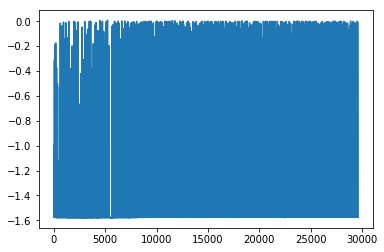

In [21]:
plt.plot(lossD)

## View

In [22]:
fake = netG(fixed_noise).data.cpu()

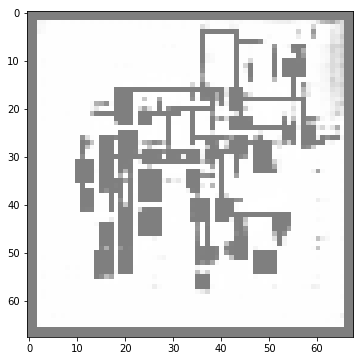

In [25]:
show(vutils.make_grid(fake[5:6,:,:,:]))

In [225]:
fake[44,0,:,:]


 0.0059  0.0013  0.0025  ...   0.0022  0.0039  0.0123
 0.0008  0.0016  0.0299  ...   0.0070  0.0176  0.0018
 0.0007  0.0034  0.0265  ...   0.0136  0.0339  0.0042
          ...             ⋱             ...          
 0.0008  0.0065  0.0428  ...   0.0164  0.0126  0.0014
 0.0008  0.0115  0.0322  ...   0.0173  0.0152  0.0017
 0.0075  0.0015  0.0029  ...   0.0016  0.0025  0.0074
[torch.FloatTensor of size 64x64]

In [139]:
fakeshow(vutils.make_grid(iter(dataloader).next()[0]))

NameError: name 'fakeshow' is not defined

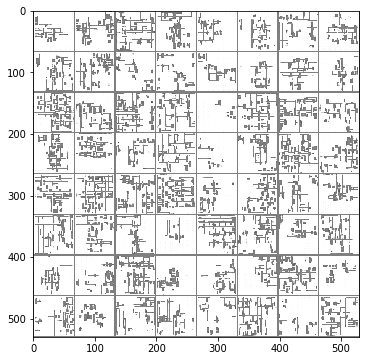

In [186]:
show(vutils.make_grid(fake))

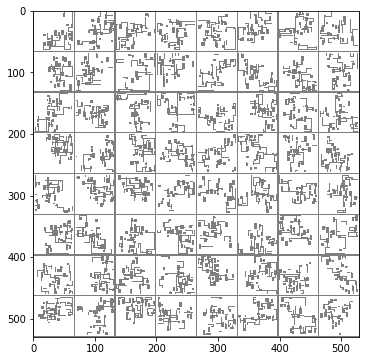

In [180]:
show(vutils.make_grid(iter(dataloader).next()))

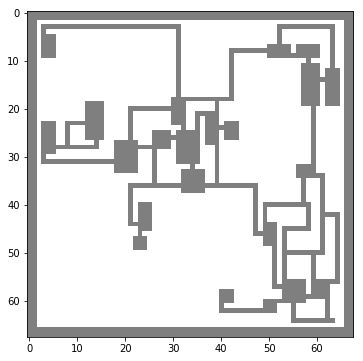

In [8]:
show(vutils.make_grid(iter(dataloader).next()[6:7,:,:,:]))

In [17]:
for i in range(0, 20):
    save(vutils.make_grid(iter(dataloader).next()[i:i+1,:,:,:]), str.format("digger_train{}.png", i))